## Ensaios sobre previsibilidade nas eleições para vereador
### 1. Introdução
- Trata o presente de ensios, análises e testes sobre a viabilidade de uso de inteligência artificial para fins de predição das chances de eleição de candidatos para o cargo de vereador, nas eleições municipais
- O foco será a análise com base nas caracteristicas dos candidatos e outras que puderem ser agregadas

### 2. Dados utilizados no estudo
#### Bases utilizadas:
- base candidatos do TSE (consulta_cand_AAAA_UF.txt): esta é a base principal, com informações dos candidatos
- base legenda/coligação 
- base quantidade de vagas
- base bens dos condidatos
- base prestação de contas
    - receitas de campanha
    - despesas decampanha
- base resultados
    - votacao_candidato_munzona_AAAA_UF.txt

### 3. Leitura e tratamento dos dados
#### Fonte principal dos dodos: Repositório de dados do TSE
*https://www.tse.jus.br/eleicoes/estatisticas/repositorio-de-dados-eleitorais-1/repositorio-de-dados-eleitorais

#### Observações gerais:
- conforme indicado nos arquivos de apoio (leia.me) do TSE:
    - a codificação dos caracteres dos arquivos é 'latin_1';
    - os campos estão entre aspas "" e separados por ponto e vírgula, inclusive os campos numéricos;
    - O campo UF, além das unidades da federação pode conter alguma das seguintes situações:
        - BR – Quando se tratar de informação a nível nacional;
        - VT – Quando se tratar de voto em trânsito;
        - ZZ – Quando se tratar de Exterior.
    - todas as informações referentes as candidaturas são de responsabilidade do candidato;


In [1]:
# importa bibliotecas que serão usadas no projeto
import os
from zipfile import ZipFile
import shutil
import re
import pandas as pd
import numpy as np
from datetime import datetime
import sweetviz as sv
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# configurações gerais de visualização do jupyter notebook
d_configuracao = {
    'display.max_columns': 150,
    'display.expand_frame_repr': True,
    'display.max_rows': 40,
    'display.precision': 2,
    'display.show_dimensions': True,}

pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
for op, value in d_configuracao.items():
    pd.set_option(op, value)
    print(op, value)

display.max_columns 150
display.expand_frame_repr True
display.max_rows 40
display.precision 2
display.show_dimensions True


### 3.1. Importa dados dos candidatos as eleições
- origem: repositório de dados do TSE
*https://www.tse.jus.br/eleicoes/estatisticas/repositorio-de-dados-eleitorais-1/repositorio-de-dados-eleitorais

- tema: "candidatos"
- arquivo: "consulta_cand_2008.zip"
*https://cdn.tse.jus.br/estatistica/sead/odsele/consulta_cand/consulta_cand_2008.zip


#### O foco do estudo serão as eleições para o legislativo municipal no ano de 2008

#### Observações sobre os arquivos de candidatos do TSE
- 3 alterações no layout das informações disponíveis dos candidatos ao longo dos anos:
    - até 2010 (layount base)
    - em 2012 (acrescimo de endereço de e-mail no layout base)
    - a partir de 2014 (diversos acrescimos/ alterações):

In [3]:
# função para leitura de dados da base "candidatos" do TSE
def le_cand(ano, uf):
    # nomes das colunas até 2010
    c_10 = ['DT_GERACAO','HH_GERACAO','ANO_ELEICAO','NR_TURNO','DS_ELEICAO','SG_UF','SG_UE','NM_UE',
        'CD_CARGO','DS_CARGO','NM_CANDIDATO','SQ_CANDIDATO','NR_CANDIDATO','NR_CPF_CANDIDATO','NM_URNA_CANDIDATO',
        'CD_SITUACAO_CANDIDATURA','DS_SITUACAO_CANDIDATURA','NR_PARTIDO','SG_PARTIDO','NM_PARTIDO','SQ_LEGENDA',
        'SG_LEGENDA','COMPOSICAO_LEGENDA','NM_LEGENDA','CD_OCUPACAO','DS_OCUPACAO','DT_NASCIMENTO',
        'NR_TITULO_ELEITORAL_CANDIDATO','IDADE_DATA_ELEICAO','CD_GENERO','DS_GENERO','CD_GRAU_INSTRUCAO',
        'DS_GRAU_INSTRUCAO','CD_ESTADO_CIVIL','DS_ESTADO_CIVIL','CD_NACIONALIDADE','DS_NACIONALIDADE',
        'SG_UF_NASCIMENTO','CD_MUNICIPIO_NASCIMENTO','NM_MUNICIPIO_NASCIMENTO','VR_DESPESA_MAX_CAMPANHA',
        'CD_SIT_TOT_TURNO','DS_SIT_TOT_TURNO']

    # nomes das colunas em 2012
    c_12 = ['DT_GERACAO','HH_GERACAO','ANO_ELEICAO','NR_TURNO','DS_ELEICAO','SG_UF','SG_UE','NM_UE',
        'CD_CARGO','DS_CARGO','NM_CANDIDATO','SQ_CANDIDATO','NR_CANDIDATO','NR_CPF_CANDIDATO','NM_URNA_CANDIDATO',
        'CD_SITUACAO_CANDIDATURA','DS_SITUACAO_CANDIDATURA','NR_PARTIDO','SG_PARTIDO','NM_PARTIDO','SQ_LEGENDA',
        'SG_LEGENDA','COMPOSICAO_LEGENDA','NM_LEGENDA','CD_OCUPACAO','DS_OCUPACAO','DT_NASCIMENTO',
        'NR_TITULO_ELEITORAL_CANDIDATO','IDADE_DATA_ELEICAO','CD_GENERO','DS_GENERO','CD_GRAU_INSTRUCAO',
        'DS_GRAU_INSTRUCAO','CD_ESTADO_CIVIL','DS_ESTADO_CIVIL','CD_NACIONALIDADE','DS_NACIONALIDADE',
        'SG_UF_NASCIMENTO','CD_MUNICIPIO_NASCIMENTO','NM_MUNICIPIO_NASCIMENTO','VR_DESPESA_MAX_CAMPANHA',
        'CD_SIT_TOT_TURNO','DS_SIT_TOT_TURNO','NM_EMAIL']
    
    # nome do arquivo zipado, fornecido pelo TSE
    nome_zip = 'tse/candidatos/consulta_cand_' + str(ano) + '.zip' 
    
    # define nome do arquivo dentro do arquivo zip, a depender do ano
    if ano > 2012:
        arq = 'consulta_cand_' + str(ano) + '_' + uf + '.csv'
        cols = None
    else:
        arq = 'consulta_cand_' + str(ano) + '_' + uf + '.txt'
        if ano == 2012:
            cols = c_12
        else: 
            cols = c_10
    
    # abre arquivo zipado
    zf = ZipFile(nome_zip)
    
    # faz a leitura do arquivo da base de candidatos, usando read_csv
    df = pd.read_csv(zf.open(arq), sep=';', encoding='latin_1', names=cols, dtype= {'NR_CPF_CANDIDATO': 'string'})
    return df    

In [4]:
# lê dados de candidatos das eleições 2008
cd = le_cand(2008,'SP')

In [5]:
# municipios com maior quantidade de candidatos
# o único que atende, individualmente, ao requisito mínimo da Puc-Minas (de 1000 observação) é São Paulo
cd.groupby('SG_UE').agg({'ANO_ELEICAO':'count'}).sort_values('ANO_ELEICAO', ascending=False).head()

,ANO_ELEICAO
SG_UE,
71072,1237
64777,891
62910,723
70750,498
67890,474


In [6]:
cd.shape

(63633, 43)

In [7]:
cols = ['CD_CARGO','DS_CARGO']
cd[cols].drop_duplicates()

,CD_CARGO,DS_CARGO
0,11,PREFEITO
3,12,VICE-PREFEITO
40,13,VEREADOR
63631,91,VOCÊ É A FAVOR DA | ALTERAÇÃO DO NOME | DA CID...


In [8]:
# deixa na base dados inicial somente os dados de candidaturas a vereador 
cd08 = cd.query('CD_CARGO == 13').copy()

In [9]:
# tamanho inicial da base de candidatos
cd08.shape

(59536, 43)

In [10]:
# procura por missing values no dataframe
cd08.isnull().values.any()

False

In [11]:
cd08[cd08.duplicated()]

,DT_GERACAO,HH_GERACAO,ANO_ELEICAO,NR_TURNO,DS_ELEICAO,SG_UF,SG_UE,NM_UE,CD_CARGO,DS_CARGO,NM_CANDIDATO,SQ_CANDIDATO,NR_CANDIDATO,NR_CPF_CANDIDATO,NM_URNA_CANDIDATO,CD_SITUACAO_CANDIDATURA,DS_SITUACAO_CANDIDATURA,NR_PARTIDO,SG_PARTIDO,NM_PARTIDO,SQ_LEGENDA,SG_LEGENDA,COMPOSICAO_LEGENDA,NM_LEGENDA,CD_OCUPACAO,DS_OCUPACAO,DT_NASCIMENTO,NR_TITULO_ELEITORAL_CANDIDATO,IDADE_DATA_ELEICAO,CD_GENERO,DS_GENERO,CD_GRAU_INSTRUCAO,DS_GRAU_INSTRUCAO,CD_ESTADO_CIVIL,DS_ESTADO_CIVIL,CD_NACIONALIDADE,DS_NACIONALIDADE,SG_UF_NASCIMENTO,CD_MUNICIPIO_NASCIMENTO,NM_MUNICIPIO_NASCIMENTO,VR_DESPESA_MAX_CAMPANHA,CD_SIT_TOT_TURNO,DS_SIT_TOT_TURNO


In [12]:
cd08.sample(3)

,DT_GERACAO,HH_GERACAO,ANO_ELEICAO,NR_TURNO,DS_ELEICAO,SG_UF,SG_UE,NM_UE,CD_CARGO,DS_CARGO,NM_CANDIDATO,SQ_CANDIDATO,NR_CANDIDATO,NR_CPF_CANDIDATO,NM_URNA_CANDIDATO,CD_SITUACAO_CANDIDATURA,DS_SITUACAO_CANDIDATURA,NR_PARTIDO,SG_PARTIDO,NM_PARTIDO,SQ_LEGENDA,SG_LEGENDA,COMPOSICAO_LEGENDA,NM_LEGENDA,CD_OCUPACAO,DS_OCUPACAO,DT_NASCIMENTO,NR_TITULO_ELEITORAL_CANDIDATO,IDADE_DATA_ELEICAO,CD_GENERO,DS_GENERO,CD_GRAU_INSTRUCAO,DS_GRAU_INSTRUCAO,CD_ESTADO_CIVIL,DS_ESTADO_CIVIL,CD_NACIONALIDADE,DS_NACIONALIDADE,SG_UF_NASCIMENTO,CD_MUNICIPIO_NASCIMENTO,NM_MUNICIPIO_NASCIMENTO,VR_DESPESA_MAX_CAMPANHA,CD_SIT_TOT_TURNO,DS_SIT_TOT_TURNO
13423,06/10/2020,14:56:30,2008,1,Eleições 2008,SP,63479,CONCHAS,13,VEREADOR,JOSÉ APARECIDO MOREIRA,5668,23333,04166875809,TOSTÃO,2,DEFERIDO,23,PPS,PARTIDO POPULAR SOCIALISTA,641,#NE#,#NE#,RENOVAR E INOVAR,999,OUTROS,01/02/1956,159252530191,-1,2,MASCULINO,4,ENSINO FUNDAMENTAL COMPLETO,3,CASADO(A),1,BRASILEIRA NATA,SP,-1,CONCHAS,-1,2,SUPLENTE
22329,06/10/2020,14:56:30,2008,1,Eleições 2008,SP,64955,IBIÚNA,13,VEREADOR,JOAO LUCAS DE FRANCA FILHO,34862,14114,56536453891,JOAO LUCAS,2,DEFERIDO,14,PTB,PARTIDO TRABALHISTA BRASILEIRO,3023,#NE#,#NE#,#NULO#,157,TÉCNICO DE LABORATÓRIO E RAIOS X,26/08/1946,86360600141,-1,2,MASCULINO,6,ENSINO MÉDIO COMPLETO,3,CASADO(A),1,BRASILEIRA NATA,RN,-1,APODI,-1,2,SUPLENTE
37288,06/10/2020,14:56:30,2008,1,Eleições 2008,SP,67814,ONDA VERDE,13,VEREADOR,WANDERLEY GALDINO BEZERRA,51079,13150,21717041876,MELLA,14,INDEFERIDO,13,PT,PARTIDO DOS TRABALHADORES,4593,#NE#,#NE#,#NULO#,503,FAXINEIRO,11/07/1962,236156180175,-1,2,MASCULINO,4,ENSINO FUNDAMENTAL COMPLETO,1,SOLTEIRO(A),1,BRASILEIRA NATA,CE,-1,MISSÃO VELHA,-1,-1,#NULO#


#### Análise incial dos dados de candidatos

In [13]:
# gera arquivos html com análise exploratória inicial dos dados, usando biblioteca sweetviz
testeviz = sv.analyze(cd08)
testeviz.show_html('dfcd08.html')


Report dfcd08.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


### 3.1.1. Observações acerca da análise preliminar dos dados:

#### Colunas sem dados informados, ou com dados imprestáveis:
    - SG_LEGENDA apenas o valor '#NE#' informado para todos os candidatos,
    - COMPOSICAO_LEGENDA apenas o valor '#NE#' infoprmado para todos os candidatos,
    - SQ_LEGENDA não confiável, como será visto a seguir
    - IDADE_DATA_ELEICAO apenas o valor '-1' informado para todos os candidatos, 
    - CODIGO_MUNICIPIO_NASCIMENTO apenas o valor '-1' infoprmado para todos os candidatos, 
    - VR_DESPESA_MAX_CAMPANHA apenas o valor '-1' infoprmado para todos os candidatos

#### Missing Values
Apesar da análise exploratória indicar a inexistência de missing values, os arquivos de apoio do TSE indicam que:

- campos preenchidos com “#NULO” significam que a informação está em branco no banco de dados;
- correspondente para #NULO nos campos numéricos é “-1”;
- campos preenchidos com “#NE” significam que naquele ano a informação não era registrada em banco de dados pelos sistemas eleitorais;
- correspondente para #NE nos campos numéricos é “-3”
- assim, entendemos que campos preenchidos com estes valores são, na verdade, missing values.

In [14]:
# colunas que contem um único valor em todos os registro e respectivo valor
for col in cd08.columns:
    if cd08[col].nunique() == 1:
        print(col, cd08[col].unique())

DT_GERACAO ['06/10/2020']
HH_GERACAO ['14:56:30']
ANO_ELEICAO [2008]
NR_TURNO [1]
DS_ELEICAO ['Eleições 2008']
SG_UF ['SP']
CD_CARGO [13]
DS_CARGO ['VEREADOR']
SG_LEGENDA ['#NE#']
COMPOSICAO_LEGENDA ['#NE#']
IDADE_DATA_ELEICAO [-1]
CD_MUNICIPIO_NASCIMENTO [-1]
VR_DESPESA_MAX_CAMPANHA [-1]


### 3.1.2. Tratamento missing values:

- SG_LEGENDA e COMPOSICAO_LEGENDA
    - existe fonte de dados alternativa para coletar estas informações
    - excluir colunas relacionadas a coligações e legendas
    
- VR_DESPESA_MAX_CAMPANHA
    - apenas o valor '-1' informado para todos os candidatos
    - não temos fonte alternativa para corrigir o problema
    - excluir coluna pois não terá nenhuma utilidade nas análises

- IDADE_DATA_ELEICAO 
    - apenas o valor '-1' informado para todos os candidatos
    - calcular idade do candidato com base na data de nascimento, disponivel em coluna própria
    - usar "idade na data da posse", ao invés de "idade na data eleição" para fins de padronização

- CODIGO_MUNICIPIO_NASCIMENTO 
    - apenas o valor '-1' infoprmado para todos os candidatos: imprestável
    - tentar recuperar nome e codigo de municipio de nascimento de tabela do IBGE

#### 3.1.2.1 Exclui colunas relacionadas a base de coligações

In [15]:
# exclui colunas inconsistentes da base candidatos relacionadas a coligações:
remove_cols = ['SQ_LEGENDA','SG_LEGENDA','COMPOSICAO_LEGENDA','NM_LEGENDA' ]
cd08.drop(remove_cols, axis=1, inplace=True)

#### 3.1.2.2 Exclui outras colunas imprestáveis

In [16]:
# exclui colunas NaN da base candidatos:
remove_cols = ['VR_DESPESA_MAX_CAMPANHA' ]
cd08.drop(remove_cols, axis=1, inplace=True)

#### 3.1.2.3 Calcula idade na data da posse e coloca na coluna IDADE_DATA_ELEICAO
 - na base de candidatos do TSE para o ano de 2008 este campo veio todo com valor '-1', ou seja, NaN
 - temos o campo data de nascimento
 - vamos calcular a idade do candidato com base em sua data de nascimento
 - a partir do ano 2014, a base do TSE passa trazer o campo idade na data da posse.
 - para manter padronização, nosso novo campo calculado será idade na data da posse

In [17]:
# altera tipo do campo DT_NASCIMENTO para daytime
from datetime import date, timedelta
cd08['DT_NASCIMENTO'] = pd.to_datetime(cd08['DT_NASCIMENTO'], dayfirst=True)

In [18]:
# calcula idade na data da posse (a posse é sempre no dia 1 de janeiro do ano seguinte ao das eleições)
cd08['IDADE_DATA_ELEICAO'] = (pd.to_datetime('2009-01-01') - cd08['DT_NASCIMENTO'])//timedelta(days=365.2425)

In [19]:
# renomerar coluna para idade_data_posse
cd08.rename(columns={'IDADE_DATA_ELEICAO':'IDADE_DATA_POSSE'}, inplace=True)

In [20]:
cd08.sample(3)

,DT_GERACAO,HH_GERACAO,ANO_ELEICAO,NR_TURNO,DS_ELEICAO,SG_UF,SG_UE,NM_UE,CD_CARGO,DS_CARGO,NM_CANDIDATO,SQ_CANDIDATO,NR_CANDIDATO,NR_CPF_CANDIDATO,NM_URNA_CANDIDATO,CD_SITUACAO_CANDIDATURA,DS_SITUACAO_CANDIDATURA,NR_PARTIDO,SG_PARTIDO,NM_PARTIDO,CD_OCUPACAO,DS_OCUPACAO,DT_NASCIMENTO,NR_TITULO_ELEITORAL_CANDIDATO,IDADE_DATA_POSSE,CD_GENERO,DS_GENERO,CD_GRAU_INSTRUCAO,DS_GRAU_INSTRUCAO,CD_ESTADO_CIVIL,DS_ESTADO_CIVIL,CD_NACIONALIDADE,DS_NACIONALIDADE,SG_UF_NASCIMENTO,CD_MUNICIPIO_NASCIMENTO,NM_MUNICIPIO_NASCIMENTO,CD_SIT_TOT_TURNO,DS_SIT_TOT_TURNO
27928,06/10/2020,14:56:30,2008,1,Eleições 2008,SP,65897,JACAREÍ,13,VEREADOR,HELENA DA SILVA SANTOS,52026,40467,10536827869,HELENA,2,DEFERIDO,40,PSB,PARTIDO SOCIALISTA BRASILEIRO,923,APOSENTADO (EXCETO SERVIDOR PÚBLICO),1942-03-08,25510370116,66,4,FEMININO,6,ENSINO MÉDIO COMPLETO,3,CASADO(A),1,BRASILEIRA NATA,SP,-1,JACAREÍ,4,NÃO ELEITO
29837,06/10/2020,14:56:30,2008,1,Eleições 2008,SP,66230,JUQUIÁ,13,VEREADOR,VICTOR HUGO GIL BARBOSA,29941,23333,21965179843,VITINHO,2,DEFERIDO,23,PPS,PARTIDO POPULAR SOCIALISTA,169,COMERCIANTE,1981-04-24,276291550175,27,2,MASCULINO,5,ENSINO MÉDIO INCOMPLETO,1,SOLTEIRO(A),1,BRASILEIRA NATA,SP,-1,JUQUIÁ,2,SUPLENTE
51760,06/10/2020,14:56:30,2008,1,Eleições 2008,SP,70750,SÃO BERNARDO DO CAMPO,13,VEREADOR,CARLOS RENE ISSA CASTELLO,49861,25111,26054920871,CARLÃO BBB,2,DEFERIDO,25,DEM,DEMOCRATAS,131,ADVOGADO,1977-12-01,260094570191,31,2,MASCULINO,8,SUPERIOR COMPLETO,1,SOLTEIRO(A),1,BRASILEIRA NATA,SP,-1,SAO PAULO,2,SUPLENTE


#### 3.1.2.4 Tentativa recuperar codigo municipio nascimento da base de municipios TSE
- na base de dados de candidatos, a coluna cd_municipio_nascimento está sem valores informados (-1) = NaN
- por outro lado a coluna nm_municio_nascimento tem valores preenchidos
- entretanto é uma coluna de livre preenchimento e sem criticas, portanto sujeita a todo tipo de erros
- vamos tentar recuperar o código do município do TSE a partir da UF e do nome do informados pelo candidato (estão na tabela candidatos), comparando com o nome dos municipios constantes da tabela do TSE

#### Estratégia usada para tentar encontrar o nome correto do município e seu respectivo código:
    1) Preparação das bases de dados
        
        1.1) da nossa base de canditados, extraímos uma base mais enxuta, apenas com os campos:
            - SQ_CANDIDATO
            - UF
            - NM_MUNICIPIO_NASCIMENTO
        
        1.2) bases de referência para comparação:
            - o TSE usa codificação de municípios própria, porém não tem informação de distritos/subdistritos. 
            - O IBGE tem codificação detalhada para cada, município, distrito e subdistrito, dentre outros
            - juntamos a codificação do IBGE até o nível de subdistritos e acrescentamos a ela o codigo de municipio usado pelo TSE. 
            - esta foi a nossa base final, que serviu de referencia para as pesquisas
            
    2) Normalização das bases 
        - Como a coluna NM_MUNICIPO_NASCIMENTO da base de canditados do TSE é de livre preenchimento e, portanto, sujeita a todo tipo de erros, inicialmente tentamos "normalizar" esta coluna para facilitar na etapa de pesquisas. a pesquisa. Assim, o primeiro passo foi:
        
        2.1) deixar todos os nomes de municipios em minúsculas (tanto base IBGE/TSE quanto na base candidatos)
        2.2) retirar a acentuação (na base IBGE/TSE e na base candidatos)
    
    3) Feita a normalização inicial, executamos comparações de semelhança entre entre os nomes informados na base de candidatos e os nomes constantes da base do IBGE/TSE, na seguinte ordem:
    
    3.1) busca se o par (uf, nome_município) informados na base candidatos tem correlação IDÊNTICA na base do IBGE/TSE:
        - para as linhas que tiveram correlação idêndica, recuperamos da base do IBGE/TSE o código de município do TSE e separamos em uma base de sucesso, que posteriormente atualizará a base de candidatos
        - os registros que não tiveram correlação positiva foram separados em um novo dataframe, para tentar tratar na etapa seguinte.
    
    3.2) busca se o par (uf, nome_município) informados na base candidatos tem correlação IDÊNTICA no par (uf, nome_distrito) da base do IBGE
        - linhas com correlação idêntica, recuperamos o código de município do TSE
        - linhas sem correlação, separadas para a proxima etapa de busca

    3.3) busca se o par (uf, nome_município) informados na base candidatos tem correlação IDÊNTICA no par (uf, nome_subdistrito) da base do IBGE
        - linhas com correlação idêntica, recuperamos o código de município do TSE
        - linhas sem correlação, separadas para a proxima etapa de busca

    3.4) busca se o par (uf, nome_município) informados na base candidatos tem correlação SIMILAR no par (uf, nome_município) da base do IBGE
        - linhas com correlação de semelhança, recuperamos o código de município do TSE
        - linhas sem correlação, separadas para a proxima etapa de busca
            
    3.5) busca se o par (uf, nome_município) informados na base candidatos tem correlação SIMILAR no par (uf, nome_distrito) da base do IBGE
        - linhas com correlação de semelhança, recuperamos o código de município do TSE
        - linhas sem correlação, separadas para a proxima etapa de busca

    3.6) busca se o par (uf, nome_município) informados na base candidatos tem correlação SIMILAR no par (uf, nome_subdistrito) da base do IBGE
        - linhas com correlação de semelhança, recuperamos o código de município do TSE
        - linhas sem correlação, separadas para a proxima etapa de busca

    3.6) tratar por códigos de UF extrangeiros
        - conforme descrito no 'leia.me' dos arquivos do TSE, a campo UF pode conter, além da unidade da federação, o valor valor 'ZZ' quando se tratar de localidade no exterior
        - para estes casos, nos pareceu válido usar um código específico para candidatos nascidos fora do Brasil
        - imputamos o valor -5 para estes casos
    
    3.7) busca se o (nome_município) informados na base candidatos tem correlação SIMILAR em (nome_município, nome_distrito e nome_subdistrito) da base do IBGE
        - linhas com correlação de semelhança, recuperamos o código de município do TSE
        - linhas sem correlação, não serão mais tratadas e reberão valor -1 

*  para realizar as pesquisas de similaridade utilizamos a biblioteca difflib do python. Esta biblioteca é baseada no algoritmo publicado por de Ratcliff and Obershelp, no final dos anos 80, com o nome 'gestalt pattern matching'.
* está biblioteca tem um parametro de "corte": cutoff:
    - cutoff varia de 0 a 1, 
    - o valor 1 indica pesquisa IDÊNTICA
    - quanto mais proximo de 0 mais tolerável a erro
    - o padrão da biblioteca é 0.6
    - após algumas observações, decidimos usar o valor 0.65, por entender ser um valor  adequado ao caso

* tabela de distritos obtida portal ibge:
* https://www.ibge.gov.br/geociencias/organizacao-do-territorio/estrutura-territorial/23701-divisao-territorial-brasileira.html?=&t=downloads

* tabela de municípios TSE, baixada de:
* https://github.com/betafcc/Municipios-Brasileiros-TSE


#### Dataset resumido de candidatos

In [21]:
# cria dataset resumido com com cod candidato e nome municipio nascimento
cols = ['SQ_CANDIDATO','SG_UF_NASCIMENTO','NM_MUNICIPIO_NASCIMENTO']
uen = cd08[cols].copy()
# renomeia coluna uf para ficar no mesmo padrão da tabela tse
uen.rename(columns={'SG_UF_NASCIMENTO':'uf', 'NM_MUNICIPIO_NASCIMENTO':'nm_mun_dig'}, inplace=True)
# normaliza nome do municipio - cria coluna com o nome em caixa baixa e sem acentos
uen['muni_norm'] = uen['nm_mun_dig'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('latin-1').str.lower()

In [22]:
uen.head(3)

,SQ_CANDIDATO,uf,nm_mun_dig,muni_norm
40,27238,SP,JUNQUEIROPOLIS,junqueiropolis
41,18841,SP,ADAMANTINA,adamantina
42,14043,SP,ADAMANTINA,adamantina


#### Montagem da base de pesquisa / comparação

In [23]:
from unicodedata import normalize #importa biblioteca para retirar acentuação de palavras
import difflib #importa biblioteca difflib para pesquisas de palavras por semelhança

#### Importa tabela com codigos do IBGE de 2008

In [24]:
# lendo tabelas de distritos e subdistritos IBGE de 2008
zf = ZipFile('ibge/dtb_2008.zip')
arq = 'DTB_2008.xls'
tipos = {'UF':'string','Município':'string'}
# lista das colunas de ineteresse da tabela do IBGE
cols = ['UF','Município','Nome_Município','Nome_Distrito','Nome_SubDistrito']
# lê tabela xls do IBGE armazena resultado em dataframe pandas, apenas com as colunas de interesse
dist_ibge = pd.read_excel(zf.open(arq), dtype=tipos)[cols]
# cria coluna com código completo do município (cod uf + cod municipio)
#dist_ibge['cod_mun'] = dist_ibge['UF'] + dist_ibge['Município']

In [25]:
dist_ibge.head(2)

,UF,Município,Nome_Município,Nome_Distrito,Nome_SubDistrito
0,11,00015,Alta Floresta D'Oeste,Rolim de Moura do Guaporé,NaN
1,11,00015,Alta Floresta D'Oeste,Izidolândia,NaN


In [26]:
# dicionário com siglas e códigos das UF
dict_uf = {'11':'RO', '12':'AC', '13':'AM', '14':'RR', '15':'PA',
           '16':'AP', '17':'TO', '21':'MA', '22':'PI', '23':'CE',
           '24':'RN', '25':'PB', '26':'PE', '27':'AL', '28':'SE',
           '29':'BA', '31':'MG', '32':'ES', '33':'RJ', '35':'SP',
           '41':'PR', '42':'SC', '43':'RS', '50':'MS', '51':'MT',
           '52':'GO', '53':'DF'}

In [27]:
# cria coluna com sigla do uf
dist_ibge['uf'] = dist_ibge['UF'].map(dict_uf)
# cria coluna com codigo de município do IBGE completo 
dist_ibge['cd_mun_ibge'] = (dist_ibge['UF'] + dist_ibge['Município']).astype(int)
# lista das colunas de ineteresse
cols_final = ['uf','cd_mun_ibge','Nome_Município','Nome_Distrito','Nome_SubDistrito']
# cria df ibge apenas com colunas de ineteresse
tab_ibge = dist_ibge[cols_final]
# renomeia colunas do df
tab_ibge.columns = ['uf','cd_mun_ibge','nm_mun','nm_dist','nm_subdist']

In [28]:
tab_ibge.head(2)

,uf,cd_mun_ibge,nm_mun,nm_dist,nm_subdist
0,RO,1100015,Alta Floresta D'Oeste,Rolim de Moura do Guaporé,NaN
1,RO,1100015,Alta Floresta D'Oeste,Izidolândia,NaN


In [29]:
tab_ibge.shape

(10575, 5)

In [30]:
# cria tabelas individualizadas para municipios, distritos e subdistritos
muni = ['uf','cd_mun_ibge','nm_mun']
dist = ['uf','cd_mun_ibge','nm_dist']
subd = ['uf','cd_mun_ibge','nm_subdist']
tb_muni = tab_ibge[muni].copy().drop_duplicates().sort_values(['uf','cd_mun_ibge'])
tb_dist = tab_ibge[dist].copy().drop_duplicates().dropna(subset=['nm_dist']).sort_values(['uf','cd_mun_ibge'])
tb_subd = tab_ibge[subd].copy().drop_duplicates().dropna(subset=['nm_subdist']).sort_values(['uf','cd_mun_ibge'])

tb_muni['nm_mun'] = tb_muni['nm_mun'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('latin-1').str.lower()
tb_dist['nm_dist'] = tb_dist['nm_dist'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('latin-1').str.lower()
tb_subd['nm_subdist'] = tb_subd['nm_subdist'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('latin-1').str.lower()

In [31]:
tb_muni.head(2)

,uf,cd_mun_ibge,nm_mun
101,AC,1200013,acrelandia
102,AC,1200054,assis brasil


In [32]:
tb_muni.shape

(5564, 3)

In [33]:
tb_dist.head(2)

,uf,cd_mun_ibge,nm_dist
101,AC,1200013,acrelandia
102,AC,1200054,assis brasil


In [34]:
tb_dist.shape

(10104, 3)

In [35]:
tb_subd.head(2)

,uf,cd_mun_ibge,nm_subdist
2876,AL,2704302,primeira regiao
2877,AL,2704302,quarta regiao


In [36]:
tb_subd.shape

(460, 3)

#### Importa tabela com códigos do TSE

In [37]:
# le tabela de municipios tse/ibge
muni_tse = pd.read_csv('tse/municipios_brasileiros_tse_2.csv')
# cria coluna com nome normalizado (sem acentos e tudo minuscula)
muni_tse['muni_norm'] = muni_tse['nome_municipio'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('latin-1').str.lower()
# renomeia colunas 
muni_tse.columns = ['cd_tse','uf', 'nm_municipio', 'capital', 'cd_mun_ibge', 'muni_norm']
# colunas de interesse
cols_fim = ['uf', 'cd_tse', 'cd_mun_ibge', 'muni_norm']
tb_tse = muni_tse[cols_fim].copy()
tb_tse.rename(columns={'muni_norm':'nm_mun'}, inplace=True)

In [38]:
muni_tse.head(2)

,cd_tse,uf,nm_municipio,capital,cd_mun_ibge,muni_norm
0,1120,AC,ACRELÂNDIA,0,1200013,acrelandia
1,1570,AC,ASSIS BRASIL,0,1200054,assis brasil


In [39]:
tb_tse.head(2)

,uf,cd_tse,cd_mun_ibge,nm_mun
0,AC,1120,1200013,acrelandia
1,AC,1570,1200054,assis brasil


In [40]:
# acrescenta a tabela de municipios do ibge o cod municipio e nome municipio, conforme tabela tse
cols = ['cd_tse','cd_mun_ibge','nm_mun']
tb_muni = tb_muni.merge(tb_tse[cols], how='left', on=['cd_mun_ibge'], suffixes=(None, '_tse'))

In [41]:
tb_muni.head(2)

,uf,cd_mun_ibge,nm_mun,cd_tse,nm_mun_tse
0,AC,1200013,acrelandia,1120,acrelandia
1,AC,1200054,assis brasil,1570,assis brasil


In [42]:
tb_muni.shape

(5564, 5)

In [43]:
# acrescenta a tabela de distritos do ibge o cod municipio, conforme tabela tse
cols = ['cd_tse','cd_mun_ibge']
tb_dist = tb_dist.merge(tb_tse[cols], how='left', on=['cd_mun_ibge'], suffixes=(None, '_tse'))

In [44]:
tb_dist.head(2)

,uf,cd_mun_ibge,nm_dist,cd_tse
0,AC,1200013,acrelandia,1120
1,AC,1200054,assis brasil,1570


In [45]:
tb_dist.shape

(10104, 4)

In [46]:
# acrescenta a tabela de municipios do ibge o cod municipio e nome municipio, conforme tabela tse
cols = ['cd_tse','cd_mun_ibge']
tb_subd = tb_subd.merge(tb_tse[cols], how='left', on=['cd_mun_ibge'], suffixes=(None, '_tse'))

In [47]:
tb_subd.head(2)

,uf,cd_mun_ibge,nm_subdist,cd_tse
0,AL,2704302,primeira regiao,27855
1,AL,2704302,quarta regiao,27855


In [48]:
tb_subd.shape

(460, 4)

#### Função para fazer as pesquisas e retornar os dataframes

In [49]:
# com opção de não forçar buscas dentro do estado informado pelo candidato
import difflib
def busca_semelhanca(df_base,tipo,corte,filtro):
    df = pd.DataFrame()
    col_resultado = 'diff_' + tipo + '_corte_' + str(corte) + '_' + filtro
    # define tabela (df) e campo (coluna) onde buscar 
    if tipo == 'm':
        tab_base = tb_tse
        col_pesquisa = 'nm_mun'
        cols_tse=['cd_tse', 'uf', 'nm_mun']
    elif tipo == 'm1':
        tab_base = tb_muni
        col_pesquisa = 'nm_mun_tse'
        cols_tse=['cd_tse', 'uf', 'nm_mun_tse']
    elif tipo == 'm2':
        tab_base = tb_muni
        col_pesquisa = 'nm_mun'
        cols_tse=['cd_tse', 'uf', 'nm_mun']
    elif tipo == 'd':
        tab_base = tb_dist
        col_pesquisa = 'nm_dist'
        cols_tse=['cd_tse', 'uf', 'nm_dist']
    elif tipo == 's':
        tab_base = tb_subd
        col_pesquisa = 'nm_subdist'
        cols_tse=['cd_tse', 'uf', 'nm_subdist']
    
    if filtro == 'uf': # com filtro em uf
        # percorre 
        for estado in df_base['uf'].unique():
            # cria tabela tse/ibge somente para um estado especifico do 'for'
            dist_f = tab_base[tab_base['uf'] == estado]
            # cria df com uf nascimento somente de um estado especifo do 'for'
            uen_f = df_base[df_base['uf'] == estado].copy()
            f = lambda x: next(iter(difflib.get_close_matches(x, dist_f[col_pesquisa], cutoff=corte, n=1)), np.NaN)
            uen_f[col_resultado] = (uen_f['muni_norm']).apply(f)
            df = df.append(uen_f)
        # agrega o código tse (do df muni_tse) as linhas que obtiveram resultado na busca
        df = df.merge(tab_base[cols_tse], how='left', left_on=['uf',col_resultado], right_on=['uf',col_pesquisa])

    elif filtro == 'br': # sem filtro em uf
        df = df_base.copy()
        f = lambda x: next(iter(difflib.get_close_matches(x, tab_base[col_pesquisa], cutoff=corte, n=1)), np.NaN)
        df[col_resultado] = (df['muni_norm']).apply(f)
        # agrega o código tse (do df tb_tse) as linhas que obtiveram resultado na busca
        df = df.merge(tab_base[cols_tse], how='left', left_on=[col_resultado], right_on=[col_pesquisa])
        df.drop(columns=['uf_y','nm_mun'], inplace=True)
        df.rename(columns={'uf_x':'uf'}, inplace=True)
        
    # separa o resultado em 2 df: 1 que achou municipio e outro que não encontrou
    df.rename(columns={'muni_norm_x':'muni_norm'}, inplace=True)
    df1 = df[df.cd_tse.notna()].copy()
    cols1 = [0,1,2,4,5]
    df1 = df1[df1.columns[cols1]]
    cols = ['SQ_CANDIDATO','uf','nm_mun_dig','muni_norm']
    df2 = df[df.cd_tse.isna()].copy()[cols]
    print(f'{df_base.shape[0]} municipios pesquisados')
    print(f'{round(df1.shape[0] / df_base.shape[0] *100,2)}% ({df1.shape[0]}) encontrados')
    print(f'{round(df2.shape[0] / df_base.shape[0] *100,2)}% ({df2.shape[0]}) não encontrados')
    return df1,df2

#### 1a pesquisa para recuperar nome e codigo de municipios
- compara o par uf e nome do municipio informados pelo candidato
- retorna codigos apenas se encontar o par exato "uf" e "nome municipio" na base do IBGE/TSE
- pode ser feita via merge direto ou usando difflib com cutoff 1 (mesmo resultado)

In [50]:
# 1a busca: nome do par (uf, municipio) identico, entre o digitado pelo candidato e o nome TSE
tok,tbad = busca_semelhanca(uen, 'm2', 1, 'uf')

59536 municipios pesquisados
93.36% (55581) encontrados
6.64% (3955) não encontrados


In [51]:
tok.head()

,SQ_CANDIDATO,uf,nm_mun_dig,diff_m2_corte_1_uf,cd_tse
0,27238,SP,JUNQUEIROPOLIS,junqueiropolis,"66,214.00"
1,18841,SP,ADAMANTINA,adamantina,"61,018.00"
2,14043,SP,ADAMANTINA,adamantina,"61,018.00"
3,24672,SP,ADAMANTINA,adamantina,"61,018.00"
4,14044,SP,ADAMANTINA,adamantina,"61,018.00"


In [52]:
tbad.head()

,SQ_CANDIDATO,uf,nm_mun_dig,muni_norm
38,18851,SP,NOSSA SENHORA DAS GRAÇAS,nossa senhora das gracas
71,33951,SP,SANTA ROSA DO VITERBO,santa rosa do viterbo
76,33952,SP,VALE FORMOSO,vale formoso
82,33955,SP,SÃO JOSÉ RIO PRETO,sao jose rio preto
89,33957,SP,SÃO JOSÉ RIO PRETO,sao jose rio preto


In [53]:
# 1a busca (complemento): nome do par (uf, municipio) identico, entre o digitado pelo candidato e nome IBGE
tok1,tbad1 = busca_semelhanca(tbad, 'm', 1, 'uf')

3955 municipios pesquisados
4.45% (176) encontrados
95.55% (3779) não encontrados


#### A grande maioria dos códigos de municipios foram recuperados com a primeira tentativa
- recuperado 59568 do total de 63605 (93,65%)

#### Possivelmente existem outras inconsistencias nos cerca de 4000 não recuperados
- como se trata de um campo de livre preenchimento, seria normal uma quantidade grande de erros
- vamos tentar recuperar por semelhança entre as colunas uf e nome municipio 

#### 2a Pesquisa para recuperar nome e codigo de municipios
- compara o par uf e nome do municipio informados pelo candidato
- retorna codigos apenas se encontar o par exato em "uf" e "nome do distrito" na base do IBGE/TSE

In [54]:
# 2a busca: nome do par (uf, municipio) digitado identico ao par (uf, subdistrito) da base ibge/tse
tok2,tbad2 = busca_semelhanca(tbad1, 's', 1, 'uf')

3779 municipios pesquisados
0.29% (11) encontrados
99.71% (3768) não encontrados


In [55]:
tok2.head(3)

,SQ_CANDIDATO,uf,nm_mun_dig,diff_s_corte_1_uf,cd_tse
2475,36371,MG,PIEDADE,piedade,"46,477.00"
2512,19202,MG,VENDA NOVA,venda nova,"41,238.00"
2872,64196,BA,VITORIA,vitoria,"38,490.00"


In [56]:
tbad2.head(3)

,SQ_CANDIDATO,uf,nm_mun_dig,muni_norm
0,18851,SP,NOSSA SENHORA DAS GRAÇAS,nossa senhora das gracas
1,33951,SP,SANTA ROSA DO VITERBO,santa rosa do viterbo
2,33952,SP,VALE FORMOSO,vale formoso


#### 3a Pesquisa para recuperar nome e codigo de municipios
- compara o par uf e nome do municipio informados pelo candidato
- retorna codigos apenas se encontar o par exato em "uf" e "nome do distrito" na base do IBGE/TSE

In [57]:
# 3a busca: nome do par (uf, municipio) digitado, identico a (uf, distrito) na base ibge/tse
tok3,tbad3 = busca_semelhanca(tbad2, 'd', 1, 'uf')

3768 municipios pesquisados
13.61% (513) encontrados
86.62% (3264) não encontrados


In [58]:
tok3.head(3)

,SQ_CANDIDATO,uf,nm_mun_dig,diff_d_corte_1_uf,cd_tse
2,33952,SP,VALE FORMOSO,vale formoso,"67,717.00"
5,45902,SP,LAGOA BRANCA,lagoa branca,"63,177.00"
12,65149,SP,MONTALVÃO,montalvao,"69,299.00"


In [59]:
tbad3.sample(3)

,SQ_CANDIDATO,uf,nm_mun_dig,muni_norm
3062,49369,SC,ITAJOBI,itajobi
3763,30177,TO,MIRANTE DO PARANAPANEMA,mirante do paranapanema
412,54706,SP,EMBU GUAÇU,embu guacu


#### Percebe-se que a junção aumentou o numero de linhas na tabela uen_2
- tal fato ocorre devido a existencia de nomes de distritos identicos em um mesmo estado, porem em municipios diferentes.
- como tratar: escolheremos o primeiro encontrado e descartaremos os demais

In [60]:
# lista dos duplicados
tok3[tok3.duplicated(subset=['SQ_CANDIDATO','uf','diff_d_corte_1_uf'])]

,SQ_CANDIDATO,uf,nm_mun_dig,diff_d_corte_1_uf,cd_tse
818,60836,SP,PINHEIROS,pinheiros,"71,072.00"
820,61674,SP,PINHEIROS,pinheiros,"71,072.00"
1822,17694,SP,PINHEIROS,pinheiros,"71,072.00"
2034,36255,PR,OURO VERDE,ouro verde,"78,719.00"
2035,36255,PR,OURO VERDE,ouro verde,"79,014.00"
2127,45950,PR,SAO PEDRO,sao pedro,"74,250.00"
2509,60454,MG,SAO JOAQUIM,sao joaquim,"47,031.00"
2985,24406,CE,RIACHO VERDE,riacho verde,"15,814.00"
3047,11571,SC,SANTA LUCIA,santa lucia,"82,376.00"


#### Ainda temos 3264 candidatos com municipios não encontrados depois das 3 tentativas iniciais
- vamos tentar uma busca por proximidade no nome municipio

In [61]:
# 4a busca: nome de uf identica e municipio similar (digitado vs base ibge/tse)
tok4,tbad4 = busca_semelhanca(tbad3, 'm2', 0.7, 'uf')

3264 municipios pesquisados
76.75% (2505) encontrados
23.25% (759) não encontrados


In [62]:
tok4.sample(10)

,SQ_CANDIDATO,uf,nm_mun_dig,diff_m2_corte_0.7_uf,cd_tse
332,48915,SP,UTINGA,restinga,"69,558.00"
647,45639,SP,MIRANTE PARANAPANEMA,mirante do paranapanema,"67,059.00"
103,47009,SP,BADY BASSIT,bady bassitt,"61,913.00"
1461,47214,SP,PERDEINEIROS,pederneiras,"68,357.00"
2388,28373,BA,BRUAMADO,brumado,"33,910.00"
2525,21741,CE,IDROLNDIA,hidrolandia,"14,052.00"
584,9834,SP,SA PAULO,sao paulo,"71,072.00"
2832,67140,PB,S.MAMEDE,sao mamede,"21,997.00"
2284,2284,BA,STº ANTONIO DE JESUS,santo antonio de jesus,"38,733.00"
1995,38261,MG,SÃO TOMÁZ DE AQUINO,sao tomas de aquino,"53,015.00"


In [63]:
tbad4.head()

,SQ_CANDIDATO,uf,nm_mun_dig,muni_norm
0,18851,SP,NOSSA SENHORA DAS GRAÇAS,nossa senhora das gracas
5,35324,SP,BOTELHOS,botelhos
32,66809,SP,BRUMADO,brumado
57,63219,SP,A,a
59,10793,SP,SP,sp


#### Resultados da busca por proximidade no nome do municipio, obedecendo o estado
- Esta busca por proximidade com offset de 0.7 recuperou 76,75% dos nomes que ainda faltavam
- Aparentemente este foi um offset bom para o nosso problema
- faremos a mesma busca por proximidade em distrito e subdistrito a seguir

In [64]:
# 5a busca: nome de uf identica e subdistrito similar (digitado vs base ibge/tse)
tok5,tbad5 = busca_semelhanca(tbad4, 's', 0.8, 'uf')

759 municipios pesquisados
0.26% (2) encontrados
99.74% (757) não encontrados


In [65]:
tok5.head()

,SQ_CANDIDATO,uf,nm_mun_dig,diff_s_corte_0.8_uf,cd_tse
602,38860,RJ,SANTA TEREZA,santa teresa,"60,011.00"
629,61916,DF,TAQUATINGA,taguatinga,"97,012.00"


In [66]:
tbad5.head()

,SQ_CANDIDATO,uf,nm_mun_dig,muni_norm
0,18851,SP,NOSSA SENHORA DAS GRAÇAS,nossa senhora das gracas
1,35324,SP,BOTELHOS,botelhos
2,66809,SP,BRUMADO,brumado
3,63219,SP,A,a
4,10793,SP,SP,sp


In [67]:
# 6a busca: nome de uf identica e distrito similar (digitado vs base ibge/tse)
tok6,tbad6 = busca_semelhanca(tbad5, 'd', 0.8, 'uf')

757 municipios pesquisados
7.66% (58) encontrados
92.34% (699) não encontrados


In [68]:
tok6.head()

,SQ_CANDIDATO,uf,nm_mun_dig,diff_d_corte_0.8_uf,cd_tse
1,35324,SP,BOTELHOS,botelho,"70,130.00"
29,43911,SP,TERRA NOVA D OESTE,terra nova d'oeste,"70,432.00"
51,9799,SP,SANTA IZABEL DO MARINHEIRO,santa isabel do marinheiro,"68,390.00"
55,29369,SP,TALHADOS,talhado,"70,971.00"
77,65725,SP,ENGENHEIRO SHIMITH,engenheiro schmidt,"70,971.00"


In [69]:
tbad6.head()

,SQ_CANDIDATO,uf,nm_mun_dig,muni_norm
0,18851,SP,NOSSA SENHORA DAS GRAÇAS,nossa senhora das gracas
2,66809,SP,BRUMADO,brumado
3,63219,SP,A,a
4,10793,SP,SP,sp
5,23993,SP,A,a


#### Feitas as buscas por semelhança entre o nome de municipio digitado, comparado com municipios, distritos e subdistritos:
    - encontramos a grande maioria dos nomes
    - sobraram ainda 699 nomes não identificados


#### Proximos passos:
    - a UF ZZ na base do TSE indica exterior
    - marcar como codigo_tse "-5" os registros com UF == ZZ (exterior)
    - fazer ultima busca por proximidade, sem trava de estado, ou seja:
    - buscar em todos os municipios do Brasil, pelo nome digitado pelo candidato

In [70]:
# 7a intervenção: trata supostamente nascidos no exterior
tbad6.query('uf=="ZZ"')

,SQ_CANDIDATO,uf,nm_mun_dig,muni_norm
681,60911,ZZ,SIRIA,siria
682,33223,ZZ,SÍRIA,siria
683,5085,ZZ,MURTEDE - PORTUGAL,murtede - portugal
684,5092,ZZ,PRAIA A MARE,praia a mare
685,65859,ZZ,FLORENSE,florense
...,...,...,...,...
731,60865,ZZ,HERAKLION,heraklion
732,10878,ZZ,PONTE VEDRA,ponte vedra
733,15405,ZZ,MEXICO,mexico
734,2349,ZZ,CHEBAA - LIBANO,chebaa - libano


In [71]:
# cria df somente com uf = ZZ
# indice das linhas que tem uf = ZZ
ind = tbad6.query('uf=="ZZ"').index
# separa estes registros em outro dataframe
tok7 = tbad6.loc[ind].copy()
# imputa valores de cod_tse e coluna nome ao novo df (para manter coerencia com os outros já "encontrados")
tok7['codigo_tse'] = -5
tok7.head()

,SQ_CANDIDATO,uf,nm_mun_dig,muni_norm,codigo_tse
681,60911,ZZ,SIRIA,siria,-5
682,33223,ZZ,SÍRIA,siria,-5
683,5085,ZZ,MURTEDE - PORTUGAL,murtede - portugal,-5
684,5092,ZZ,PRAIA A MARE,praia a mare,-5
685,65859,ZZ,FLORENSE,florense,-5


In [72]:
# cria df somente com uf <> ZZ
# indice das linhas que tem uf = ZZ
ind = tbad6.query('uf!="ZZ"').index
# separa estes registros em outro dataframe
tbad7 = tbad6.loc[ind].copy()
tbad7.shape

(644, 4)

In [73]:
# 8a busca: nome de municipio similar sem filtro por uf (digitado vs base ibge/tse)
tok8,tbad8 = busca_semelhanca(tbad7, 'm', 0.7, 'br')

644 municipios pesquisados
87.27% (562) encontrados
23.6% (152) não encontrados


In [74]:
tok8.head(5)

,SQ_CANDIDATO,uf,nm_mun_dig,diff_m_corte_0.7_br,cd_tse
0,18851,SP,NOSSA SENHORA DAS GRAÇAS,nossa senhora das gracas,"77,135.00"
1,66809,SP,BRUMADO,brumado,"33,910.00"
5,52087,SP,ARCEBURGO,arceburgo,"40,819.00"
6,16840,SP,BELA VISTA DO PARANÁ,bela vista do maranhao,"7,188.00"
7,47735,SP,ITUMBIARA - GO,itumbiara,"94,250.00"


In [75]:
tbad8.head(5)

,SQ_CANDIDATO,uf,nm_mun_dig,muni_norm
2,63219,SP,A,a
3,10793,SP,SP,sp
4,23993,SP,A,a
9,19192,SP,ITU - SP,itu - sp
17,61404,SP,B,b


#### Até este ponto, sobraram ainda 152 linhas sem identificação do municipio
    - estes casos poderiam ser tratados de forma individualiza
    - por questões de tempo e objetivos do projeto, preferimos deixa-los com o código "-1" no codigo_tse

In [76]:
# imputa "-1" como codigo para s municipios que sobrarm sem identificação
# imputa valores de cod_tse e coluna nome ao novo df (para manter coerencia com os outros já "encontrados")
tok9 = tbad8.copy()
tok9['codigo_tse'] = -1
tok9.head()

,SQ_CANDIDATO,uf,nm_mun_dig,muni_norm,codigo_tse
2,63219,SP,A,a,-1
3,10793,SP,SP,sp,-1
4,23993,SP,A,a,-1
9,19192,SP,ITU - SP,itu - sp,-1
17,61404,SP,B,b,-1


#### Resta ainda:
    - juntar as bases com resultado encontrado
    - excluir duplicados definindo qual manter
    - preparar base para atualizar df de candidatos

In [77]:
# dataframes de resultados
dfs = [tok, tok1, tok2, tok3, tok4, tok5, tok6, tok7, tok8, tok9]
dfs1 = [tok, tok1, tok2, tok3, tok4, tok5, tok6, tok8]
dfs2 = [tok7, tok9]
new_cols = ['SQ_CANDIDATO', 'uf', 'NM_MUNICIPIO_NASCIMENTO', 'RESULTADO', 'cd_tse']
for df in dfs:
    df.columns = new_cols
tok_f1 = pd.concat(dfs1, axis=0, ignore_index=True)
tok_f1.drop(columns=['uf', 'NM_MUNICIPIO_NASCIMENTO', 'RESULTADO'], inplace=True)
tok_f1['cd_tse'] = tok_f1['cd_tse'].astype(int)
tok_f2 = pd.concat(dfs2, axis=0, ignore_index=True)
tok_f2.drop(columns=['RESULTADO'], inplace=True)
tok_f2['cd_tse'] = tok_f2['cd_tse'].astype(int)

In [78]:
tok_f1.shape

(59408, 2)

In [79]:
# excluido duplicado, mantendo a primeira ocorrencia
tok_f1.drop_duplicates(subset=['SQ_CANDIDATO'], keep='first', inplace=True)

In [80]:
tok_f1.shape

(59329, 2)

In [81]:
tok_f1.sample(2)

,SQ_CANDIDATO,cd_tse
5559,26362,62499
13786,39585,64670


In [82]:
tok_f2.sample(5)

,SQ_CANDIDATO,uf,NM_MUNICIPIO_NASCIMENTO,cd_tse
21,49801,ZZ,HOLANDA,-5
126,66466,MG,ITAB DE AMANTENA,-1
142,67092,BA,ESTADO DA BAHIA,-1
39,3347,ZZ,BARCELONA,-5
112,21760,SP,P. DA CRUZ,-1


In [83]:
# recupera nome no município e uf para f1
muni_cols = ['cd_tse', 'uf', 'nm_municipio']
tok_f1 = tok_f1.merge(muni_tse[muni_cols], how='left', on=['cd_tse'])
col_order = ['SQ_CANDIDATO', 'uf', 'nm_municipio', 'cd_tse']
tok_f1 = tok_f1[col_order]
tok_f1.rename(columns={'nm_municipio':'NM_MUNICIPIO_NASCIMENTO'}, inplace=True)

In [84]:
tok_f1

,SQ_CANDIDATO,uf,NM_MUNICIPIO_NASCIMENTO,cd_tse
0,27238,SP,JUNQUEIRÓPOLIS,66214
1,18841,SP,ADAMANTINA,61018
2,14043,SP,ADAMANTINA,61018
3,24672,SP,ADAMANTINA,61018
4,14044,SP,ADAMANTINA,61018
...,...,...,...,...
59324,60826,AL,SANTANA DO IPANEMA,28592
59325,57057,GO,CAVALCANTE,93050
59326,61046,GO,PARAÚNA,95230
59327,47715,SP,ASSIS,61794


In [85]:
# junta as bases tok final
tok_fim = pd.concat([tok_f1, tok_f2], axis=0, ignore_index=True)

In [86]:
tok_fim.rename(columns={'cd_tse':'CD_MUNICIPIO_NASCIMENTO',
                        'uf':'SG_UF_NASCIMENTO'}, inplace=True)

In [87]:
# compara tamanho das bases inicial e final
print(f'{uen.shape[0]} registros na base incial')
print(f'{tok_fim.shape[0]} registros na base final')                   

59536 registros na base incial
59536 registros na base final


#### passo final: atualizar a base de candidatos com os valores de tok_fim

In [88]:
tok_fim.sample(2)

,SQ_CANDIDATO,SG_UF_NASCIMENTO,NM_MUNICIPIO_NASCIMENTO,CD_MUNICIPIO_NASCIMENTO
13199,57331,SP,ITAPIRA,65536
16686,49397,SP,SÃO JOSÉ DO RIO PRETO,70971


In [89]:
# junta as novas colunas a base de candidatos, renomeia as antigas com o sufixo _old
cd08 = cd08.merge(tok_fim, how='left', on=['SQ_CANDIDATO'], suffixes=('_old', ''))

In [90]:
# remove colunas antigas 
cd08.drop(columns=['SG_UF_NASCIMENTO_old', 
                   'CD_MUNICIPIO_NASCIMENTO_old', 
                   'NM_MUNICIPIO_NASCIMENTO_old'], inplace=True)

In [91]:
cd08.sample(3)

,DT_GERACAO,HH_GERACAO,ANO_ELEICAO,NR_TURNO,DS_ELEICAO,SG_UF,SG_UE,NM_UE,CD_CARGO,DS_CARGO,NM_CANDIDATO,SQ_CANDIDATO,NR_CANDIDATO,NR_CPF_CANDIDATO,NM_URNA_CANDIDATO,CD_SITUACAO_CANDIDATURA,DS_SITUACAO_CANDIDATURA,NR_PARTIDO,SG_PARTIDO,NM_PARTIDO,CD_OCUPACAO,DS_OCUPACAO,DT_NASCIMENTO,NR_TITULO_ELEITORAL_CANDIDATO,IDADE_DATA_POSSE,CD_GENERO,DS_GENERO,CD_GRAU_INSTRUCAO,DS_GRAU_INSTRUCAO,CD_ESTADO_CIVIL,DS_ESTADO_CIVIL,CD_NACIONALIDADE,DS_NACIONALIDADE,CD_SIT_TOT_TURNO,DS_SIT_TOT_TURNO,SG_UF_NASCIMENTO,NM_MUNICIPIO_NASCIMENTO,CD_MUNICIPIO_NASCIMENTO
54315,06/10/2020,14:56:30,2008,1,Eleições 2008,SP,71498,SUMARÉ,13,VEREADOR,VALDEMAR CRUZ,29030,33000,07480211830,PITA GM,2,DEFERIDO,33,PMN,PARTIDO DA MOBILIZAÇÃO NACIONAL,298,SERVIDOR PÚBLICO MUNICIPAL,1966-07-08,74830420124,42,2,MASCULINO,8,SUPERIOR COMPLETO,1,SOLTEIRO(A),1,BRASILEIRA NATA,4,NÃO ELEITO,SP,SUMARÉ,71498
7930,06/10/2020,14:56:30,2008,1,Eleições 2008,SP,62693,CABREÚVA,13,VEREADOR,VALTER ALVES,64842,25608,00551172878,PELOTA,2,DEFERIDO,25,DEM,DEMOCRATAS,169,COMERCIANTE,1960-04-21,27163770167,48,2,MASCULINO,4,ENSINO FUNDAMENTAL COMPLETO,3,CASADO(A),1,BRASILEIRA NATA,2,SUPLENTE,PR,URAÍ,79413
47511,06/10/2020,14:56:30,2008,1,Eleições 2008,SP,70599,SANTO ANTÔNIO DA ALEGRIA,13,VEREADOR,NORIVALDO ALBERTO DA COSTA,39565,13133,45006130806,NORI,2,DEFERIDO,13,PT,PARTIDO DOS TRABALHADORES,169,COMERCIANTE,1941-06-27,66998760108,67,2,MASCULINO,6,ENSINO MÉDIO COMPLETO,1,SOLTEIRO(A),1,BRASILEIRA NATA,2,SUPLENTE,SP,SANTO ANTÔNIO DA ALEGRIA,70599


In [92]:
cd08.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59536 entries, 0 to 59535
Data columns (total 38 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   DT_GERACAO                     59536 non-null  object        
 1   HH_GERACAO                     59536 non-null  object        
 2   ANO_ELEICAO                    59536 non-null  int64         
 3   NR_TURNO                       59536 non-null  int64         
 4   DS_ELEICAO                     59536 non-null  object        
 5   SG_UF                          59536 non-null  object        
 6   SG_UE                          59536 non-null  int64         
 7   NM_UE                          59536 non-null  object        
 8   CD_CARGO                       59536 non-null  int64         
 9   DS_CARGO                       59536 non-null  object        
 10  NM_CANDIDATO                   59536 non-null  object        
 11  SQ_CANDIDATO   

### 3.2. - Agregar informações:

### 3.2.1 - Agregar informações:
- dados de coligações
- agregação em 'ANO_ELEICAO', 'NR_TURNO', 'SG_UF', 'SG_UE', 'CD_CARGO' e 'NR_PARTIDO'
*https://cdn.tse.jus.br/estatistica/sead/odsele/consulta_legendas/consulta_legendas_2008.zip

#### Informações sobre legendas / coligações
- no ano de 2008, as informações de SG_LEGENDA e COMPOSICAO_LEGENDA não contem nenhum valor na base de dados dos canditados. Apenas as informações de SQ_LEGENDA (número sequencial da legenga) e NM_LEGENDA contem valores.
- apenas tais informações (nome e sequencial) parecem ser pouco úteis para fins de aprendizados de máquina. 
- vamos verificar na base "legendas" quais informações podem agregar informações úteis para a base de canditados
- talvez trazer a informação da composição da legenda e o número de partidos que compõem a legenda ?

In [93]:
def le_coligacao(ano, uf):
    # definição dos nomes de colunas para os anos em o arquivo do TSE não tem os nomes na 1a linha
    c08 = ['DT_GERACAO','HH_GERACAO','ANO_ELEICAO','NR_TURNO','DS_ELEICAO','SG_UF','SG_UE','DS_UE','CD_CARGO',
       'DS_CARGO','TP_AGREMIACAO','NR_PARTIDO','SG_PARTIDO','NM_PARTIDO','SG_COLIGACAO','NM_COLIGACAO',
       'COMP_COLIGACAO','SQ_COLIGACAO']

    # definição tipos específicos na leitura ininial
    tipos = None
    
    # padroniza nome colunas que serão usadas na junção ou em algum cômputo
    rencols = {'DS_COMPOSICAO_COLIGACAO':'COMP_COLIGACAO'}
    
    if ano > 2012:
        # nome do arquivo zipado baixado do site TSE
        nome_zip = 'tse/candidatos/consulta_coligacao_' + str(ano) + '.zip' 
        # no do arquivo dentro do zip
        arq = 'consulta_coligacao_' + str(ano) + '_' + uf + '.csv'
        cols = None
    else:
        # nome do arquivo zipado baixado do site TSE
        nome_zip = 'tse/candidatos/consulta_legendas_' + str(ano) + '.zip' 
        # no do arquivo dentro do zip
        arq = 'consulta_legendas_' + str(ano) + '_' + uf + '.txt'
        cols = c08
        
    zf = ZipFile(nome_zip)
    df = pd.read_csv(zf.open(arq), sep=';', encoding='latin_1', names=cols, dtype= tipos)

    # ajustes de nome de coluna que será usada como cômputo
    df.rename(columns=rencols, inplace=True)
    
    # padronização conteúdo coluna usada na agregação para ficar compativel com base de candidatos
    df['DS_ELEICAO'] = df['DS_ELEICAO'].str.title()
    
    # cria nova coluna com a quantidade de partidos na coligação
    df['QT_PART_COL'] = df['COMP_COLIGACAO'].str.count('/')+1
    
    # colunas finais de ineteresse para a agregação
    colsfim = ['ANO_ELEICAO','NR_TURNO', 'DS_ELEICAO', 'SG_UF','SG_UE','CD_CARGO','NR_PARTIDO',
               'TP_AGREMIACAO','SQ_COLIGACAO','NM_COLIGACAO','COMP_COLIGACAO','QT_PART_COL']
    return df[colsfim]

In [94]:
coli08 = le_coligacao(2008,'SP')
coli08.head(2)

,ANO_ELEICAO,NR_TURNO,DS_ELEICAO,SG_UF,SG_UE,CD_CARGO,NR_PARTIDO,TP_AGREMIACAO,SQ_COLIGACAO,NM_COLIGACAO,COMP_COLIGACAO,QT_PART_COL
0,2008,1,Eleições 2008,SP,61018,11,12,COLIGACAO,1,NO CORAÇÃO DO POVO,12-PDT / 20-PSC,2
1,2008,1,Eleições 2008,SP,61018,11,20,COLIGACAO,1,NO CORAÇÃO DO POVO,12-PDT / 20-PSC,2


In [95]:
coli08.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24394 entries, 0 to 24393
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ANO_ELEICAO     24394 non-null  int64 
 1   NR_TURNO        24394 non-null  int64 
 2   DS_ELEICAO      24394 non-null  object
 3   SG_UF           24394 non-null  object
 4   SG_UE           24394 non-null  int64 
 5   CD_CARGO        24394 non-null  int64 
 6   NR_PARTIDO      24394 non-null  int64 
 7   TP_AGREMIACAO   24394 non-null  object
 8   SQ_COLIGACAO    24394 non-null  int64 
 9   NM_COLIGACAO    24394 non-null  object
 10  COMP_COLIGACAO  24394 non-null  object
 11  QT_PART_COL     24394 non-null  int64 
dtypes: int64(7), object(5)
memory usage: 2.2+ MB


In [96]:
# leva informação das coligações para a base candidatos
cd08 = cd08.merge(coli08, on=['ANO_ELEICAO','NR_TURNO','DS_ELEICAO','SG_UF',
                              'SG_UE','CD_CARGO','NR_PARTIDO'], how='left')

In [97]:
cd08.sample(3)

,DT_GERACAO,HH_GERACAO,ANO_ELEICAO,NR_TURNO,DS_ELEICAO,SG_UF,SG_UE,NM_UE,CD_CARGO,DS_CARGO,NM_CANDIDATO,SQ_CANDIDATO,NR_CANDIDATO,NR_CPF_CANDIDATO,NM_URNA_CANDIDATO,CD_SITUACAO_CANDIDATURA,DS_SITUACAO_CANDIDATURA,NR_PARTIDO,SG_PARTIDO,NM_PARTIDO,CD_OCUPACAO,DS_OCUPACAO,DT_NASCIMENTO,NR_TITULO_ELEITORAL_CANDIDATO,IDADE_DATA_POSSE,CD_GENERO,DS_GENERO,CD_GRAU_INSTRUCAO,DS_GRAU_INSTRUCAO,CD_ESTADO_CIVIL,DS_ESTADO_CIVIL,CD_NACIONALIDADE,DS_NACIONALIDADE,CD_SIT_TOT_TURNO,DS_SIT_TOT_TURNO,SG_UF_NASCIMENTO,NM_MUNICIPIO_NASCIMENTO,CD_MUNICIPIO_NASCIMENTO,TP_AGREMIACAO,SQ_COLIGACAO,NM_COLIGACAO,COMP_COLIGACAO,QT_PART_COL
47207,06/10/2020,14:56:30,2008,1,Eleições 2008,SP,70572,SANTO ANDRÉ,13,VEREADOR,JORGE ALVES,13339,17200,46160620800,JORGE ALVES,2,DEFERIDO,17,PSL,PARTIDO SOCIAL LIBERAL,923,APOSENTADO (EXCETO SERVIDOR PÚBLICO),1951-11-10,126688600159,57,2,MASCULINO,6,ENSINO MÉDIO COMPLETO,1,SOLTEIRO(A),1,BRASILEIRA NATA,2,SUPLENTE,SP,CONCHAL,63452,PARTIDO ISOLADO,-1,#NE#,#NULO#,1
35335,06/10/2020,14:56:30,2008,1,Eleições 2008,SP,67890,OSASCO,13,VEREADOR,NILMA CELIA DE OLIVEIRA,47542,15555,00441208851,TIA NILMA TRANSP. ESCOLAR,2,DEFERIDO,15,PMDB,PARTIDO DO MOVIMENTO DEMOCRÁTICO BRASILEIRO,999,OUTROS,1959-10-26,107099220159,49,4,FEMININO,4,ENSINO FUNDAMENTAL COMPLETO,9,DIVORCIADO(A),1,BRASILEIRA NATA,2,SUPLENTE,SP,OSASCO,67890,COLIGACAO,4306,COMPROMISSO COM A VERDADE,11-PP / 15-PMDB / 20-PSC,3
46335,06/10/2020,14:56:30,2008,1,Eleições 2008,SP,70394,SANTA LÚCIA,13,VEREADOR,DELFINO BOTELHO DA SILVA,32725,25345,02845382804,KIKA,2,DEFERIDO,25,DEM,DEMOCRATAS,512,CABELEIREIRO E BARBEIRO,1962-06-04,76370530141,46,2,MASCULINO,4,ENSINO FUNDAMENTAL COMPLETO,3,CASADO(A),1,BRASILEIRA NATA,2,SUPLENTE,SP,AMÉRICO BRASILIENSE,61336,COLIGACAO,2866,DEM-PMDB,15-PMDB / 25-DEM,2


In [98]:
# ajusta os valores NaN que vieram da agregação (partidos que não participam de nenhuma coligação)
# substitui NaN em quantidadde de partidos na coligação para 1 (um único partido, ou seja, sem coligação)
cd08['QT_PART_COL'].fillna(value=1, inplace=True)
# substitui NaN por -1, para o sequencial da coligação.
cd08['SQ_COLIGACAO'].fillna(value=-1, inplace=True)

In [99]:
# ajustar tipo das novas colunas SQ_COLIGACAO e QT_PART_COL de float para int
cd08['QT_PART_COL'] = cd08['QT_PART_COL'].astype(int)
cd08['SQ_COLIGACAO'] = cd08['SQ_COLIGACAO'].astype(int)

#### Observações
- pelo DF de candidatos, identificamos que não existe valor nulo para a coluna SQ_LEGENDA
- entretanto, existem candidaturas (partidos) que não fazem parte de nenhuma legenda/coligação
- logo, tem alguma inconsistência nessas tabelas.
- vamos tentar identificar

#### são 7 o número de valores únicos para o sequencial de legenda e 8 os únicos para nome da legenda
- tal descasamento, por sí só já indica inconsistência

#### Observações
- percebe-se que o mesmo sequencial de legenda que por vezes seria "NULO" também serve para nominar uma legenda em tese efetiva
- acontece diversas vezes: 1332, 1211, 1162 e 1388
- unico sq_legenda que aparece excluvivamente como nulo é 1391
- vamos verificar os SQ_LEGENDA unicos da base de candidatos de Trindade que estão armazenados na base  "consulta_legendas" para tentar identificar onde está a inconsistencia

#### Conclusões
- confirmadas inconsistências na base candidatos, no que diz respeito a informações de legendas
- na base candidatos, o nome de legenda aperece como nulo para alguns candidatos, mesmo havendo sq_coligacao valido e referencia na base de coligações/legendas
- para Trindade, aparentemente, o unico partido que não participava de nenhuma coligação era o DEM:
    - entretanto, na coluna SQ_COLIGACAO deveria ter o numero -1 (para indicar inexistencia de coligação)
    - mas, ao contrario, aparece o numero 1391 (que não tem registro na base de legendas) 

#### para sanar as inconsistências entendemos que melhor solução será:
- desconsiderar (excluir) todas as colunas referentes a legendas/coligações da base "candidatos":
    - SQ_LEGENDA
    - SG_LEGENDA 
    - COMPOSICAO_LEGENDA
    - NM_LEGENDA
- trazer informações de coligação diretamente da base legendas (a partir do numero do partido e UE) 

#### Buscando informações de coligações/legendas da base legendas
- a partir da base de legendas do TSE, vamos identificar todos os partidos que lançaram candidatos e a respectiva coligação/legenda
- colunas de interesse para adicionar a base de candidatos:
    - TP_AGREMIACAO
    - SQ_COLIGACAO
    - NM_COLIGACAO
    - COMP_COLIGACAO
- alem disso, iremos criar uma nova coluna com a quantidade de partidos presentes na coligação    

#### computando a quantidade de partidos por coligação
- pela coluna COMP_COLIGACAO percebemos que:
- trata-se de um campo com a relação de todos os numeros/partidos que compoem a coligação
- é usado o separador "/" como divisor de partidos
- portanto, vamos calcular a quantidade de partidos pela contagem do caracter "/" somado de 1 

#### Quantidade de partidos na coligação e sq_coligação vieram como float após o merge
- tal fato indica alguma incompatibilidade dos tipos durante a junção
- conforme mostra celulas a seguir, identificamos:
    - 4 linhas NaN para as informações de coligações foram geradas, após o merge
    - tais linhas se referem ao segundo turno da eleição para prefeito em Anápolis
    - não há informações de coligação na base coligações para anapolis/2o turno
    - pode ser uma informação incompleta do próprio TSE
    - como nosso foco não é eleição para prefeito, vamos apenas trocar NaN por -1 nestas 2 colunas
- presença de NaN na coluna qt_partidos_coligação
    - para todas partidos que não participam de coligação retornou NaN
    - neste caso, vamos preencher os Nan com 1 (um partido apenas na "coligação")

### 3.2.2 - Agregar informações:
- quantidade de bens declarados e valor total bens
- agregagação em 'SQ_CANDIDATO'
*https://cdn.tse.jus.br/estatistica/sead/odsele/bem_candidato/bem_candidato_2008.zip

In [100]:
def le_bens(ano, uf):
    c08 = ['DT_GERACAO','HH_GERACAO','ANO_ELEICAO','DS_ELEICAO','SG_UF','SQ_CANDIDATO',
           'CD_TIPO_BEM_CANDIDATO','DS_TIPO_BEM_CANDIDATO','DS_BEM_CANDIDATO',
           'VR_BEM_CANDIDATO','DT_ULTIMA_ATUALIZACAO','HH_ULTIMA_ATUALIZACAO']
    
    nome_zip = 'tse/candidatos/bem_candidato_' + str(ano) + '.zip' 
    tipos = {'ANO_ELEICAO':'string','CD_TIPO_BEM_CANDIDATO':'string'}
    if ano > 2012:
        arq = 'bem_candidato_' + str(ano) + '_' + uf + '.csv'
        cols = None
    else:
        arq = 'bem_candidato_' + str(ano) + '_' + uf + '.txt'
        cols = c08
        
    zf = ZipFile(nome_zip)
    df = pd.read_csv(zf.open(arq), sep=';', encoding='latin_1', names=cols, dtype=tipos)
    
    # altera coluna valor bem caso ela tenha sido lida como str pelo read_csv
    if type(df['VR_BEM_CANDIDATO'][0]) == str:
        df['VR_BEM_CANDIDATO'] = df['VR_BEM_CANDIDATO'].str.replace(',','.').astype(float)
    
    # cria o df de interesse para agregação, com contagem do total de bens declarados e soma dos valores dos bens
    df1 = df.groupby('SQ_CANDIDATO', as_index=False).agg({'VR_BEM_CANDIDATO':['count','sum']})
    
    # renomeia colunas finais do df de interesse
    df1.columns = ['SQ_CANDIDATO','QT_BENS','VL_TOT_BENS']
    return df1

In [101]:
bens08 = le_bens(2008,'SP')

In [102]:
bens08.sample(3)

,SQ_CANDIDATO,QT_BENS,VL_TOT_BENS
40775,67621,3,"122,000.00"
39421,65180,1,"11,000.00"
2329,4210,5,6.99


In [103]:
bens08.shape

(41502, 3)

In [104]:
# agregando informações de bens (quantidade e valor total) para a base de candidatos:
cd08 = cd08.merge(bens08, on=['SQ_CANDIDATO'], how='left')

In [105]:
cd08.head(2)

,DT_GERACAO,HH_GERACAO,ANO_ELEICAO,NR_TURNO,DS_ELEICAO,SG_UF,SG_UE,NM_UE,CD_CARGO,DS_CARGO,NM_CANDIDATO,SQ_CANDIDATO,NR_CANDIDATO,NR_CPF_CANDIDATO,NM_URNA_CANDIDATO,CD_SITUACAO_CANDIDATURA,DS_SITUACAO_CANDIDATURA,NR_PARTIDO,SG_PARTIDO,NM_PARTIDO,CD_OCUPACAO,DS_OCUPACAO,DT_NASCIMENTO,NR_TITULO_ELEITORAL_CANDIDATO,IDADE_DATA_POSSE,CD_GENERO,DS_GENERO,CD_GRAU_INSTRUCAO,DS_GRAU_INSTRUCAO,CD_ESTADO_CIVIL,DS_ESTADO_CIVIL,CD_NACIONALIDADE,DS_NACIONALIDADE,CD_SIT_TOT_TURNO,DS_SIT_TOT_TURNO,SG_UF_NASCIMENTO,NM_MUNICIPIO_NASCIMENTO,CD_MUNICIPIO_NASCIMENTO,TP_AGREMIACAO,SQ_COLIGACAO,NM_COLIGACAO,COMP_COLIGACAO,QT_PART_COL,QT_BENS,VL_TOT_BENS
0,06/10/2020,14:56:30,2008,1,Eleições 2008,SP,61018,ADAMANTINA,13,VEREADOR,ADELINO ALVES MOREIRA,27238,22789,01669209830,ADELINO MOREIRA,2,DEFERIDO,22,PR,PARTIDO DA REPÚBLICA,298,SERVIDOR PÚBLICO MUNICIPAL,1958-03-06,115294870124,50,2,MASCULINO,4,ENSINO FUNDAMENTAL COMPLETO,3,CASADO(A),1,BRASILEIRA NATA,4,NÃO ELEITO,SP,JUNQUEIRÓPOLIS,66214,COLIGACAO,1749,COLIGAÇÃO PROPORCIONAL PR-PMDB,22-PR / 15-PMDB,2,2.00,"43,700.00"
1,06/10/2020,14:56:30,2008,1,Eleições 2008,SP,61018,ADAMANTINA,13,VEREADOR,ADILSON DAMIAO DE OLIVEIRA,18841,22111,06957607852,ADILSON DAMIÃO,2,DEFERIDO,22,PR,PARTIDO DA REPÚBLICA,297,SERVIDOR PÚBLICO ESTADUAL,1972-07-17,181731060116,36,2,MASCULINO,6,ENSINO MÉDIO COMPLETO,3,CASADO(A),1,BRASILEIRA NATA,4,NÃO ELEITO,SP,ADAMANTINA,61018,COLIGACAO,1749,COLIGAÇÃO PROPORCIONAL PR-PMDB,22-PR / 15-PMDB,2,3.00,"80,000.00"


### 3.2.3 - Agregar informações:
- quantidade de vagas
- terá utilidade na limitação de positivos para o target
- agregação em 'ANO_ELEICAO', 'DS_ELEICAO', 'SG_UF', 'SG_UE' e 'CD_CARGO'
* https://cdn.tse.jus.br/estatistica/sead/odsele/consulta_vagas/consulta_vagas_2008.zip

In [106]:
def le_vagas(ano, uf):
    c08 = ['DT_GERACAO','HH_GERACAO','ANO_ELEICAO','DS_ELEICAO','SG_UF','SG_UE','NM_UE',
           'CD_CARGO','DS_CARGO','QT_VAGAS']
    
    nome_zip = 'tse/candidatos/consulta_vagas_' + str(ano) + '.zip' 
    tipos = {'ANO_ELEICAO':'string'}
    if ano > 2012:
        arq = 'consulta_vagas_' + str(ano) + '_' + uf + '.csv'
        cols = None
    else:
        arq = 'consulta_vagas_' + str(ano) + '_' + uf + '.txt'
        cols = c08
        
    zf = ZipFile(nome_zip)
    df = pd.read_csv(zf.open(arq), sep=';', encoding='latin_1', names=cols)#, dtype=tipos)
    df['DS_ELEICAO'] = df['DS_ELEICAO'].str.title()
    # colunas finais de interesse para a junção na pase de candidatos
    colsfim = ['ANO_ELEICAO','DS_ELEICAO','SG_UF','SG_UE','CD_CARGO','QT_VAGAS']
    return df[colsfim]

In [107]:
vagas08 = le_vagas(2008,'SP')

In [108]:
vagas08.shape

(1297, 6)

In [109]:
vagas08.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1297 entries, 0 to 1296
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ANO_ELEICAO  1297 non-null   int64 
 1   DS_ELEICAO   1297 non-null   object
 2   SG_UF        1297 non-null   object
 3   SG_UE        1297 non-null   int64 
 4   CD_CARGO     1297 non-null   int64 
 5   QT_VAGAS     1297 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 60.9+ KB


In [110]:
vagas08.head(3)

,ANO_ELEICAO,DS_ELEICAO,SG_UF,SG_UE,CD_CARGO,QT_VAGAS
0,2008,Eleições 2008,SP,61018,11,1
1,2008,Eleições 2008,SP,61018,13,9
2,2008,Eleições 2008,SP,61034,11,1


In [111]:
# agregando informações de qtd vagas para a base de candidatos:
cd08 = cd08.merge(vagas08, on=['ANO_ELEICAO','DS_ELEICAO','SG_UF','SG_UE','CD_CARGO'], how='left')

In [112]:
cd08.head(3)

,DT_GERACAO,HH_GERACAO,ANO_ELEICAO,NR_TURNO,DS_ELEICAO,SG_UF,SG_UE,NM_UE,CD_CARGO,DS_CARGO,NM_CANDIDATO,SQ_CANDIDATO,NR_CANDIDATO,NR_CPF_CANDIDATO,NM_URNA_CANDIDATO,CD_SITUACAO_CANDIDATURA,DS_SITUACAO_CANDIDATURA,NR_PARTIDO,SG_PARTIDO,NM_PARTIDO,CD_OCUPACAO,DS_OCUPACAO,DT_NASCIMENTO,NR_TITULO_ELEITORAL_CANDIDATO,IDADE_DATA_POSSE,CD_GENERO,DS_GENERO,CD_GRAU_INSTRUCAO,DS_GRAU_INSTRUCAO,CD_ESTADO_CIVIL,DS_ESTADO_CIVIL,CD_NACIONALIDADE,DS_NACIONALIDADE,CD_SIT_TOT_TURNO,DS_SIT_TOT_TURNO,SG_UF_NASCIMENTO,NM_MUNICIPIO_NASCIMENTO,CD_MUNICIPIO_NASCIMENTO,TP_AGREMIACAO,SQ_COLIGACAO,NM_COLIGACAO,COMP_COLIGACAO,QT_PART_COL,QT_BENS,VL_TOT_BENS,QT_VAGAS
0,06/10/2020,14:56:30,2008,1,Eleições 2008,SP,61018,ADAMANTINA,13,VEREADOR,ADELINO ALVES MOREIRA,27238,22789,01669209830,ADELINO MOREIRA,2,DEFERIDO,22,PR,PARTIDO DA REPÚBLICA,298,SERVIDOR PÚBLICO MUNICIPAL,1958-03-06,115294870124,50,2,MASCULINO,4,ENSINO FUNDAMENTAL COMPLETO,3,CASADO(A),1,BRASILEIRA NATA,4,NÃO ELEITO,SP,JUNQUEIRÓPOLIS,66214,COLIGACAO,1749,COLIGAÇÃO PROPORCIONAL PR-PMDB,22-PR / 15-PMDB,2,2.00,"43,700.00",9
1,06/10/2020,14:56:30,2008,1,Eleições 2008,SP,61018,ADAMANTINA,13,VEREADOR,ADILSON DAMIAO DE OLIVEIRA,18841,22111,06957607852,ADILSON DAMIÃO,2,DEFERIDO,22,PR,PARTIDO DA REPÚBLICA,297,SERVIDOR PÚBLICO ESTADUAL,1972-07-17,181731060116,36,2,MASCULINO,6,ENSINO MÉDIO COMPLETO,3,CASADO(A),1,BRASILEIRA NATA,4,NÃO ELEITO,SP,ADAMANTINA,61018,COLIGACAO,1749,COLIGAÇÃO PROPORCIONAL PR-PMDB,22-PR / 15-PMDB,2,3.00,"80,000.00",9
2,06/10/2020,14:56:30,2008,1,Eleições 2008,SP,61018,ADAMANTINA,13,VEREADOR,ADOLFO ALVETI,14043,43043,78069858834,NOVÃO,2,DEFERIDO,43,PV,PARTIDO VERDE,169,COMERCIANTE,1957-09-06,54301060183,51,2,MASCULINO,6,ENSINO MÉDIO COMPLETO,1,SOLTEIRO(A),1,BRASILEIRA NATA,2,SUPLENTE,SP,ADAMANTINA,61018,COLIGACAO,1389,DEM-PV-PPS,25-DEM / 43-PV / 23-PPS,3,2.00,"60,000.00",9


### 3.2.4 - Agregar informações:
- receitas e despesas do candidato da base de prestacoes de contas do TSE
- os dados do TSE trazem as receitas e despesas individualizadas por data, tipo, etc
- nos interessa, num primeiro momento:
    - receitas:
        - totais de receitas por candidato e tipo de receita
    - despesas:
        - valores totais de despesa por candidato
        
- agregação em 'SQ_CANDIDATO'


#### total despadronização das colunas ao longo dos anos
- definição das colunas de nosso interesse, para trazer as informações de receitas e despesas:
    - base recitas:
        - SQ_CANDIDATO: ajustar nomes das colunas nos anos 2008, 2012 e 2016
        - CD_ORIGEM_RECEITA: ajustar nome da coluna no ano 2008 e criar coluna nos anos 2012 e 2016 (só tem coluna com a descrição do tipo da receita)
        - VR_RECEITA: ajustar nome da coluna nos anos 2012 e 2016, tratar de string para float
        
    - base despesas:
        - SQ_CANDIDATO: ajustar nomes das colunas nos anos 2008, 2012 e 2016
        - VR_DESPESA: ajustar nome das colunas nos anos 2012, 2016 e 2020
*https://cdn.tse.jus.br/estatistica/sead/odsele/prestacao_contas/prestacao_contas_2008.zip

In [113]:
# função para leitura do arquivo de receitas do candidato
def le_receitas(ano, uf):
    # cria dicionário com os tipos de receitas
    tipos_rec = {'Recursos de pessoas físicas': 10010200,
             'Recursos próprios': 10010100,
             'Recursos de outros candidatos/comitês':10040000,
             'Recursos de outros candidatos':10040000,
             'Recursos de pessoas jurídicas': 10010300,
             'Recursos de partido político': 10020000,
             'Recursos de origens não identificadas': 10030300,
             'Rendimentos de aplicações financeiras': 10030200,
             'Descrição das doações relativas à comercialização': 10050000,
             'Comercialização de bens ou realização de eventos': 10050000,
             'Recursos de Financiamento Coletivo': 10020500,
             'Doações pela Internet': 10010400}
    
    nome_zip = 'tse/contas/prestacao_contas_' + str(ano) + '.zip' 
    tipos = {'SG_UE':'string','CD_NUM_CPF':'string','CD_NUM_CNPJ':'string','DS_NR_TITULO_ELEITOR':'string',
             'CD_CPF_CNPJ_DOADOR':'string','SG_UE_1':'string','CD_CPF_ADM':'string','CPF/CNPJ do doador':'string'}
    zf = ZipFile(nome_zip)
    # padroniza nome colunas que serão usadas na junção
    rencols = {'SEQUENCIAL_CANDIDATO':'SQ_CANDIDATO', 'Sequencial Candidato':'SQ_CANDIDATO',
               'Valor receita':'VR_RECEITA', 'CD_TITULO':'CD_ORIGEM_RECEITA'}
    if ano < 2012:
        arq = 'receitas_candidatos_' + str(ano) + '_brasil.csv'
        iter_csv = pd.read_csv(zf.open(arq), sep=';', encoding='latin_1', dtype=tipos, iterator=True, chunksize=2000)
        df = pd.concat([chunk[chunk['SG_UE_SUPERIOR'] == uf] for chunk in iter_csv])
    else:
        if ano == 2020:
            arq = 'receitas_candidatos_' + str(ano) + '_' + uf + '.csv' 
            df = pd.read_csv(zf.open(arq), sep=';', encoding='latin_1', dtype=tipos)
        else:
            if ano == 2012:
                arq = 'receitas_candidatos_' + str(ano) + '_' + uf + '.txt' 
            elif ano == 2016:
                arq = 'receitas_candidatos_prestacao_contas_final_' + str(ano) + '_' + uf + '.txt'
            df = pd.read_csv(zf.open(arq), sep=';', encoding='latin_1', dtype=tipos)
            df['CD_ORIGEM_RECEITA']= df['Tipo receita'].map(tipos_rec)
            
    df.rename(columns=rencols, inplace=True)
    # substitui o marcador de centavos (virgula por ponto) na coluna "valor da receita"
    df['VR_RECEITA'] = df['VR_RECEITA'].str.replace(',','.')
    # altera tipo para float
    df['VR_RECEITA'] = df['VR_RECEITA'].astype(float)
    return df 

In [114]:
rec08 = le_receitas(2008,'SP')

In [115]:
rec08.shape

(504674, 28)

In [116]:
rec08.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 504674 entries, 1665875 to 2170548
Data columns (total 28 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   SQ_CANDIDATO          504674 non-null  int64  
 1   NM_CANDIDATO          504674 non-null  object 
 2   SEXO                  504674 non-null  object 
 3   DS_CARGO              504674 non-null  object 
 4   CD_CARGO              504674 non-null  int64  
 5   NR_CANDIDATO          504674 non-null  int64  
 6   SG_UE_SUPERIOR        504674 non-null  object 
 7   NM_UE                 504674 non-null  object 
 8   SG_UE                 504674 non-null  string 
 9   DS_NR_TITULO_ELEITOR  504674 non-null  string 
 10  CD_NUM_CPF            504674 non-null  string 
 11  CD_NUM_CNPJ           503759 non-null  string 
 12  NR_PARTIDO            504674 non-null  int64  
 13  SG_PARTIDO            504674 non-null  object 
 14  VR_RECEITA            504674 non-null  float6

In [117]:
rec08.head(2)

,SQ_CANDIDATO,NM_CANDIDATO,SEXO,DS_CARGO,CD_CARGO,NR_CANDIDATO,SG_UE_SUPERIOR,NM_UE,SG_UE,DS_NR_TITULO_ELEITOR,CD_NUM_CPF,CD_NUM_CNPJ,NR_PARTIDO,SG_PARTIDO,VR_RECEITA,DT_RECEITA,DS_TITULO,CD_ORIGEM_RECEITA,DS_ESP_RECURSO,CD_ESP_RECURSO,NM_DOADOR,CD_CPF_CNPJ_DOADOR,SG_UE_SUPERIOR_1,NM_UE_1,SG_UE_1,SITUACAOCADASTRAL,NM_ADM,CD_CPF_ADM
1665875,1,GENILDO DOS SANTOS,Masculino,Prefeito,11,12,SP,ADAMANTINA,61018,051310190183,00503022802,09659452000154,12,PDT,2.00,10/10/2008,Recursos próprios,10010100,Depósito em espécie,4,GENILDO DOS SANTOS,00503022802,NaN,NaN,<NA>,REGULAR,GENILDO DOS SANTOS,00503022802
1665876,1,GENILDO DOS SANTOS,Masculino,Prefeito,11,12,SP,ADAMANTINA,61018,051310190183,00503022802,09659452000154,12,PDT,2.00,20/10/2008,Recursos próprios,10010100,Depósito em espécie,4,GENILDO DOS SANTOS,00503022802,NaN,NaN,<NA>,REGULAR,GENILDO DOS SANTOS,00503022802


In [118]:
# função para leitura dos arquivos de despesas dos candidatos
def le_despesas(ano, uf):
    nome_zip = 'tse/contas/prestacao_contas_' + str(ano) + '.zip' 
    tipos = {'ANO_ELEICAO':'string','CD_NUM_CNPJ':'string','CD_TIPO_DOCUMENTO':'string',
             'CD_CPF_CNPJ_FORNECEDOR':'string','SG_UE_1':'string','CD_CPF_ADM':'string',
             'Número do documento':'string','CPF/CNPJ do fornecedor':'string'}
    # padroniza nome colunas que serão usadas na junção
    rencols = {'SEQUENCIAL_CANDIDATO':'SQ_CANDIDATO', 'Sequencial Candidato':'SQ_CANDIDATO',
               'Valor despesa':'VR_DESPESA', 'VR_DESPESA_CONTRATADA':'VR_DESPESA'}
    zf = ZipFile(nome_zip)

    if ano < 2012:
        arq = 'despesas_candidatos_' + str(ano) + '_brasil.csv'
        iter_csv = pd.read_csv(zf.open(arq), sep=';', encoding='latin_1', dtype=tipos, iterator=True, chunksize=2000)
        df = pd.concat([chunk[chunk['SG_UE_SUPERIOR'] == uf] for chunk in iter_csv])
        
    else:
        if ano == 2012:
            arq = 'despesas_candidatos_' + str(ano) + '_' + uf + '.txt' 
        elif ano == 2016:
            arq = 'despesas_candidatos_prestacao_contas_final_' + str(ano) + '_' + uf + '.txt'
        elif ano == 2020:
            arq = 'despesas_contratadas_candidatos_' + str(ano) + '_' + uf + '.csv'
        df = pd.read_csv(zf.open(arq), sep=';', encoding='latin_1', dtype=tipos)
    df.rename(columns=rencols, inplace=True)
    # ajusta coluna de valores de str para float
    df['VR_DESPESA'] = df['VR_DESPESA'].str.replace(',','.')
    df['VR_DESPESA'] = df['VR_DESPESA'].astype(float)
    return df 

In [119]:
desp08 = le_despesas(2008,'SP')

In [120]:
desp08.shape

(945412, 29)

In [121]:
desp08.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 945412 entries, 3315815 to 4261226
Data columns (total 29 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   SQ_CANDIDATO            945412 non-null  int64  
 1   NM_CANDIDATO            945412 non-null  object 
 2   DS_CARGO                945412 non-null  object 
 3   CD_CARGO                945412 non-null  int64  
 4   NR_CANDIDATO            945412 non-null  int64  
 5   SG_UE_SUPERIOR          945412 non-null  object 
 6   NM_UE                   945412 non-null  object 
 7   SG_UE                   945412 non-null  int64  
 8   CD_NUM_CNPJ             944004 non-null  string 
 9   NR_PARTIDO              945412 non-null  int64  
 10  SG_PARTIDO              945412 non-null  object 
 11  VR_DESPESA              945412 non-null  float64
 12  DT_DESPESA              945412 non-null  object 
 13  DS_TITULO               945412 non-null  object 
 14  CD_TITULO    

In [122]:
desp08.head(2)

,SQ_CANDIDATO,NM_CANDIDATO,DS_CARGO,CD_CARGO,NR_CANDIDATO,SG_UE_SUPERIOR,NM_UE,SG_UE,CD_NUM_CNPJ,NR_PARTIDO,SG_PARTIDO,VR_DESPESA,DT_DESPESA,DS_TITULO,CD_TITULO,DS_ESP_RECURSO,CD_ESP_RECURSO,DS_NR_DOCUMENTO,DS_TIPO_DOCUMENTO,CD_TIPO_DOCUMENTO,NM_FORNECEDOR,CD_CPF_CNPJ_FORNECEDOR,SG_UE_SUPERIOR_1,NM_UE_1,SG_UE_1,NO_UE,SITUACAOCADASTRAL,NM_ADM,CD_CPF_ADM
3315815,1,GENILDO DOS SANTOS,Prefeito,11,12,SP,ADAMANTINA,61018,09659452000154,12,PDT,2.00,20/10/2008,Encargos financeiros e taxas bancárias,20210000,Estimado,2,NaN,NaN,2,ENCARGOS FINANCEIROS E TAXAS BANCÁRIAS,<NA>,NaN,NaN,<NA>,NaN,Não batido na RFB,GENILDO DOS SANTOS,00503022802
3315816,1,GENILDO DOS SANTOS,Prefeito,11,12,SP,ADAMANTINA,61018,09659452000154,12,PDT,1.00,10/10/2008,Encargos financeiros e taxas bancárias,20210000,Estimado,2,NaN,NaN,2,ENCARGOS FINANCEIROS E TAXAS BANCÁRIAS,<NA>,NaN,NaN,<NA>,NaN,Não batido na RFB,GENILDO DOS SANTOS,00503022802


In [123]:
desp08['DS_TITULO'].unique()

array(['Encargos financeiros e taxas bancárias',
       'Baixa de Recursos Estimáveis em Dinheiro', 'Despesas com pessoal',
       'Publicidade por carros de som', 'Locação/cessão de bens móveis',
       'Combustíveis e lubrificantes',
       'Publicidade por placas, estandartes e faixas',
       'Serviços prestados por terceiros',
       'Publicidade por jornais e revistas',
       'Publicidade por materiais impressos', 'Comícios',
       'Produção de programas de rádio, televisão ou vídeo',
       'Diversas a especificar', 'Telefone',
       'Pré-instalação física de comitê de campanha de candidato',
       'Despesas postais',
       'Doações financeiras a outros candidatos e/ou comitês financeiros',
       'Produção de jingles, vinhetas e slogans',
       'Cessão ou Locação de Veículos', 'Energia elétrica',
       'Materiais de expediente',
       'Criação e inclusão de páginas na internet',
       'Despesas com transporte ou deslocamento',
       'Locação/cessão de bens imóveis', '

In [124]:
def cria_receita(nome_col,lst_cod_rec):
    # colunas de ineteresse no dataset de receitas
    cols = ['SQ_CANDIDATO', 'VR_RECEITA']
    
    # agrupa (soma) as receitas por candidato e codigo de receita
    temp = rec08.groupby(['SQ_CANDIDATO','CD_ORIGEM_RECEITA'], as_index=False).agg({'VR_RECEITA':'sum'})
    
    # filtra apenas os códigos de receita escolhidos(no parametro da função) e agrupa (soma) por cnadidato
    df = temp.query('CD_ORIGEM_RECEITA in @lst_cod_rec').groupby('SQ_CANDIDATO', as_index=False).sum('VR_RECEITA')[cols]
    
    # renomeia a coluna valor da receita para o nome definido na função (parametro)
    df.rename(columns = {'VR_RECEITA':nome_col}, inplace=True)
    return df

In [125]:
r_prop = cria_receita('REC_PROP',(10010100,))
r_pf = cria_receita('REC_PF',(10010200,))
r_pj = cria_receita('REC_PJ',(10010300,))
r_partcand = cria_receita('REC_PARTCAND',(10020000,10040000))
r_web = cria_receita('REC_WEB',(10010400,10020500))
r_out = cria_receita('REC_OUTRAS',(10030200,10030300,10050000))

In [126]:
r_prop.sample(3)

,SQ_CANDIDATO,REC_PROP
10317,21553,455.00
8477,17931,60.00
21943,43402,715.00


In [127]:
# despesas totais
cols = ['SQ_CANDIDATO', 'VR_DESPESA']
d08_tot = desp08.groupby('SQ_CANDIDATO', as_index=False).sum('VR_DESPESA')[cols]

In [128]:
# agregando as novas colunas a base de dados de candidatos
cd08 = cd08.merge(r_prop, on=['SQ_CANDIDATO'], how='left')
cd08 = cd08.merge(r_pf, on=['SQ_CANDIDATO'], how='left')
cd08 = cd08.merge(r_pj, on=['SQ_CANDIDATO'], how='left')
cd08 = cd08.merge(r_partcand, on=['SQ_CANDIDATO'], how='left')
#cd08 = cd08.merge(r_web, on=['SQ_CANDIDATO'], how='left')
cd08 = cd08.merge(r_out, on=['SQ_CANDIDATO'], how='left')
cd08 = cd08.merge(d08_tot, on=['SQ_CANDIDATO'], how='left')

In [129]:
cd08.sample(5)

,DT_GERACAO,HH_GERACAO,ANO_ELEICAO,NR_TURNO,DS_ELEICAO,SG_UF,SG_UE,NM_UE,CD_CARGO,DS_CARGO,NM_CANDIDATO,SQ_CANDIDATO,NR_CANDIDATO,NR_CPF_CANDIDATO,NM_URNA_CANDIDATO,CD_SITUACAO_CANDIDATURA,DS_SITUACAO_CANDIDATURA,NR_PARTIDO,SG_PARTIDO,NM_PARTIDO,CD_OCUPACAO,DS_OCUPACAO,DT_NASCIMENTO,NR_TITULO_ELEITORAL_CANDIDATO,IDADE_DATA_POSSE,CD_GENERO,DS_GENERO,CD_GRAU_INSTRUCAO,DS_GRAU_INSTRUCAO,CD_ESTADO_CIVIL,DS_ESTADO_CIVIL,CD_NACIONALIDADE,DS_NACIONALIDADE,CD_SIT_TOT_TURNO,DS_SIT_TOT_TURNO,SG_UF_NASCIMENTO,NM_MUNICIPIO_NASCIMENTO,CD_MUNICIPIO_NASCIMENTO,TP_AGREMIACAO,SQ_COLIGACAO,NM_COLIGACAO,COMP_COLIGACAO,QT_PART_COL,QT_BENS,VL_TOT_BENS,QT_VAGAS,REC_PROP,REC_PF,REC_PJ,REC_PARTCAND,REC_OUTRAS,VR_DESPESA
45950,06/10/2020,14:56:30,2008,1,Eleições 2008,SP,70319,SANTA ERNESTINA,13,VEREADOR,JURACI PAES PEREIRA ROGÉRIO,55705,15678,08276270840,JURACI DA CRECHE,2,DEFERIDO,15,PMDB,PARTIDO DO MOVIMENTO DEMOCRÁTICO BRASILEIRO,298,SERVIDOR PÚBLICO MUNICIPAL,1965-09-03,49391430175,43,4,FEMININO,8,SUPERIOR COMPLETO,3,CASADO(A),1,BRASILEIRA NATA,2,SUPLENTE,SP,BROTAS,62596,PARTIDO ISOLADO,-1,#NE#,#NULO#,1,1.00,"1,500.00",9,nan,900.00,nan,80.25,nan,980.25
46534,06/10/2020,14:56:30,2008,1,Eleições 2008,SP,70513,SANTA RITA DO PASSA QUATRO,13,VEREADOR,FABIO GUSMAN PALHARES,15951,15155,25050053897,FABINHO GUSMAN,2,DEFERIDO,15,PMDB,PARTIDO DO MOVIMENTO DEMOCRÁTICO BRASILEIRO,257,EMPRESÁRIO,1975-09-02,238739760175,33,2,MASCULINO,6,ENSINO MÉDIO COMPLETO,1,SOLTEIRO(A),1,BRASILEIRA NATA,2,SUPLENTE,SP,SANTA RITA DO PASSA QUATRO,70513,COLIGACAO,1537,PMDB E DEM,15-PMDB / 25-DEM,2,1.00,"100,000.00",9,"3,104.68",200.00,"3,451.13",123.22,nan,"6,879.03"
46571,06/10/2020,14:56:30,2008,1,Eleições 2008,SP,70513,SANTA RITA DO PASSA QUATRO,13,VEREADOR,MARCIO BARIONI,15960,25654,04683162806,MARCIO BARIONI,2,DEFERIDO,25,DEM,DEMOCRATAS,166,LOCUTOR E COMENTARISTA DE RÁDIO E TELEVISÃO E ...,1963-09-06,41126590191,45,2,MASCULINO,6,ENSINO MÉDIO COMPLETO,3,CASADO(A),1,BRASILEIRA NATA,2,SUPLENTE,SP,SANTA RITA DO PASSA QUATRO,70513,COLIGACAO,1537,PMDB E DEM,15-PMDB / 25-DEM,2,3.00,"41,754.60",9,"2,230.00",nan,nan,117.09,nan,"2,347.09"
34660,06/10/2020,14:56:30,2008,1,Eleições 2008,SP,67776,ÓLEO,13,VEREADOR,MAURILIO JOSÉ BRAITE,20403,12369,13717202820,LILÃO,2,DEFERIDO,12,PDT,PARTIDO DEMOCRÁTICO TRABALHISTA,227,"OPERADOR DE IMPLEMENTO DE AGRICULTURA, PECUÁRI...",1968-04-07,237411950141,40,2,MASCULINO,3,ENSINO FUNDAMENTAL INCOMPLETO,3,CASADO(A),1,BRASILEIRA NATA,2,SUPLENTE,SP,ÓLEO,67776,COLIGACAO,1863,"HONESTIDADE, SERIEDADE E COMPETÊNCIA",22-PR / 40-PSB / 12-PDT / 13-PT,4,nan,nan,9,386.25,nan,nan,102.37,nan,488.62
34891,06/10/2020,14:56:30,2008,1,Eleições 2008,SP,67857,ORINDIÚVA,13,VEREADOR,JOSÉ HUMBERTO DA SILVA,30458,22022,55191703634,ZÉ HUMBERTO DA USINA,2,DEFERIDO,22,PR,PARTIDO DA REPÚBLICA,213,FISCAL,1962-10-11,243010520141,46,2,MASCULINO,6,ENSINO MÉDIO COMPLETO,3,CASADO(A),1,BRASILEIRA NATA,2,SUPLENTE,MG,FRONTEIRA,45390,COLIGACAO,2696,PSDB/PR,22-PR / 45-PSDB,2,nan,nan,9,85.47,nan,nan,nan,nan,85.47


#### Impossibilidade de uso do groupby com unstack para gerar uma coluna para cada tipo de receita
- como nem todo candidato tem todos os tipos de receitas, as colunas geradas não ficam com a ordem adequada
- faremos a extração dos valores de receita de forma individualizada, para cada codigo que queremos adicionar a base de candidatos:
    - 10010100 recursos proprios
    - 10010200 + 10010300 recursos oriundos de doações de PF + PJ
    - 10020000 + 10040000 recursos de partidos politicos + recursos de outros candidatos / legendas
    - 10010400 + 10020500 doacoes internet + financiamento coletivo
    - outras: 10030200 + 10030300

#### Análise das despesas
- estão separadas por tipo assim como as receitas
- num primeiro momento, não nos pareceu util trazer despesas separadas por tipos para fins de agregação na base de candidatos
- vamos trazer apenas o total de despesas

#### Dados que serão trazidos da base de prestação de contas
- despesas:
    - despesa total 

- receitas:
    - recursos proprios (10010100,)
    - recursos doações PF + PJ (10010200,10010300)
    - recursos partidos politicos + outros candidatos / legendas (10020000,10040000)
    - recursos doacoes internet + financiamento coletivo (10010400,10020500)
    - outras: (10030200,10030300)

### 3.2.5 - Agregar informações:
- base de resultados da legislatura anterior
    - total de votos do partido por cargo na eleição anterior
    - total de cadeiras por cargo conquistadas pelo partido na eleição anterior

- pasta dos arquivos: tse/resultados/

- nome arquivo zipado:
    - 2004 a 2020: votacao_candidato_munzona_AAAA.zip

- nome arquivo final:
    - até 2012: votacao_candidato_munzona_AAAA_UF.txt
    - a partir de 2014: votacao_candidato_munzona_AAAA_UF.csv

- colunas usadas para agregação:
    - 'NR_TURNO'
    - 'SG_UF'
    - 'SG_UE'
    - 'CD_CARGO'
    - 'NR_PARTIDO'
    
- outras colunas usadas e que precisam padronização:
    - DS_SIT_T_CAND -> usada para definir a nova coluna ELEITO
        - precisa padronização a partir do ano de 2014, que passa a se chamar DS_SIT_TOT_TURNO
        - manteremos o nome mais recente
    - agregação para somar votos por partido / cargo até 2012:
        - 'ANO_ELEICAO'
        - 'NR_TURNO'
        - 'DS_ELEICAO'
        - 'SG_UF'
        - 'SG_UE'
        - 'CD_CARGO'
        - 'NR_PARTIDO'
        - 'SQ_CANDIDATO'
        - 'SQ_LEGENDA'
        - 'ELEITO'
    - agregação para somar votos por partido / cargo a partir 2014:
        - alem de todos as colunas anteriores, acrestar a coluna CD_TIPO_ELEICAO
        - nos anos anteriores oo tipo da eleição (se ordinária ou extraordina) está na própria descrição
        
 *https://cdn.tse.jus.br/estatistica/sead/odsele/votacao_candidato_munzona/votacao_candidato_munzona_2004.zip


In [ ]:
# cria coluna 'ELEITO' valores 1 para sim e 0 para não
#totalizando votos por candidatos (agrega zonas)
#totalizando votos por partidos e total de eleitos
# agrega dados de quantidades de votos do partido e eleitos pelo partido na legislatura atual
# troca nome das colunas agregadas

In [130]:
# função para leitura dos resultados da eleição anterior
def le_eleicaoanterior(ano, uf):
    
    # definição dos nomes de colunas para os anos em o arquivo do TSE não os nomes na 1a linha
    c08 = ['DT_GERACAO','HH_GERACAO','ANO_ELEICAO','NR_TURNO','DS_ELEICAO','SG_UF','SG_UE','CD_MUN',
       'NM_UE','NR_ZONA','CD_CARGO','NR_CAND','SQ_CANDIDATO','NM_CAND','NM_URNA_CAND','DS_CARGO',
       'CD_SIT_CAND_SUP','DS_SIT_CAND_SUP','CD_SIT_REG_CAND','DS_SIT_REF_CAND','CD_SIT_T_CAND','DS_SIT_T_CAND','NR_PARTIDO','SG_PARTIDO','NM_PARTIDO',
       'SQ_LEGENDA','NM_LEGENDA','COMP_LEG','TOT_VOTOS']
    
    # nome do arquivo zipado baixado do site TSE
    nome_zip = 'tse/resultados/votacao_candidato_munzona_' + str(ano) + '.zip' 
    zf = ZipFile(nome_zip)
    
    # nome do arquivo final dentro do zip
    arq = 'votacao_candidato_munzona_' + str(ano) + '_' + uf + '.csv'
    
    # definição tipos específicos na leitura ininial
    tipos = None #{'ANO_ELEICAO':'string'}
    
    # padroniza nome colunas que serão usadas na junção ou em algum cômputo
    rencols = {'DS_SIT_T_CAND':'DS_SIT_TOT_TURNO', 'SQ_LEGENDA':'SQ_COLIGACAO',
               'QT_VOTOS_NOMINAIS':'TOT_VOTOS'}

    # definição das colunas agregadoras, conforme ano do arquivo
    ag08 = ['ANO_ELEICAO','NR_TURNO','DS_ELEICAO','SG_UF','SG_UE','NM_UE','CD_CARGO',
            'NR_PARTIDO','SQ_CANDIDATO','SQ_COLIGACAO','ELEITO']

    ag14 = ['ANO_ELEICAO','CD_TIPO_ELEICAO','NR_TURNO','DS_ELEICAO','SG_UF','SG_UE',
            'NM_UE','CD_CARGO','NR_PARTIDO','SQ_CANDIDATO','SQ_COLIGACAO','ELEITO']

    if ano < 2014:
        # nome do arquivo final dentro do zip
        arq = 'votacao_candidato_munzona_' + str(ano) + '_' + uf + '.txt'
        cols = c08
        ag = ag08
    else:
        # nome do arquivo final dentro do zip
        arq = 'votacao_candidato_munzona_' + str(ano) + '_' + uf + '.csv'
        cols = None
        ag = ag14
    df = pd.read_csv(zf.open(arq), sep=';', encoding='latin_1', dtype=tipos, names=cols)
    
    # ajustes conteúdo de coluna que será usada como agregador
    df['DS_ELEICAO'] = df['DS_ELEICAO'].str.title()

    # ajustes de nome de coluna que será usada como cômputo
    df.rename(columns=rencols, inplace=True)
    
    # cria coluna 'ELEITO' valores 1 para sim e 0 para não
    df['ELEITO'] = np.where((df['DS_SIT_TOT_TURNO'] == "ELEITO") |
                            (df['DS_SIT_TOT_TURNO'] == "MÉDIA") |
                            (df['DS_SIT_TOT_TURNO'] == "ELEITO POR QP") |
                            (df['DS_SIT_TOT_TURNO'] == "ELEITO POR MÉDIA"), 1, 0)
    
    # tabela de agregação temporária
    df1 = df.groupby(ag, as_index=False).agg({'TOT_VOTOS':'sum'})
    
    # colunas para agregação final
    agfim = ['ANO_ELEICAO','NR_TURNO','DS_ELEICAO','SG_UF','SG_UE',
            'CD_CARGO','NR_PARTIDO']    
    
    #colunas finais para o DF
    colsfim = ['NR_TURNO','SG_UF','SG_UE','CD_CARGO',
               'NR_PARTIDO','TOT_VOTOS','ELEITO']

    df2 = df1.groupby(agfim, as_index=False).agg({'TOT_VOTOS':'sum','ELEITO':'sum'})[colsfim]
    df2.rename(columns={'TOT_VOTOS':'VOTOS_PART_ELEC_ANT', 'ELEITO':'QT_ELEITOS_ELEC_ANT'}, inplace=True)

    return df2

In [131]:
leg04 = le_eleicaoanterior(2004,'SP')

In [132]:
leg04.sample(5)

,NR_TURNO,SG_UF,SG_UE,CD_CARGO,NR_PARTIDO,VOTOS_PART_ELEC_ANT,QT_ELEITOS_ELEC_ANT
4161,1,SP,65137,13,11,542,2
2328,1,SP,62871,13,45,764,1
5736,1,SP,67075,13,65,5,0
5446,1,SP,66710,13,33,468,0
3696,1,SP,64637,13,15,852,2


In [133]:
leg04.shape

(9928, 7)

In [134]:
leg04.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9928 entries, 0 to 9927
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   NR_TURNO             9928 non-null   int64 
 1   SG_UF                9928 non-null   object
 2   SG_UE                9928 non-null   int64 
 3   CD_CARGO             9928 non-null   int64 
 4   NR_PARTIDO           9928 non-null   int64 
 5   VOTOS_PART_ELEC_ANT  9928 non-null   int64 
 6   QT_ELEITOS_ELEC_ANT  9928 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 620.5+ KB


In [135]:
# agrega dados de quantidades de votos do partido e eleitos pelo partido na legislatura atual
cd08 = cd08.merge(leg04, on=['NR_TURNO','SG_UF','SG_UE','CD_CARGO','NR_PARTIDO'], how='left')

In [136]:
cd08.sample(3)

,DT_GERACAO,HH_GERACAO,ANO_ELEICAO,NR_TURNO,DS_ELEICAO,SG_UF,SG_UE,NM_UE,CD_CARGO,DS_CARGO,NM_CANDIDATO,SQ_CANDIDATO,NR_CANDIDATO,NR_CPF_CANDIDATO,NM_URNA_CANDIDATO,CD_SITUACAO_CANDIDATURA,DS_SITUACAO_CANDIDATURA,NR_PARTIDO,SG_PARTIDO,NM_PARTIDO,CD_OCUPACAO,DS_OCUPACAO,DT_NASCIMENTO,NR_TITULO_ELEITORAL_CANDIDATO,IDADE_DATA_POSSE,CD_GENERO,DS_GENERO,CD_GRAU_INSTRUCAO,DS_GRAU_INSTRUCAO,CD_ESTADO_CIVIL,DS_ESTADO_CIVIL,CD_NACIONALIDADE,DS_NACIONALIDADE,CD_SIT_TOT_TURNO,DS_SIT_TOT_TURNO,SG_UF_NASCIMENTO,NM_MUNICIPIO_NASCIMENTO,CD_MUNICIPIO_NASCIMENTO,TP_AGREMIACAO,SQ_COLIGACAO,NM_COLIGACAO,COMP_COLIGACAO,QT_PART_COL,QT_BENS,VL_TOT_BENS,QT_VAGAS,REC_PROP,REC_PF,REC_PJ,REC_PARTCAND,REC_OUTRAS,VR_DESPESA,VOTOS_PART_ELEC_ANT,QT_ELEITOS_ELEC_ANT
7528,06/10/2020,14:56:30,2008,1,Eleições 2008,SP,62596,BROTAS,13,VEREADOR,JOAO DOMINGOS BARBOSA,8835,45645,05192562805,JOAO DO CORREIO,2,DEFERIDO,45,PSDB,PARTIDO DA SOCIAL DEMOCRACIA BRASILEIRA,110,AGENTE POSTAL,1960-09-14,15874660141,48,2,MASCULINO,8,SUPERIOR COMPLETO,3,CASADO(A),1,BRASILEIRA NATA,2,SUPLENTE,SP,GUARARAPES,64653,PARTIDO ISOLADO,-1,#NE#,#NULO#,1,2.00,"75,000.00",9,45.00,"2,083.50",nan,781.13,nan,"2,909.63","2,765.00",2.00
9299,06/10/2020,14:56:30,2008,1,Eleições 2008,SP,62910,CAMPINAS,13,VEREADOR,EDVANDO APARECIDO DE SOUZA,51567,10456,00229256864,VANDO,2,DEFERIDO,10,PRB,PARTIDO REPUBLICANO BRASILEIRO,402,"VENDEDOR PRACISTA, REPRESENTANTE, CAIXEIRO-VIA...",1958-11-08,108790360132,50,2,MASCULINO,6,ENSINO MÉDIO COMPLETO,7,SEPARADO(A) JUDICIALMENTE,1,BRASILEIRA NATA,4,NÃO ELEITO,MG,POÇOS DE CALDAS,50350,PARTIDO ISOLADO,-1,#NE#,#NULO#,1,1.00,"7,000.00",33,nan,nan,200.00,430.00,nan,630.00,nan,nan
47901,06/10/2020,14:56:30,2008,1,Eleições 2008,SP,70718,SANTOS,13,VEREADOR,CATARINA MARIA FERREIRA FURTADO MACHADO,12582,40211,02557862800,CATARINA FURTADO,2,DEFERIDO,40,PSB,PARTIDO SOCIALISTA BRASILEIRO,265,PROFESSOR DE ENSINO FUNDAMENTAL,1961-07-05,106038830141,47,4,FEMININO,8,SUPERIOR COMPLETO,9,DIVORCIADO(A),1,BRASILEIRA NATA,2,SUPLENTE,SP,SANTOS,70718,COLIGACAO,1294,SANTOS CONHECIMENTO E INOVAÇÃO,40-PSB / 25-DEM,2,1.00,"4,796.01",17,308.60,130.00,nan,"1,217.33",nan,"1,655.93","21,134.00",2.00


### 3.2.7 - Tratar NaN nas colunas trazidas de outras fontes de dados
- colunas: QT_BENS, VL_TOT_BENS, VR_DESPESA, REC_PROP, REC_PF, REC_PJ, REC_PARTCAND, REC_WEB, REC_OUTRAS
    - considerar NaN como ZERO, sem prejuízo, em principio, para a análise pois trata de valores informados pelos candidatos e os campos NaN indicam que o candidato não informou valores.

- colunas: VOTOS_PART_ELEC_ANT	e QT_ELEITOS_ELEC_ANT
    - em tese são, de fato, partidos que não tiveram votos e eleitos na eleição anterior. considerar ZERO
- em resumo: todas as colunas que ainda constem NaN podem ser preenchidas com ZERO sem prejuizo para a análise
    

In [137]:
cd08.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59536 entries, 0 to 59535
Data columns (total 54 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   DT_GERACAO                     59536 non-null  object        
 1   HH_GERACAO                     59536 non-null  object        
 2   ANO_ELEICAO                    59536 non-null  int64         
 3   NR_TURNO                       59536 non-null  int64         
 4   DS_ELEICAO                     59536 non-null  object        
 5   SG_UF                          59536 non-null  object        
 6   SG_UE                          59536 non-null  int64         
 7   NM_UE                          59536 non-null  object        
 8   CD_CARGO                       59536 non-null  int64         
 9   DS_CARGO                       59536 non-null  object        
 10  NM_CANDIDATO                   59536 non-null  object        
 11  SQ_CANDIDATO   

In [138]:
cd08.isnull().any()

DT_GERACAO             False
HH_GERACAO             False
ANO_ELEICAO            False
NR_TURNO               False
DS_ELEICAO             False
                       ...  
REC_PARTCAND            True
REC_OUTRAS              True
VR_DESPESA              True
VOTOS_PART_ELEC_ANT     True
QT_ELEITOS_ELEC_ANT     True
Length: 54, dtype: bool

In [139]:
# substituindo NaN por ZERO no dataframe
cd08.fillna(0, inplace=True)

In [140]:
# ajustando tipo das colunas VOTOS_PART_CARGO, QT_ELEITOS_CARGO e qd_bens para integer 
cd08['VOTOS_PART_ELEC_ANT'] = cd08['VOTOS_PART_ELEC_ANT'].astype(int)
cd08['QT_ELEITOS_ELEC_ANT'] = cd08['QT_ELEITOS_ELEC_ANT'].astype(int)
cd08['QT_BENS'] = cd08['QT_BENS'].astype(int)

In [141]:
cd08.head()

,DT_GERACAO,HH_GERACAO,ANO_ELEICAO,NR_TURNO,DS_ELEICAO,SG_UF,SG_UE,NM_UE,CD_CARGO,DS_CARGO,NM_CANDIDATO,SQ_CANDIDATO,NR_CANDIDATO,NR_CPF_CANDIDATO,NM_URNA_CANDIDATO,CD_SITUACAO_CANDIDATURA,DS_SITUACAO_CANDIDATURA,NR_PARTIDO,SG_PARTIDO,NM_PARTIDO,CD_OCUPACAO,DS_OCUPACAO,DT_NASCIMENTO,NR_TITULO_ELEITORAL_CANDIDATO,IDADE_DATA_POSSE,CD_GENERO,DS_GENERO,CD_GRAU_INSTRUCAO,DS_GRAU_INSTRUCAO,CD_ESTADO_CIVIL,DS_ESTADO_CIVIL,CD_NACIONALIDADE,DS_NACIONALIDADE,CD_SIT_TOT_TURNO,DS_SIT_TOT_TURNO,SG_UF_NASCIMENTO,NM_MUNICIPIO_NASCIMENTO,CD_MUNICIPIO_NASCIMENTO,TP_AGREMIACAO,SQ_COLIGACAO,NM_COLIGACAO,COMP_COLIGACAO,QT_PART_COL,QT_BENS,VL_TOT_BENS,QT_VAGAS,REC_PROP,REC_PF,REC_PJ,REC_PARTCAND,REC_OUTRAS,VR_DESPESA,VOTOS_PART_ELEC_ANT,QT_ELEITOS_ELEC_ANT
0,06/10/2020,14:56:30,2008,1,Eleições 2008,SP,61018,ADAMANTINA,13,VEREADOR,ADELINO ALVES MOREIRA,27238,22789,01669209830,ADELINO MOREIRA,2,DEFERIDO,22,PR,PARTIDO DA REPÚBLICA,298,SERVIDOR PÚBLICO MUNICIPAL,1958-03-06,115294870124,50,2,MASCULINO,4,ENSINO FUNDAMENTAL COMPLETO,3,CASADO(A),1,BRASILEIRA NATA,4,NÃO ELEITO,SP,JUNQUEIRÓPOLIS,66214,COLIGACAO,1749,COLIGAÇÃO PROPORCIONAL PR-PMDB,22-PR / 15-PMDB,2,2,"43,700.00",9,112.60,0.00,180.00,0.00,0.00,292.60,0,0
1,06/10/2020,14:56:30,2008,1,Eleições 2008,SP,61018,ADAMANTINA,13,VEREADOR,ADILSON DAMIAO DE OLIVEIRA,18841,22111,06957607852,ADILSON DAMIÃO,2,DEFERIDO,22,PR,PARTIDO DA REPÚBLICA,297,SERVIDOR PÚBLICO ESTADUAL,1972-07-17,181731060116,36,2,MASCULINO,6,ENSINO MÉDIO COMPLETO,3,CASADO(A),1,BRASILEIRA NATA,4,NÃO ELEITO,SP,ADAMANTINA,61018,COLIGACAO,1749,COLIGAÇÃO PROPORCIONAL PR-PMDB,22-PR / 15-PMDB,2,3,"80,000.00",9,112.60,0.00,180.00,0.00,0.00,292.60,0,0
2,06/10/2020,14:56:30,2008,1,Eleições 2008,SP,61018,ADAMANTINA,13,VEREADOR,ADOLFO ALVETI,14043,43043,78069858834,NOVÃO,2,DEFERIDO,43,PV,PARTIDO VERDE,169,COMERCIANTE,1957-09-06,54301060183,51,2,MASCULINO,6,ENSINO MÉDIO COMPLETO,1,SOLTEIRO(A),1,BRASILEIRA NATA,2,SUPLENTE,SP,ADAMANTINA,61018,COLIGACAO,1389,DEM-PV-PPS,25-DEM / 43-PV / 23-PPS,3,2,"60,000.00",9,207.00,120.00,0.00,0.00,0.00,327.00,1516,0
3,06/10/2020,14:56:30,2008,1,Eleições 2008,SP,61018,ADAMANTINA,13,VEREADOR,ALESSANDRA REGINA DA SILVA,24672,40234,16451168831,ALÊ,2,DEFERIDO,40,PSB,PARTIDO SOCIALISTA BRASILEIRO,169,COMERCIANTE,1973-09-06,181733260191,35,4,FEMININO,4,ENSINO FUNDAMENTAL COMPLETO,1,SOLTEIRO(A),1,BRASILEIRA NATA,4,NÃO ELEITO,SP,ADAMANTINA,61018,COLIGACAO,2233,'ADAMANTINA É DE TODOS NÓS',14-PTB / 40-PSB,2,0,0.00,9,0.00,0.00,0.00,0.00,0.00,0.00,1903,1
4,06/10/2020,14:56:30,2008,1,Eleições 2008,SP,61018,ADAMANTINA,13,VEREADOR,ALESSANDRO DOS SANTOS PEREIRA,14044,43133,33636174886,XUXU,2,DEFERIDO,43,PV,PARTIDO VERDE,170,COMERCIÁRIO,1984-10-08,320751680167,24,2,MASCULINO,4,ENSINO FUNDAMENTAL COMPLETO,1,SOLTEIRO(A),1,BRASILEIRA NATA,2,SUPLENTE,SP,ADAMANTINA,61018,COLIGACAO,1389,DEM-PV-PPS,25-DEM / 43-PV / 23-PPS,3,0,0.00,9,76.00,322.00,0.00,0.00,0.00,398.00,1516,0


### 3.3.  Outros Ajustes no Dataset

### 3.3.1.  Exclusão colunas desnecessárias

In [142]:
for col in cd08.columns:
    if cd08[col].nunique() == 1:
        print(col, cd08[col].unique())

DT_GERACAO ['06/10/2020']
HH_GERACAO ['14:56:30']
ANO_ELEICAO [2008]
NR_TURNO [1]
DS_ELEICAO ['Eleições 2008']
SG_UF ['SP']
CD_CARGO [13]
DS_CARGO ['VEREADOR']


In [143]:
cd08.nunique().sort_values().head(10)

DT_GERACAO       1
HH_GERACAO       1
ANO_ELEICAO      1
NR_TURNO         1
DS_ELEICAO       1
SG_UF            1
CD_CARGO         1
DS_CARGO         1
TP_AGREMIACAO    2
CD_GENERO        2
Length: 10, dtype: int64

In [144]:
# exclusão colunas desnecessárias
rv08 = cd08.drop(columns=['DT_GERACAO','HH_GERACAO','ANO_ELEICAO','NR_TURNO',
                          'DS_ELEICAO','SG_UF','CD_CARGO','DS_CARGO'])

In [145]:
rv08.head(2)

,SG_UE,NM_UE,NM_CANDIDATO,SQ_CANDIDATO,NR_CANDIDATO,NR_CPF_CANDIDATO,NM_URNA_CANDIDATO,CD_SITUACAO_CANDIDATURA,DS_SITUACAO_CANDIDATURA,NR_PARTIDO,SG_PARTIDO,NM_PARTIDO,CD_OCUPACAO,DS_OCUPACAO,DT_NASCIMENTO,NR_TITULO_ELEITORAL_CANDIDATO,IDADE_DATA_POSSE,CD_GENERO,DS_GENERO,CD_GRAU_INSTRUCAO,DS_GRAU_INSTRUCAO,CD_ESTADO_CIVIL,DS_ESTADO_CIVIL,CD_NACIONALIDADE,DS_NACIONALIDADE,CD_SIT_TOT_TURNO,DS_SIT_TOT_TURNO,SG_UF_NASCIMENTO,NM_MUNICIPIO_NASCIMENTO,CD_MUNICIPIO_NASCIMENTO,TP_AGREMIACAO,SQ_COLIGACAO,NM_COLIGACAO,COMP_COLIGACAO,QT_PART_COL,QT_BENS,VL_TOT_BENS,QT_VAGAS,REC_PROP,REC_PF,REC_PJ,REC_PARTCAND,REC_OUTRAS,VR_DESPESA,VOTOS_PART_ELEC_ANT,QT_ELEITOS_ELEC_ANT
0,61018,ADAMANTINA,ADELINO ALVES MOREIRA,27238,22789,01669209830,ADELINO MOREIRA,2,DEFERIDO,22,PR,PARTIDO DA REPÚBLICA,298,SERVIDOR PÚBLICO MUNICIPAL,1958-03-06,115294870124,50,2,MASCULINO,4,ENSINO FUNDAMENTAL COMPLETO,3,CASADO(A),1,BRASILEIRA NATA,4,NÃO ELEITO,SP,JUNQUEIRÓPOLIS,66214,COLIGACAO,1749,COLIGAÇÃO PROPORCIONAL PR-PMDB,22-PR / 15-PMDB,2,2,"43,700.00",9,112.60,0.00,180.00,0.00,0.00,292.60,0,0
1,61018,ADAMANTINA,ADILSON DAMIAO DE OLIVEIRA,18841,22111,06957607852,ADILSON DAMIÃO,2,DEFERIDO,22,PR,PARTIDO DA REPÚBLICA,297,SERVIDOR PÚBLICO ESTADUAL,1972-07-17,181731060116,36,2,MASCULINO,6,ENSINO MÉDIO COMPLETO,3,CASADO(A),1,BRASILEIRA NATA,4,NÃO ELEITO,SP,ADAMANTINA,61018,COLIGACAO,1749,COLIGAÇÃO PROPORCIONAL PR-PMDB,22-PR / 15-PMDB,2,3,"80,000.00",9,112.60,0.00,180.00,0.00,0.00,292.60,0,0


### 3.3.2. Exclusão de registros de candidaturas não confirmadas
- para nossa análise não interessa registros de candidaturas inválidos.
- 2 colunas tratam da situação da candidatura:
    - DS_SITUACAO_CANDIDATURA e
    - DS_SIT_TOT_TURNO
- inicialmente vamos filtrar apenas candidaturas DEFERIDA, descartando portanto as INDEFERIDAS conforme coluna DS_SITUACAO_CANDIDATURA

- excluir da base canditados outros eventuais registros inválidos, conforme coluna confirmada DS_SIT_TOT_TURNO
    

In [146]:
# tipos de "situação de candidatura"
rv08['DS_SITUACAO_CANDIDATURA'].unique()

array(['DEFERIDO', 'RENÚNCIA', 'INDEFERIDO', 'INELEGÍVEL',
       'DEFERIDO COM RECURSO', 'INDEFERIDO COM RECURSO', 'FALECIDO',
       'CANCELADO', 'CASSADO', 'NÃO CONHECIMENTO DO PEDIDO'], dtype=object)

In [147]:
# quantidade de registros e colunas do dataset 
rv08.shape

(59536, 46)

In [148]:
# nos interessa apenas os registros deferidos ("DEFERIDO" e "DEFERIDO COM RECURSO")
rv08 = rv08.query('DS_SITUACAO_CANDIDATURA in ("DEFERIDO COM RECURSO","DEFERIDO")')

In [149]:
# quantidade de registros e colunas do dataset após exclusão das candidaturas indeferidas
rv08.shape

(56503, 46)

In [150]:
# tipos de "situação de totalização ao final do turno"
rv08['DS_SIT_TOT_TURNO'].unique()

array(['NÃO ELEITO', 'SUPLENTE', 'ELEITO', 'MÉDIA',
       'INDEFERIDO COM RECURSO'], dtype=object)

In [151]:
# nos interessa apenas as situações de candidaturas válidas
# devemos excluir tambem as situações de 'INDEFERIDO COM RECURSO'
rv08.query('DS_SIT_TOT_TURNO == "INDEFERIDO COM RECURSO"')

,SG_UE,NM_UE,NM_CANDIDATO,SQ_CANDIDATO,NR_CANDIDATO,NR_CPF_CANDIDATO,NM_URNA_CANDIDATO,CD_SITUACAO_CANDIDATURA,DS_SITUACAO_CANDIDATURA,NR_PARTIDO,SG_PARTIDO,NM_PARTIDO,CD_OCUPACAO,DS_OCUPACAO,DT_NASCIMENTO,NR_TITULO_ELEITORAL_CANDIDATO,IDADE_DATA_POSSE,CD_GENERO,DS_GENERO,CD_GRAU_INSTRUCAO,DS_GRAU_INSTRUCAO,CD_ESTADO_CIVIL,DS_ESTADO_CIVIL,CD_NACIONALIDADE,DS_NACIONALIDADE,CD_SIT_TOT_TURNO,DS_SIT_TOT_TURNO,SG_UF_NASCIMENTO,NM_MUNICIPIO_NASCIMENTO,CD_MUNICIPIO_NASCIMENTO,TP_AGREMIACAO,SQ_COLIGACAO,NM_COLIGACAO,COMP_COLIGACAO,QT_PART_COL,QT_BENS,VL_TOT_BENS,QT_VAGAS,REC_PROP,REC_PF,REC_PJ,REC_PARTCAND,REC_OUTRAS,VR_DESPESA,VOTOS_PART_ELEC_ANT,QT_ELEITOS_ELEC_ANT
14899,64017,EMBU,ANTONIO BIZERRA NETO,22180,25619,01401158897,TONHÃO DA PIZZARIA,2,DEFERIDO,25,DEM,DEMOCRATAS,169,COMERCIANTE,1959-12-11,146333080108,49,2,MASCULINO,4,ENSINO FUNDAMENTAL COMPLETO,3,CASADO(A),1,BRASILEIRA NATA,11,INDEFERIDO COM RECURSO,BA,PALMAS DE MONTE ALTO,37699,COLIGACAO,2052,JUNTOS FAREMOS MELHOR DEM E PSDC,27-PSDC / 25-DEM,2,2,"135,000.00",13,0.00,"3,406.42",0.00,735.58,0.00,"4,142.00",2235,0
14960,64017,EMBU,GENILDO RODRIGUES DA SILVA,36932,40602,40176061487,PÉ DE BOI,2,DEFERIDO,40,PSB,PARTIDO SOCIALISTA BRASILEIRO,532,MOTORISTA DE VEÍCULOS DE TRANSPORTE DE CARGA,1956-11-09,146414130167,52,2,MASCULINO,4,ENSINO FUNDAMENTAL COMPLETO,3,CASADO(A),1,BRASILEIRA NATA,11,INDEFERIDO COM RECURSO,PE,RECIFE,25313,COLIGACAO,3180,PSB/PSOL,50-PSOL / 40-PSB,2,0,0.00,13,415.00,0.00,0.00,593.83,0.00,"1,008.83",16582,3
30040,66753,MARABÁ PAULISTA,DOMINGOS PEROSSO NETO,54535,45111,72555599800,DOMINGOS PEROSSO,2,DEFERIDO,45,PSDB,PARTIDO DA SOCIAL DEMOCRACIA BRASILEIRA,606,TRABALHADOR RURAL,1950-03-05,38548150116,58,2,MASCULINO,4,ENSINO FUNDAMENTAL COMPLETO,9,DIVORCIADO(A),1,BRASILEIRA NATA,11,INDEFERIDO COM RECURSO,SP,PRESIDENTE VENCESLAU,69310,COLIGACAO,4865,UNIÃO E FORÇA POPULAR PELO DESENVOLVIMENTO DE ...,14-PTB / 11-PP / 45-PSDB / 20-PSC,4,2,"55,000.00",9,134.80,0.00,0.00,0.00,0.00,134.80,864,3


In [152]:
rv08 = rv08.query('DS_SIT_TOT_TURNO in ("NÃO ELEITO","SUPLENTE","ELEITO","MÉDIA")')

In [153]:
# quantidade de registros e colunas do dataset após exclusão das candidaturas indeferidas
rv08.shape

(56500, 46)

In [154]:
rv08.sample(3)

,SG_UE,NM_UE,NM_CANDIDATO,SQ_CANDIDATO,NR_CANDIDATO,NR_CPF_CANDIDATO,NM_URNA_CANDIDATO,CD_SITUACAO_CANDIDATURA,DS_SITUACAO_CANDIDATURA,NR_PARTIDO,SG_PARTIDO,NM_PARTIDO,CD_OCUPACAO,DS_OCUPACAO,DT_NASCIMENTO,NR_TITULO_ELEITORAL_CANDIDATO,IDADE_DATA_POSSE,CD_GENERO,DS_GENERO,CD_GRAU_INSTRUCAO,DS_GRAU_INSTRUCAO,CD_ESTADO_CIVIL,DS_ESTADO_CIVIL,CD_NACIONALIDADE,DS_NACIONALIDADE,CD_SIT_TOT_TURNO,DS_SIT_TOT_TURNO,SG_UF_NASCIMENTO,NM_MUNICIPIO_NASCIMENTO,CD_MUNICIPIO_NASCIMENTO,TP_AGREMIACAO,SQ_COLIGACAO,NM_COLIGACAO,COMP_COLIGACAO,QT_PART_COL,QT_BENS,VL_TOT_BENS,QT_VAGAS,REC_PROP,REC_PF,REC_PJ,REC_PARTCAND,REC_OUTRAS,VR_DESPESA,VOTOS_PART_ELEC_ANT,QT_ELEITOS_ELEC_ANT
6369,62316,BIRITIBA MIRIM,SUELY APARECIDA LOPES,45189,14014,88173461872,SUELY,2,DEFERIDO,14,PTB,PARTIDO TRABALHISTA BRASILEIRO,999,OUTROS,1956-06-24,151338050116,52,4,FEMININO,4,ENSINO FUNDAMENTAL COMPLETO,3,CASADO(A),1,BRASILEIRA NATA,2,SUPLENTE,SP,SÃO PAULO,71072,COLIGACAO,3860,POVO NO PODER,14-PTB / 23-PPS,2,0,0.00,9,0.00,0.00,0.00,396.00,0.00,396.00,1607,1
16706,64270,FRANCISCO MORATO,JOÃO CARLOS BARBOSA FILHO,12714,33456,07340795839,JOÃOZINHO,2,DEFERIDO,33,PMN,PARTIDO DA MOBILIZAÇÃO NACIONAL,999,OUTROS,1964-01-22,64061390167,44,2,MASCULINO,6,ENSINO MÉDIO COMPLETO,3,CASADO(A),1,BRASILEIRA NATA,1,ELEITO,BA,ITAJUÍPE,36110,COLIGACAO,1302,O POVO EM 1º LUGAR,12-PDT / 28-PRTB / 33-PMN,3,2,"63,600.00",12,200.00,"10,110.00",0.00,"3,714.35",0.00,"14,024.35",381,0
39314,68853,PIRAPOZINHO,JEFERSON HENRIQUE DE ALMEIDA,11584,23456,29428022861,JÉ,2,DEFERIDO,23,PPS,PARTIDO POPULAR SOCIALISTA,298,SERVIDOR PÚBLICO MUNICIPAL,1977-03-30,255276400116,31,2,MASCULINO,8,SUPERIOR COMPLETO,1,SOLTEIRO(A),1,BRASILEIRA NATA,1,ELEITO,SP,PRESIDENTE PRUDENTE,69299,COLIGACAO,1224,PIRAPOZINHO EM BOAS MÃOS I,25-DEM / 23-PPS / 10-PRB,3,5,"420,000.00",9,0.00,"8,600.00",0.00,484.44,0.00,"9,084.44",2124,2


### 3.3.3. Criação da coluna resultado (target)
- a base para criação da coluna target será a coluna DS_SIT_TOT_TURNO:
- situação ELEITO e MÉDIA são os SIM (eleitos)
- demais são os NÃO (NÃO ELEITO e SUPLENTE)

In [155]:
# cria coluna alvo: 'RESULTADO' com valores 1 para ELEITO (sim) e 0 para NÃO ELEITO (não)
rv08['RESULTADO'] = np.where((rv08['DS_SIT_TOT_TURNO'] == "ELEITO") |
                             (rv08['DS_SIT_TOT_TURNO'] == "MÉDIA") |
                             (rv08['DS_SIT_TOT_TURNO'] == "ELEITO POR QP") | 
                             (rv08['DS_SIT_TOT_TURNO'] == "ELEITO POR MÉDIA"), 1, 0)

In [156]:
rv08.sample(3)

,SG_UE,NM_UE,NM_CANDIDATO,SQ_CANDIDATO,NR_CANDIDATO,NR_CPF_CANDIDATO,NM_URNA_CANDIDATO,CD_SITUACAO_CANDIDATURA,DS_SITUACAO_CANDIDATURA,NR_PARTIDO,SG_PARTIDO,NM_PARTIDO,CD_OCUPACAO,DS_OCUPACAO,DT_NASCIMENTO,NR_TITULO_ELEITORAL_CANDIDATO,IDADE_DATA_POSSE,CD_GENERO,DS_GENERO,CD_GRAU_INSTRUCAO,DS_GRAU_INSTRUCAO,CD_ESTADO_CIVIL,DS_ESTADO_CIVIL,CD_NACIONALIDADE,DS_NACIONALIDADE,CD_SIT_TOT_TURNO,DS_SIT_TOT_TURNO,SG_UF_NASCIMENTO,NM_MUNICIPIO_NASCIMENTO,CD_MUNICIPIO_NASCIMENTO,TP_AGREMIACAO,SQ_COLIGACAO,NM_COLIGACAO,COMP_COLIGACAO,QT_PART_COL,QT_BENS,VL_TOT_BENS,QT_VAGAS,REC_PROP,REC_PF,REC_PJ,REC_PARTCAND,REC_OUTRAS,VR_DESPESA,VOTOS_PART_ELEC_ANT,QT_ELEITOS_ELEC_ANT,RESULTADO
1840,61417,ANDRADINA,WELLINTON REGIS PEREIRA LIBERAL,57898,27666,27672262858,WELLINTON LIBERAL,2,DEFERIDO,27,PSDC,PARTIDO SOCIAL DEMOCRATA CRISTÃO,298,SERVIDOR PÚBLICO MUNICIPAL,1979-08-18,229488810116,29,2,MASCULINO,8,SUPERIOR COMPLETO,1,SOLTEIRO(A),1,BRASILEIRA NATA,2,SUPLENTE,SP,ANDRADINA,61417,COLIGACAO,5123,PSL E PSDC,17-PSL / 27-PSDC,2,0,0.00,10,"1,800.00","8,294.85",120.00,128.18,0.00,"10,343.03",2857,1,0
19728,64777,GUARULHOS,SIMONE DO AMARAL CARDOSO,26927,23400,26072064809,SIMONE AMARAL,2,DEFERIDO,23,PPS,PARTIDO POPULAR SOCIALISTA,113,ENFERMEIRO,1976-08-24,243873210124,32,4,FEMININO,6,ENSINO MÉDIO COMPLETO,1,SOLTEIRO(A),1,BRASILEIRA NATA,2,SUPLENTE,SP,GUARULHOS,64777,PARTIDO ISOLADO,-1,#NE#,#NULO#,1,1,"16,000.00",34,0.00,0.00,0.00,0.00,0.00,0.00,9430,1,0
49776,70971,SÃO JOSÉ DO RIO PRETO,EDNA APARECIDA JORGE COELHO,4292,25633,02363312805,EDNA COELHO,2,DEFERIDO,25,DEM,DEMOCRATAS,999,OUTROS,1964-02-06,102405770183,44,4,FEMININO,6,ENSINO MÉDIO COMPLETO,3,CASADO(A),1,BRASILEIRA NATA,2,SUPLENTE,SP,BIRIGUI,62294,COLIGACAO,509,"DEM,PP E PRB",25-DEM / 11-PP / 10-PRB,3,1,"5,957.96",17,0.00,0.00,607.00,"1,500.00",0.00,"2,107.00",31202,4,0


### 3.3.4. Exclusão colunas redundantes e sem utilidade preditiva
- excluir colunas sem informações relevantes para fins preditivos
- pares de colunas redundantes: coluna de código / coluna de descrição


In [157]:
rv08.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56500 entries, 0 to 59535
Data columns (total 47 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   SG_UE                          56500 non-null  int64         
 1   NM_UE                          56500 non-null  object        
 2   NM_CANDIDATO                   56500 non-null  object        
 3   SQ_CANDIDATO                   56500 non-null  int64         
 4   NR_CANDIDATO                   56500 non-null  int64         
 5   NR_CPF_CANDIDATO               56500 non-null  string        
 6   NM_URNA_CANDIDATO              56500 non-null  object        
 7   CD_SITUACAO_CANDIDATURA        56500 non-null  int64         
 8   DS_SITUACAO_CANDIDATURA        56500 non-null  object        
 9   NR_PARTIDO                     56500 non-null  int64         
 10  SG_PARTIDO                     56500 non-null  object        
 11  NM_PARTIDO     

In [158]:
rv08.columns

Index(['SG_UE', 'NM_UE', 'NM_CANDIDATO', 'SQ_CANDIDATO', 'NR_CANDIDATO',
       'NR_CPF_CANDIDATO', 'NM_URNA_CANDIDATO', 'CD_SITUACAO_CANDIDATURA',
       'DS_SITUACAO_CANDIDATURA', 'NR_PARTIDO', 'SG_PARTIDO', 'NM_PARTIDO',
       'CD_OCUPACAO', 'DS_OCUPACAO', 'DT_NASCIMENTO',
       'NR_TITULO_ELEITORAL_CANDIDATO', 'IDADE_DATA_POSSE', 'CD_GENERO',
       'DS_GENERO', 'CD_GRAU_INSTRUCAO', 'DS_GRAU_INSTRUCAO',
       'CD_ESTADO_CIVIL', 'DS_ESTADO_CIVIL', 'CD_NACIONALIDADE',
       'DS_NACIONALIDADE', 'CD_SIT_TOT_TURNO', 'DS_SIT_TOT_TURNO',
       'SG_UF_NASCIMENTO', 'NM_MUNICIPIO_NASCIMENTO',
       'CD_MUNICIPIO_NASCIMENTO', 'TP_AGREMIACAO', 'SQ_COLIGACAO',
       'NM_COLIGACAO', 'COMP_COLIGACAO', 'QT_PART_COL', 'QT_BENS',
       'VL_TOT_BENS', 'QT_VAGAS', 'REC_PROP', 'REC_PF', 'REC_PJ',
       'REC_PARTCAND', 'REC_OUTRAS', 'VR_DESPESA', 'VOTOS_PART_ELEC_ANT',
       'QT_ELEITOS_ELEC_ANT', 'RESULTADO'],
      dtype='object')

#### 1.5.4 - Análise das colunas / preditoras
- SG_UE: ok
- NM_UE: redundante
- NM_CANDIDATO: apenas para fins de identificação, sem aparente de predição
- SQ_CANDIDATO: chave/index
- NR_CANDIDATO: apenas para fins de identificação, sem fim aparente de predição
- NR_CPF_CANDIDATO: apenas para fins de identificação, sem fim aparente de predição
- NM_URNA_CANDIDATO: redundante
- CD_SITUACAO_CANDIDATURA: em tese, todos teriam o mesmo código. não parece ser preditora útil, excluir
- DS_SITUACAO_CANDIDATURA: redundante
- NR_PARTIDO: redundante
- SG_PARTIDO: ok
- NM_PARTIDO: redundante
- CD_OCUPACAO: ok
- DS_OCUPACAO: redundante
- DT_NASCIMENTO: redundante
- NR_TITULO_ELEITORAL_CANDIDATO: apenas para fins de identificação, sem fim aparente de predição
- IDADE_DATA_POSSE: ok
- CD_GENERO: ok
- DS_GENERO: redundante
- CD_GRAU_INSTRUCAO: ok
- DS_GRAU_INSTRUCAO: redundante
- CD_ESTADO_CIVIL: ok
- DS_ESTADO_CIVIL: redundante
- CD_NACIONALIDADE: ok
- DS_NACIONALIDADE: redundante
- CD_SIT_TOT_TURNO: flag
- DS_SIT_TOT_TURNO: flag
- SG_UF_NASCIMENTO: ok
- NM_MUNICIPIO_NASCIMENTO: redundante
- CD_MUNICIPIO_NASCIMENTO: ok
- TP_AGREMIACAO: ok
- SQ_COLIGACAO: redundante
- NM_COLIGACAO: redundante
- COMP_COLIGACAO: ok
- QT_PART_COL: ok
- QT_BENS: ok
- VL_TOT_BENS: ok
- QT_VAGAS: sem função preditora, mas é um limitante para a quantidade de positivos
- REC_PROP: ok
- REC_PF: ok
- REC_PJ: ok
- REC_PARTCAND: ok
- REC_OUTRAS: ok
- VR_DESPESA: ok
- VOTOS_PART_ELEC_ANT: ok (total de votos do partido para o cargo em disputa no pleito anterior)
- QT_ELEITOS_ELEC_ANT: ok (quantidade de vagas conquistadas pelo partido no pleito anterior)
- RESULTADO: target

In [159]:
# definindo colunas do primeiro dataset
cols = ['SQ_CANDIDATO','NM_UE','SG_PARTIDO','DS_OCUPACAO', 
        'IDADE_DATA_POSSE', 'DS_GENERO', 'DS_GRAU_INSTRUCAO', 
        'DS_ESTADO_CIVIL', 'DS_NACIONALIDADE','SG_UF_NASCIMENTO', 
        'CD_MUNICIPIO_NASCIMENTO', 'TP_AGREMIACAO', 'COMP_COLIGACAO', 
        'QT_PART_COL', 'QT_BENS','VL_TOT_BENS', 
        'REC_PROP','REC_PF','REC_PJ','REC_PARTCAND','REC_OUTRAS', 
        'VR_DESPESA','VOTOS_PART_ELEC_ANT','QT_ELEITOS_ELEC_ANT', 'QT_VAGAS','DS_SIT_TOT_TURNO','RESULTADO']
base = rv08[cols].copy()

In [160]:
base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56500 entries, 0 to 59535
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   SQ_CANDIDATO             56500 non-null  int64  
 1   NM_UE                    56500 non-null  object 
 2   SG_PARTIDO               56500 non-null  object 
 3   DS_OCUPACAO              56500 non-null  object 
 4   IDADE_DATA_POSSE         56500 non-null  int64  
 5   DS_GENERO                56500 non-null  object 
 6   DS_GRAU_INSTRUCAO        56500 non-null  object 
 7   DS_ESTADO_CIVIL          56500 non-null  object 
 8   DS_NACIONALIDADE         56500 non-null  object 
 9   SG_UF_NASCIMENTO         56500 non-null  object 
 10  CD_MUNICIPIO_NASCIMENTO  56500 non-null  int64  
 11  TP_AGREMIACAO            56500 non-null  object 
 12  COMP_COLIGACAO           56500 non-null  object 
 13  QT_PART_COL              56500 non-null  int64  
 14  QT_BENS               

In [161]:
base.head()

,SQ_CANDIDATO,NM_UE,SG_PARTIDO,DS_OCUPACAO,IDADE_DATA_POSSE,DS_GENERO,DS_GRAU_INSTRUCAO,DS_ESTADO_CIVIL,DS_NACIONALIDADE,SG_UF_NASCIMENTO,CD_MUNICIPIO_NASCIMENTO,TP_AGREMIACAO,COMP_COLIGACAO,QT_PART_COL,QT_BENS,VL_TOT_BENS,REC_PROP,REC_PF,REC_PJ,REC_PARTCAND,REC_OUTRAS,VR_DESPESA,VOTOS_PART_ELEC_ANT,QT_ELEITOS_ELEC_ANT,QT_VAGAS,DS_SIT_TOT_TURNO,RESULTADO
0,27238,ADAMANTINA,PR,SERVIDOR PÚBLICO MUNICIPAL,50,MASCULINO,ENSINO FUNDAMENTAL COMPLETO,CASADO(A),BRASILEIRA NATA,SP,66214,COLIGACAO,22-PR / 15-PMDB,2,2,"43,700.00",112.60,0.00,180.00,0.00,0.00,292.60,0,0,9,NÃO ELEITO,0
1,18841,ADAMANTINA,PR,SERVIDOR PÚBLICO ESTADUAL,36,MASCULINO,ENSINO MÉDIO COMPLETO,CASADO(A),BRASILEIRA NATA,SP,61018,COLIGACAO,22-PR / 15-PMDB,2,3,"80,000.00",112.60,0.00,180.00,0.00,0.00,292.60,0,0,9,NÃO ELEITO,0
2,14043,ADAMANTINA,PV,COMERCIANTE,51,MASCULINO,ENSINO MÉDIO COMPLETO,SOLTEIRO(A),BRASILEIRA NATA,SP,61018,COLIGACAO,25-DEM / 43-PV / 23-PPS,3,2,"60,000.00",207.00,120.00,0.00,0.00,0.00,327.00,1516,0,9,SUPLENTE,0
3,24672,ADAMANTINA,PSB,COMERCIANTE,35,FEMININO,ENSINO FUNDAMENTAL COMPLETO,SOLTEIRO(A),BRASILEIRA NATA,SP,61018,COLIGACAO,14-PTB / 40-PSB,2,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1903,1,9,NÃO ELEITO,0
4,14044,ADAMANTINA,PV,COMERCIÁRIO,24,MASCULINO,ENSINO FUNDAMENTAL COMPLETO,SOLTEIRO(A),BRASILEIRA NATA,SP,61018,COLIGACAO,25-DEM / 43-PV / 23-PPS,3,0,0.00,76.00,322.00,0.00,0.00,0.00,398.00,1516,0,9,SUPLENTE,0


In [162]:
#base['SG_UE'] = base['SG_UE'].astype('str')
base['CD_MUNICIPIO_NASCIMENTO'] = base['CD_MUNICIPIO_NASCIMENTO'].astype('str')

### 4. Análise e exploração dos dados

In [163]:
# gera arquivo html com análise exploratória dos dados deste dataset, usando biblioteca sweetviz
testeviz = sv.analyze(base)
testeviz.show_html('base.html')


Report base.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [164]:
base.head()

,SQ_CANDIDATO,NM_UE,SG_PARTIDO,DS_OCUPACAO,IDADE_DATA_POSSE,DS_GENERO,DS_GRAU_INSTRUCAO,DS_ESTADO_CIVIL,DS_NACIONALIDADE,SG_UF_NASCIMENTO,CD_MUNICIPIO_NASCIMENTO,TP_AGREMIACAO,COMP_COLIGACAO,QT_PART_COL,QT_BENS,VL_TOT_BENS,REC_PROP,REC_PF,REC_PJ,REC_PARTCAND,REC_OUTRAS,VR_DESPESA,VOTOS_PART_ELEC_ANT,QT_ELEITOS_ELEC_ANT,QT_VAGAS,DS_SIT_TOT_TURNO,RESULTADO
0,27238,ADAMANTINA,PR,SERVIDOR PÚBLICO MUNICIPAL,50,MASCULINO,ENSINO FUNDAMENTAL COMPLETO,CASADO(A),BRASILEIRA NATA,SP,66214,COLIGACAO,22-PR / 15-PMDB,2,2,"43,700.00",112.60,0.00,180.00,0.00,0.00,292.60,0,0,9,NÃO ELEITO,0
1,18841,ADAMANTINA,PR,SERVIDOR PÚBLICO ESTADUAL,36,MASCULINO,ENSINO MÉDIO COMPLETO,CASADO(A),BRASILEIRA NATA,SP,61018,COLIGACAO,22-PR / 15-PMDB,2,3,"80,000.00",112.60,0.00,180.00,0.00,0.00,292.60,0,0,9,NÃO ELEITO,0
2,14043,ADAMANTINA,PV,COMERCIANTE,51,MASCULINO,ENSINO MÉDIO COMPLETO,SOLTEIRO(A),BRASILEIRA NATA,SP,61018,COLIGACAO,25-DEM / 43-PV / 23-PPS,3,2,"60,000.00",207.00,120.00,0.00,0.00,0.00,327.00,1516,0,9,SUPLENTE,0
3,24672,ADAMANTINA,PSB,COMERCIANTE,35,FEMININO,ENSINO FUNDAMENTAL COMPLETO,SOLTEIRO(A),BRASILEIRA NATA,SP,61018,COLIGACAO,14-PTB / 40-PSB,2,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1903,1,9,NÃO ELEITO,0
4,14044,ADAMANTINA,PV,COMERCIÁRIO,24,MASCULINO,ENSINO FUNDAMENTAL COMPLETO,SOLTEIRO(A),BRASILEIRA NATA,SP,61018,COLIGACAO,25-DEM / 43-PV / 23-PPS,3,0,0.00,76.00,322.00,0.00,0.00,0.00,398.00,1516,0,9,SUPLENTE,0


In [165]:
# agrupa por UE e retorna a qt. de candidaturas e de vagas por UE
cv = base.groupby('NM_UE', as_index=False).agg({'QT_VAGAS':['count','max']})
# exclui o nivel 0 das colunas (groupby cria colunas multiindexadas)
cv.columns = cv.columns.droplevel(0)
# renomeia colunas
cv.columns = ['municipio','qt_candidatos','qt_vagas']
# cria coluna com a relação candidatos por vagas
cv['cand_por_vagas'] = cv['qt_candidatos'] / cv['qt_vagas']
# ordena lista por 'cand_por_vagas'
cv.sort_values('cand_por_vagas', ascending=False)

,municipio,qt_candidatos,qt_vagas,cand_por_vagas
204,GUARULHOS,841,34,24.74
633,VOTORANTIM,240,11,21.82
554,SÃO BERNARDO DO CAMPO,456,21,21.71
381,OSASCO,448,21,21.33
629,VINHEDO,211,10,21.10
...,...,...,...,...
331,MIRA ESTRELA,18,9,2.00
172,FERNANDO PRESTES,16,9,1.78
183,GABRIEL MONTEIRO,16,9,1.78
632,VITÓRIA BRASIL,15,9,1.67


In [166]:
# estatisticas básicas de canditaos e vagas por município
cv.describe()

,qt_candidatos,qt_vagas,cand_por_vagas
count,645.00,645.00,645.00
mean,87.60,9.75,8.34
std,82.41,2.82,4.46
min,14.00,9.00,1.56
25%,42.00,9.00,4.67
50%,67.00,9.00,7.44
75%,100.00,9.00,10.89
max,"1,060.00",55.00,24.74


<AxesSubplot:ylabel='Frequency'>

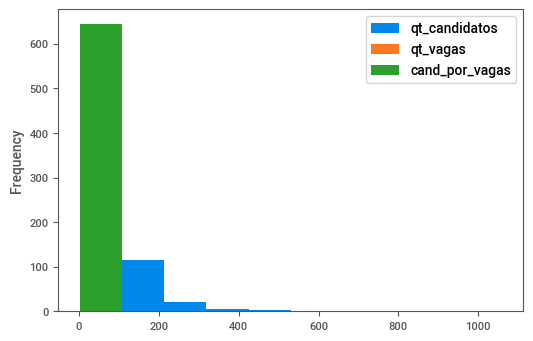

In [167]:
cv.plot(kind='hist')

In [168]:
gen = base.groupby(['NM_UE', 'DS_GENERO'], as_index=False).agg({'SQ_CANDIDATO':'count'}) # agrupa por UE e GENERO
gc = gen.pivot(index='NM_UE', columns='DS_GENERO', values='SQ_CANDIDATO') # transpõe coluna NM_UE para linhas
gc.columns = ['qt_feminino','qt_masculino'] # renomeia colunas
gc['perc_fem'] = gc['qt_feminino'] / (gc['qt_masculino'] + gc['qt_feminino']) # cria coluna com a % mulhere
gc.fillna(0, inplace=True)
gc.sort_values('perc_fem', ascending=False, inplace=True) # ordena lista pela relação recem criada
gc.head(3)

,qt_feminino,qt_masculino,perc_fem
NM_UE,,,
MESÓPOLIS,14.00,15.00,0.48
BURITIZAL,23.00,32.00,0.42
BARRA DO CHAPÉU,15.00,27.00,0.36


In [169]:
gc.tail(3)

,qt_feminino,qt_masculino,perc_fem
NM_UE,,,
ECHAPORÃ,2.00,39.00,0.05
LUCIANÓPOLIS,1.00,20.00,0.05
ITAJU,0.00,14.00,0.00


In [170]:
# verificando relação no município de São Paulo
gc.loc['SÃO PAULO']

qt_feminino    246.00
qt_masculino   814.00
perc_fem         0.23
Name: SÃO PAULO, Length: 3, dtype: float64

/home/finotti/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='NM_UE'>

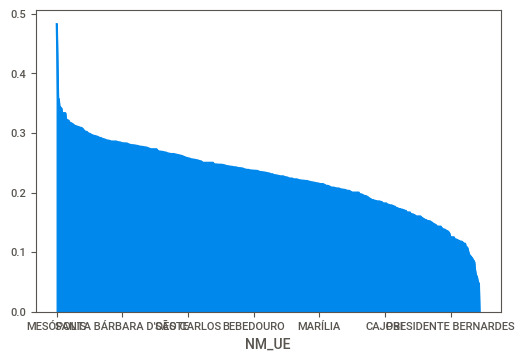

In [171]:
gc['perc_fem'].plot(kind = 'area')

In [172]:
gc.describe()

,qt_feminino,qt_masculino,perc_fem
count,645.00,645.00,645.00
mean,21.02,66.58,0.23
std,20.96,62.02,0.06
min,0.00,12.00,0.00
25%,8.00,33.00,0.19
50%,15.00,53.00,0.23
75%,26.00,75.00,0.27
max,246.00,814.00,0.48


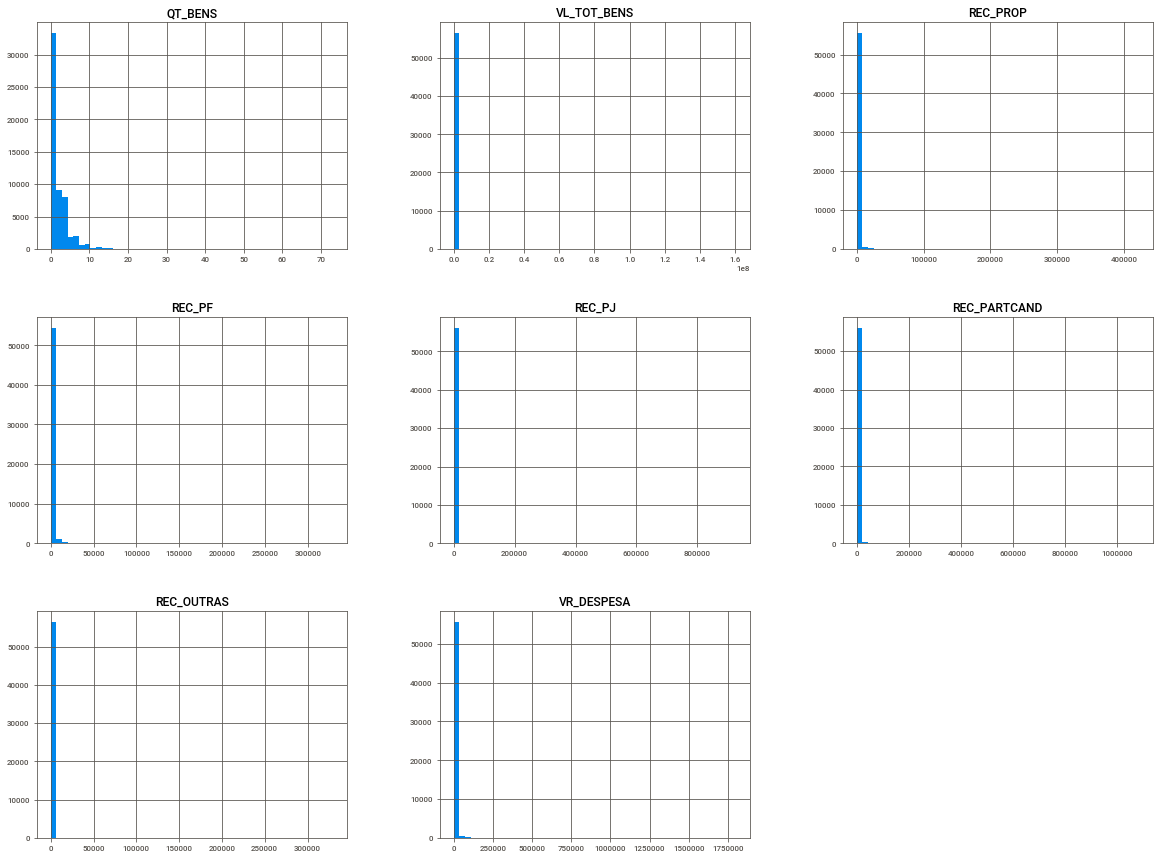

In [173]:
# Histogramas das preditoras numéricas
%matplotlib inline
import matplotlib.pyplot as plt
cols = ['QT_BENS','VL_TOT_BENS','REC_PROP','REC_PF','REC_PJ','REC_PARTCAND','REC_OUTRAS','VR_DESPESA']
base[cols].hist(bins=50, figsize=(20,15))
plt.show()

## Identificação e tratamento de Outliers

#### Observação sobre outliers
- As colunas de quantidade de bens, valores dos bens, despesas totais e receitas diversas são todas informadas pelo candidato, sem nenhuma verificação ou batimento do TSE.
- Como a grande maioria dos candidatos não informaram valores e os NaN foram convertidos em ZERO, tal fato acaba distorcendo a avaliação de outliers
- Olhando individualizadamente, cada uma destas colunas, percebe-se que não tem valores fora do normal
- consideramos que não há outliers significativos
- de toda forma, uma transformação das colunas pode ser interessante

<AxesSubplot:ylabel='VL_TOT_BENS'>

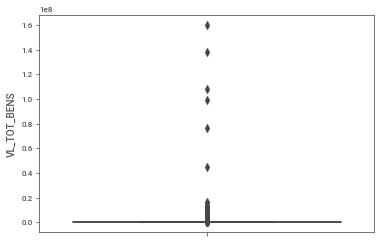

In [174]:
sns.boxplot(y= base['VL_TOT_BENS'])

<AxesSubplot:>

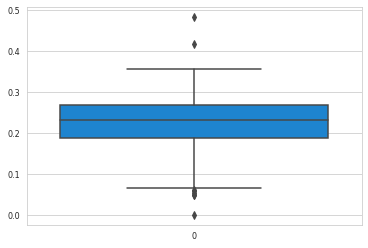

In [175]:
import seaborn as sns
#sns.set_style("whitegrid")
#sns.boxplot(x = 'day', y = 'total_bill', data = tips)
sns.boxplot(data = gc['perc_fem'])

<AxesSubplot:>

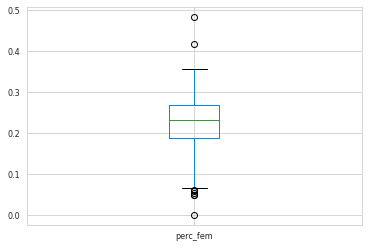

In [176]:
gc['perc_fem'].plot(kind='box')

In [177]:
# estaísticas sobre as colunas dos besn declarados
cols = ['QT_BENS','VL_TOT_BENS']
base[cols].describe()

,QT_BENS,VL_TOT_BENS
count,"56,500.00","56,500.00"
mean,1.93,"89,108.53"
std,3.01,"1,178,618.82"
min,0.00,0.00
25%,0.00,0.00
50%,1.00,"17,800.00"
75%,2.00,"72,850.10"
max,73.00,"160,302,000.00"


In [178]:
# relação dos 10 maiores patrimonios
base[cols].sort_values('VL_TOT_BENS',
        ascending = False).head(10)

,QT_BENS,VL_TOT_BENS
39721,9,"160,302,000.00"
18955,18,"138,571,000.00"
1833,6,"108,135,716.00"
42512,4,"99,208,050.00"
51675,43,"76,613,063.38"
52042,2,"45,045,000.00"
1830,1,"16,803,000.00"
35160,2,"15,867,654.76"
40199,16,"13,134,500.00"
33593,9,"12,951,654.32"


<AxesSubplot:ylabel='VL_TOT_BENS'>

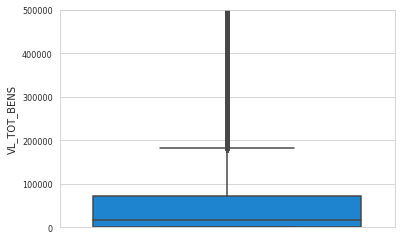

In [179]:
import matplotlib.pyplot as plt
plt.ylim(0, 500000)
sns.boxplot(y = base['VL_TOT_BENS'])

In [180]:
cols = ['REC_PROP','REC_PF','REC_PJ','REC_PARTCAND','REC_OUTRAS','VR_DESPESA']
base[cols].describe()

,REC_PROP,REC_PF,REC_PJ,REC_PARTCAND,REC_OUTRAS,VR_DESPESA
count,"56,500.00","56,500.00","56,500.00","56,500.00","56,500.00","56,500.00"
mean,909.83,"1,134.65",681.41,"1,216.23",56.75,"3,988.81"
std,"4,892.78","6,089.37","10,462.07","11,457.09","2,334.30","25,940.81"
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,32.98,0.00,190.00
50%,58.50,0.00,0.00,185.00,0.00,698.85
75%,567.00,340.00,0.00,676.15,0.00,"2,201.68"
max,"421,989.80","328,838.92","926,000.00","1,081,211.85","329,322.33","1,799,320.54"


<AxesSubplot:>

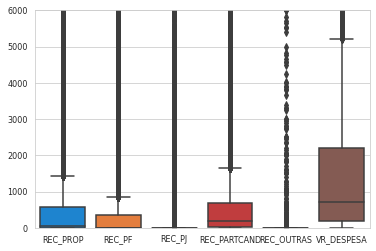

In [181]:
plt.ylim(0, 6000)
#sns.set(rc={'figure.figsize':(15,8.27)})
sns.boxplot(data = base[cols])

,REC_PROP,REC_PF,REC_PJ,REC_PARTCAND,REC_OUTRAS,VR_DESPESA
50757,0.00,0.00,0.00,"7,588.13",0.00,"7,585.13"
50758,138.00,0.00,0.00,0.00,0.00,0.00
50759,"60,344.35","69,500.00","20,000.00","225,000.00","14,600.00","389,444.35"
50760,0.00,58.50,0.00,"1,487.40",0.00,"1,545.90"
50761,0.00,"29,857.00","462,790.27","303,463.12","88,847.80","886,108.19"
...,...,...,...,...,...,...
51960,"3,240.57","1,230.00",0.00,"1,775.00",0.00,"6,245.50"
51961,"30,850.00","4,300.00","31,304.50","280,647.78",0.00,"347,102.28"
51962,350.00,"7,703.10","1,000.00","4,715.36",0.00,"13,745.46"
51963,"21,500.00","9,130.00",0.00,"5,340.12",0.00,"35,970.08"


<AxesSubplot:>

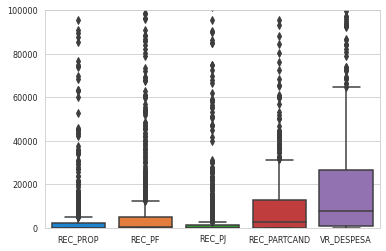

In [182]:
cols = ['REC_PROP','REC_PF','REC_PJ','REC_PARTCAND','VR_DESPESA']
cols2 = ['VL_TOT_BENS']
sao = base.query('NM_UE == "SÃO PAULO"')[cols]
plt.ylim(0, 100000)
sns.boxplot(data = sao)

In [183]:
base.columns

Index(['SQ_CANDIDATO', 'NM_UE', 'SG_PARTIDO', 'DS_OCUPACAO',
       'IDADE_DATA_POSSE', 'DS_GENERO', 'DS_GRAU_INSTRUCAO', 'DS_ESTADO_CIVIL',
       'DS_NACIONALIDADE', 'SG_UF_NASCIMENTO', 'CD_MUNICIPIO_NASCIMENTO',
       'TP_AGREMIACAO', 'COMP_COLIGACAO', 'QT_PART_COL', 'QT_BENS',
       'VL_TOT_BENS', 'REC_PROP', 'REC_PF', 'REC_PJ', 'REC_PARTCAND',
       'REC_OUTRAS', 'VR_DESPESA', 'VOTOS_PART_ELEC_ANT',
       'QT_ELEITOS_ELEC_ANT', 'QT_VAGAS', 'DS_SIT_TOT_TURNO', 'RESULTADO'],
      dtype='object')

In [184]:
cols = ['SG_PARTIDO','NM_UE','VOTOS_PART_ELEC_ANT','QT_ELEITOS_ELEC_ANT']
df = base[cols].drop_duplicates()
#plt.ylim(0, 100000)
#sns.boxplot(data = df)
df.query('NM_UE == "ITAJU"')

,SG_PARTIDO,NM_UE,VOTOS_PART_ELEC_ANT,QT_ELEITOS_ELEC_ANT
22843,PV,ITAJU,119,1
22844,PPS,ITAJU,367,2
22847,PSDB,ITAJU,772,3
22849,DEM,ITAJU,185,1
22852,PMDB,ITAJU,234,1
22853,PSB,ITAJU,63,0


In [185]:
df.describe()

,VOTOS_PART_ELEC_ANT,QT_ELEITOS_ELEC_ANT
count,"8,026.00","8,026.00"
mean,"2,248.22",0.73
std,"18,425.20",1.05
min,0.00,0.00
25%,85.00,0.00
50%,480.00,0.00
75%,"1,418.00",1.00
max,"1,117,256.00",13.00


### 5 - Modelos de Machine Learning
- excluir coluna que explica target (DS_SIT_TOT_TURNO)
- excluir coluna qtd vagas


In [186]:
base.drop(columns=['DS_SIT_TOT_TURNO','QT_VAGAS'], inplace=True)

In [187]:
basesp = base.query('NM_UE == "SÃO PAULO"') # base reduzida, apenas municipio de sao paulo

### 5.1 - Funções de uso geral

#### 5.1.1 Função para plotar a Confusion Matrix
* Extraído de [Confusion Matrix Visualization](https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea)

In [3]:
def mostra_confusion_matrix(cf, 
                            group_names = None, 
                            categories = 'auto', 
                            count = True, 
                            percent = True, 
                            cbar = True, 
                            xyticks = False, 
                            xyplotlabels = True, 
                            sum_stats = True, 
                            figsize = (8, 8), 
                            cmap = 'Blues'):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
    '''

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

#### 5.1.2 Função para Cross Validation

In [4]:
def funcao_cross_val_score(modelo, X_treinamento, y_treinamento, CV):
    # versão com sklearn.model_selection.cross_validate:
    #a_scores_CV = cross_validate(modelo, X_treinamento, y_treinamento, cv = CV, scoring = metodo)
    #print(f'Média das Acurácias calculadas pelo CV....: {100*round(a_scores_CV.mean(),4)}')
    #print(f'std médio das Acurácias calculadas pelo CV: {100*round(a_scores_CV.std(),4)}')
    #return a_scores_CV

    #versão com cross_val_score::
    a_scores_CV = cross_val_score(modelo, X_treinamento, y_treinamento, cv = CV)
    print(f'Média das Acurácias calculadas pelo CV....: {100*round(a_scores_CV.mean(),4)}')
    print(f'std médio das Acurácias calculadas pelo CV: {100*round(a_scores_CV.std(),4)}')
    return a_scores_CV

#### 5.1.3 Função para o GridSearchCV

In [5]:
def GridSearchOptimizer(modelo, ml_Opt, d_Parametros, X_treinamento, y_treinamento, X_teste, y_teste, i_CV, l_colunas):
    ml_GridSearchCV = GridSearchCV(modelo, d_Parametros, cv = i_CV, n_jobs = -1, verbose= 10, scoring = 'accuracy')
    start = time()
    ml_GridSearchCV.fit(X_treinamento, y_treinamento)
    tempo_elapsed = time()-start
    #print(f"\nGridSearchCV levou {tempo_elapsed:.2f} segundos.")

    # Parâmetros que otimizam a classificação:
    print(f'\nParametros otimizados: {ml_GridSearchCV.best_params_}')
    
    if ml_Opt == 'ml_DT2':
        print(f'\nDecisionTreeClassifier *********************************************************************************************************')
        ml_Opt = DecisionTreeClassifier(criterion= ml_GridSearchCV.best_params_['criterion'], 
                                        max_depth= ml_GridSearchCV.best_params_['max_depth'],
                                        max_leaf_nodes= ml_GridSearchCV.best_params_['max_leaf_nodes'],
                                        min_samples_split= ml_GridSearchCV.best_params_['min_samples_leaf'],
                                        min_samples_leaf= ml_GridSearchCV.best_params_['min_samples_split'], 
                                        random_state= i_Seed)
        
    elif ml_Opt == 'ml_RF2':
        print(f'\nRandomForestClassifier *********************************************************************************************************')
        ml_Opt = RandomForestClassifier(bootstrap= ml_GridSearchCV.best_params_['bootstrap'], 
                                        max_depth= ml_GridSearchCV.best_params_['max_depth'],
                                        max_features= ml_GridSearchCV.best_params_['max_features'],
                                        min_samples_leaf= ml_GridSearchCV.best_params_['min_samples_leaf'],
                                        min_samples_split= ml_GridSearchCV.best_params_['min_samples_split'],
                                        n_estimators= ml_GridSearchCV.best_params_['n_estimators'],
                                        random_state= i_Seed)
        
    elif ml_Opt == 'ml_AB2':
        print(f'\nAdaBoostClassifier *********************************************************************************************************')
        ml_Opt = AdaBoostClassifier(algorithm='SAMME.R', 
                                    base_estimator=RandomForestClassifier(bootstrap = False, 
                                                                          max_depth = 10, 
                                                                          max_features = 'auto', 
                                                                          min_samples_leaf = 1, 
                                                                          min_samples_split = 2, 
                                                                          n_estimators = 400), 
                                    learning_rate = ml_GridSearchCV.best_params_['learning_rate'], 
                                    n_estimators = ml_GridSearchCV.best_params_['n_estimators'], 
                                    random_state = i_Seed)
        
    elif ml_Opt == 'ml_GB2':
        print(f'\nGradientBoostingClassifier *********************************************************************************************************')
        ml_Opt = GradientBoostingClassifier(learning_rate = ml_GridSearchCV.best_params_['learning_rate'], 
                                            n_estimators = ml_GridSearchCV.best_params_['n_estimators'], 
                                            max_depth = ml_GridSearchCV.best_params_['max_depth'], 
                                            min_samples_split = ml_GridSearchCV.best_params_['min_samples_split'], 
                                            min_samples_leaf = ml_GridSearchCV.best_params_['min_samples_leaf'], 
                                            max_features = ml_GridSearchCV.best_params_['max_features'])
        
    elif ml_Opt == 'ml_XGB2':
        print(f'\nXGBoostingClassifier *********************************************************************************************************')
        ml_Opt = XGBoostingClassifier(learning_rate= ml_GridSearchCV.best_params_['learning_rate'], 
                                      max_depth= ml_GridSearchCV.best_params_['max_depth'], 
                                      colsample_bytree= ml_GridSearchCV.best_params_['colsample_bytree'], 
                                      subsample= ml_GridSearchCV.best_params_['subsample'], 
                                      gamma= ml_GridSearchCV.best_params_['gamma'], 
                                      min_child_weight= ml_GridSearchCV.best_params_['min_child_weight'])
        
    # Treina novamente usando os parametros otimizados...
    ml_Opt.fit(X_treinamento, y_treinamento)

    # Cross-Validation com 10 folds
    print(f'\n********* CROSS-VALIDATION ***********')
    a_scores_CV = funcao_cross_val_score(ml_Opt, X_treinamento, y_treinamento, i_CV)

    # Faz predições com os parametros otimizados...
    y_pred = ml_Opt.predict(X_teste)
  
    # Importância das COLUNAS
    print(f'\n********* IMPORTÂNCIA DAS COLUNAS ***********')
    df_importancia_variaveis = pd.DataFrame(zip(l_colunas, ml_Opt.feature_importances_), columns= ['coluna', 'importancia'])
    df_importancia_variaveis = df_importancia_variaveis.sort_values(by= ['importancia'], ascending=False)
    print(df_importancia_variaveis)

    # Matriz de Confusão
    print(f'\n********* CONFUSION MATRIX - PARAMETER TUNNING ***********')
    cf_matrix = confusion_matrix(y_teste, y_pred)
    cf_labels = ['True_Negative', 'False_Positive', 'False_Negative', 'True_Positive']
    cf_categories = ['Zero', 'One']
    mostra_confusion_matrix(cf_matrix, group_names = cf_labels, categories = cf_categories)

    return ml_Opt, ml_GridSearchCV.best_params_

#### 5.1.4 Função para selecionar colunas relevantes

In [6]:
from sklearn.feature_selection import SelectFromModel

def seleciona_colunas_relevantes(modelo, X_treinamento, X_teste, threshold = 0.05):
    # Cria um seletor para selecionar as COLUNAS com importância > threshold
    sfm = SelectFromModel(modelo, threshold)
    
    # Treina o seletor
    sfm.fit(X_treinamento, y_treinamento)

    # Mostra o indice das COLUNAS mais importantes
    print(f'\n********** COLUNAS Relevantes ******')
    print(sfm.get_support(indices=True))

    # Seleciona somente as COLUNAS relevantes
    X_treinamento_I = sfm.transform(X_treinamento)
    X_teste_I = sfm.transform(X_teste)
    return X_treinamento_I, X_teste_I   

#### 5.1.5 Função para calcular a importância das colunas/variáveis/atributos
* Source: [Plotting Feature Importances](https://www.kaggle.com/grfiv4/plotting-feature-importances)

In [7]:
def mostra_feature_importances(clf, X_treinamento, y_treinamento=None, 
                             top_n=10, figsize=(8,8), print_table=False, title="Feature Importances"):
    '''
    plot feature importances of a tree-based sklearn estimator
    
    Note: X_treinamento and y_treinamento are pandas DataFrames
    
    Note: Scikit-plot is a lovely package but I sometimes have issues
              1. flexibility/extendibility
              2. complicated models/datasets
          But for many situations Scikit-plot is the way to go
          see https://scikit-plot.readthedocs.io/en/latest/Quickstart.html
    
    Parameters
    ----------
        clf         (sklearn estimator) if not fitted, this routine will fit it
        
        X_treinamento     (pandas DataFrame)
        
        y_treinamento     (pandas DataFrame)  optional
                                        required only if clf has not already been fitted 
        
        top_n       (int)               Plot the top_n most-important features
                                        Default: 10
                                        
        figsize     ((int,int))         The physical size of the plot
                                        Default: (8,8)
        
        print_table (boolean)           If True, print out the table of feature importances
                                        Default: False
        
    Returns
    -------
        the pandas dataframe with the features and their importance
        
    Author
    ------
        George Fisher
    '''
    
    __name__ = "mostra_feature_importances"
    
    import pandas as pd
    import numpy  as np
    import matplotlib.pyplot as plt
    
    from xgboost.core     import XGBoostError
    from lightgbm.sklearn import LightGBMError
    
    try: 
        if not hasattr(clf, 'feature_importances_'):
            clf.fit(X_treinamento.values, y_treinamento.values.ravel())

            if not hasattr(clf, 'feature_importances_'):
                raise AttributeError("{} does not have feature_importances_ attribute".
                                    format(clf.__class__.__name__))
                
    except (XGBoostError, LightGBMError, ValueError):
        clf.fit(X_treinamento.values, y_treinamento.values.ravel())
            
    feat_imp = pd.DataFrame({'importance':clf.feature_importances_})    
    feat_imp['feature'] = X_treinamento.columns
    feat_imp.sort_values(by ='importance', ascending = False, inplace = True)
    feat_imp = feat_imp.iloc[:top_n]
    
    feat_imp.sort_values(by='importance', inplace = True)
    feat_imp = feat_imp.set_index('feature', drop = True)
    feat_imp.plot.barh(title=title, figsize=figsize)
    plt.xlabel('Feature Importance Score')
    plt.show()
    
    if print_table:
        from IPython.display import display
        print("Top {} features in descending order of importance".format(top_n))
        display(feat_imp.sort_values(by = 'importance', ascending = False))
        
    return feat_imp

## 5.2 - Prepara dataset
- nossa base de treinamento e testes será o df base
- candidatos a vereador de todo o estado de São Paulo, ano 2008

In [193]:
# base de treino/testes dos modelos
baseml = base.copy()

In [194]:
# colocando SQ_CANDIDATO como index do dataframe
baseml.set_index('SQ_CANDIDATO', inplace=True)

In [25]:
# verificando o balanceamento de nosso dataset:
def resumo_base_treino(train,alvo):
    n_predi = train.shape[1] -1 
    observ = train.shape[0]
    a0,a1 = alvo.value_counts()
    print(f'*** Resumo Amostra de treinamento ***')
    print(f'{observ} observações na amostra de treinamento')
    print(f'{n_predi} colunas preditoras')
    print(f'{int(observ / n_predi)} observações por coluna preditora')
    print(f'{round(a0/(a0+a1),2)} : {round(a1/(a0+a1),2)} - balanceamento da coluna target')

In [196]:
resumo_base_treino(baseml, baseml.RESULTADO)

*** Resumo Amostra de treinamento ***
56500 observações na amostra de treinamento
23 colunas preditoras
2456 observações por coluna preditora
0.89 : 0.11 - balanceamento da coluna target


## Entendendo os dados

### Preditoras:

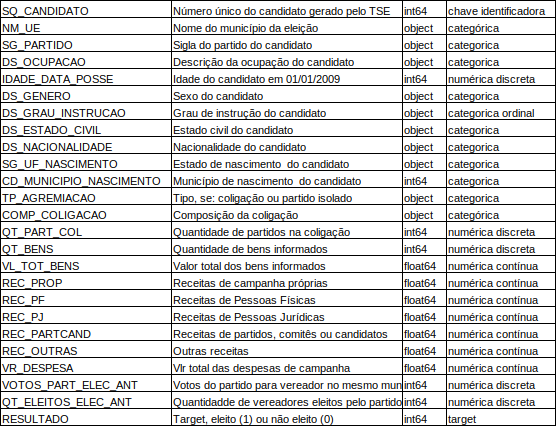




In [197]:
# tipos das colunas (features)
baseml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56500 entries, 27238 to 57617
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   NM_UE                    56500 non-null  object 
 1   SG_PARTIDO               56500 non-null  object 
 2   DS_OCUPACAO              56500 non-null  object 
 3   IDADE_DATA_POSSE         56500 non-null  int64  
 4   DS_GENERO                56500 non-null  object 
 5   DS_GRAU_INSTRUCAO        56500 non-null  object 
 6   DS_ESTADO_CIVIL          56500 non-null  object 
 7   DS_NACIONALIDADE         56500 non-null  object 
 8   SG_UF_NASCIMENTO         56500 non-null  object 
 9   CD_MUNICIPIO_NASCIMENTO  56500 non-null  object 
 10  TP_AGREMIACAO            56500 non-null  object 
 11  COMP_COLIGACAO           56500 non-null  object 
 12  QT_PART_COL              56500 non-null  int64  
 13  QT_BENS                  56500 non-null  int64  
 14  VL_TOT_BENS       

In [198]:
# quantidade de valores únicos por coluna
baseml.nunique()

NM_UE                        645
SG_PARTIDO                    27
DS_OCUPACAO                  227
IDADE_DATA_POSSE              72
DS_GENERO                      2
DS_GRAU_INSTRUCAO              8
DS_ESTADO_CIVIL                5
DS_NACIONALIDADE               3
SG_UF_NASCIMENTO              28
CD_MUNICIPIO_NASCIMENTO     2974
TP_AGREMIACAO                  2
COMP_COLIGACAO              1381
QT_PART_COL                    9
QT_BENS                       53
VL_TOT_BENS                10624
REC_PROP                   10435
REC_PF                      6788
REC_PJ                      2653
REC_PARTCAND               13909
REC_OUTRAS                   320
VR_DESPESA                 32863
VOTOS_PART_ELEC_ANT         2967
QT_ELEITOS_ELEC_ANT           10
RESULTADO                      2
Length: 24, dtype: int64

## Primeiras observações


### Outras observações sobre tipo das preditoras

- poderiam/precisam ser classificadas como categóricas:
    - NM_UE                       244
    - SG_PARTIDO                  20
    - DS_OCUPACAO                 50
    - DS_GENERO                    2
    - DS_GRAU_INSTRUCAO            7
    - DS_ESTADO_CIVIL              5
    - DS_NACIONALIDADE             1
    - SG_UF_NASCIMENTO            13
    - CD_MUNICIPIO_NASCIMENTO     52
    - TP_AGREMIACAO                2

### 5.2.1 Fazendo alterações / adequações nos tipos das preditoras

In [199]:
# criando copia da base para trabalharmos
df_temp = baseml.copy()

In [200]:
# preditoras categoricas/str que precisam ser transformadas para integer
list(df_temp.select_dtypes(['object','category']).columns)

['NM_UE',
 'SG_PARTIDO',
 'DS_OCUPACAO',
 'DS_GENERO',
 'DS_GRAU_INSTRUCAO',
 'DS_ESTADO_CIVIL',
 'DS_NACIONALIDADE',
 'SG_UF_NASCIMENTO',
 'CD_MUNICIPIO_NASCIMENTO',
 'TP_AGREMIACAO',
 'COMP_COLIGACAO']

In [201]:
# usando pre-processing do scikit learn para criar colunas numéricas com códigos, para substituir as categóricas
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df_temp['ue_le'] = le.fit_transform(df_temp.NM_UE)
df_temp['partido_le'] = le.fit_transform(df_temp.SG_PARTIDO)
df_temp['ocup_le'] = le.fit_transform(df_temp.DS_OCUPACAO)
df_temp['genero_le'] = le.fit_transform(df_temp.DS_GENERO)
df_temp['instrucao_le'] = le.fit_transform(df_temp.DS_GRAU_INSTRUCAO)
df_temp['estcivil_le'] = le.fit_transform(df_temp.DS_ESTADO_CIVIL)
df_temp['nac_le'] = le.fit_transform(df_temp.DS_NACIONALIDADE)
df_temp['uf_le'] = le.fit_transform(df_temp.SG_UF_NASCIMENTO)
df_temp['mn_le'] = le.fit_transform(df_temp.CD_MUNICIPIO_NASCIMENTO)
df_temp['agre_le'] = le.fit_transform(df_temp.TP_AGREMIACAO)
df_temp['comp_le'] = le.fit_transform(df_temp.COMP_COLIGACAO)

In [202]:
df_temp.columns

Index(['NM_UE', 'SG_PARTIDO', 'DS_OCUPACAO', 'IDADE_DATA_POSSE', 'DS_GENERO',
       'DS_GRAU_INSTRUCAO', 'DS_ESTADO_CIVIL', 'DS_NACIONALIDADE',
       'SG_UF_NASCIMENTO', 'CD_MUNICIPIO_NASCIMENTO', 'TP_AGREMIACAO',
       'COMP_COLIGACAO', 'QT_PART_COL', 'QT_BENS', 'VL_TOT_BENS', 'REC_PROP',
       'REC_PF', 'REC_PJ', 'REC_PARTCAND', 'REC_OUTRAS', 'VR_DESPESA',
       'VOTOS_PART_ELEC_ANT', 'QT_ELEITOS_ELEC_ANT', 'RESULTADO', 'ue_le',
       'partido_le', 'ocup_le', 'genero_le', 'instrucao_le', 'estcivil_le',
       'nac_le', 'uf_le', 'mn_le', 'agre_le', 'comp_le'],
      dtype='object')

In [203]:
ncls = ['ue_le','partido_le', 'ocup_le', 'IDADE_DATA_POSSE', 'genero_le',
       'instrucao_le', 'estcivil_le', 'nac_le', 'uf_le', 'mn_le', 'agre_le',
       'comp_le','QT_PART_COL', 'QT_BENS', 'VL_TOT_BENS', 'VR_DESPESA',
       'REC_PROP', 'REC_PF','REC_PJ', 'REC_PARTCAND', 'REC_OUTRAS',
       'VOTOS_PART_ELEC_ANT', 'QT_ELEITOS_ELEC_ANT', 'RESULTADO']

df_temp_b = df_temp[ncls].copy()

In [204]:
df_temp.head(2)

,NM_UE,SG_PARTIDO,DS_OCUPACAO,IDADE_DATA_POSSE,DS_GENERO,DS_GRAU_INSTRUCAO,DS_ESTADO_CIVIL,DS_NACIONALIDADE,SG_UF_NASCIMENTO,CD_MUNICIPIO_NASCIMENTO,TP_AGREMIACAO,COMP_COLIGACAO,QT_PART_COL,QT_BENS,VL_TOT_BENS,REC_PROP,REC_PF,REC_PJ,REC_PARTCAND,REC_OUTRAS,VR_DESPESA,VOTOS_PART_ELEC_ANT,QT_ELEITOS_ELEC_ANT,RESULTADO,ue_le,partido_le,ocup_le,genero_le,instrucao_le,estcivil_le,nac_le,uf_le,mn_le,agre_le,comp_le
SQ_CANDIDATO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
27238,ADAMANTINA,PR,SERVIDOR PÚBLICO MUNICIPAL,50,MASCULINO,ENSINO FUNDAMENTAL COMPLETO,CASADO(A),BRASILEIRA NATA,SP,66214,COLIGACAO,22-PR / 15-PMDB,2,2,"43,700.00",112.60,0.00,180.00,0.00,0.00,292.60,0,0,0,0,10,180,1,1,0,1,25,2000,0,742
18841,ADAMANTINA,PR,SERVIDOR PÚBLICO ESTADUAL,36,MASCULINO,ENSINO MÉDIO COMPLETO,CASADO(A),BRASILEIRA NATA,SP,61018,COLIGACAO,22-PR / 15-PMDB,2,3,"80,000.00",112.60,0.00,180.00,0.00,0.00,292.60,0,0,0,0,10,178,1,3,0,1,25,1674,0,742


In [205]:
df_temp_b.head(2)

,ue_le,partido_le,ocup_le,IDADE_DATA_POSSE,genero_le,instrucao_le,estcivil_le,nac_le,uf_le,mn_le,agre_le,comp_le,QT_PART_COL,QT_BENS,VL_TOT_BENS,VR_DESPESA,REC_PROP,REC_PF,REC_PJ,REC_PARTCAND,REC_OUTRAS,VOTOS_PART_ELEC_ANT,QT_ELEITOS_ELEC_ANT,RESULTADO
SQ_CANDIDATO,,,,,,,,,,,,,,,,,,,,,,,,
27238,0,10,180,50,1,1,0,1,25,2000,0,742,2,2,"43,700.00",292.60,112.60,0.00,180.00,0.00,0.00,0,0,0
18841,0,10,178,36,1,3,0,1,25,1674,0,742,2,3,"80,000.00",292.60,112.60,0.00,180.00,0.00,0.00,0,0,0


In [239]:
# armazena em csv para proximas etapas
df_temp_b.to_csv('base_para_ml.csv')

In [8]:
# lê csv para da aetapa anterior
df_temp_b = pd.read_csv('base_para_ml.csv', index_col=0)

In [9]:
df_temp_b.describe()

,ue_le,partido_le,ocup_le,IDADE_DATA_POSSE,genero_le,instrucao_le,estcivil_le,nac_le,uf_le,mn_le,agre_le,comp_le,QT_PART_COL,QT_BENS,VL_TOT_BENS,VR_DESPESA,REC_PROP,REC_PF,REC_PJ,REC_PARTCAND,REC_OUTRAS,VOTOS_PART_ELEC_ANT,QT_ELEITOS_ELEC_ANT,RESULTADO
count,"56,500.00","56,500.00","56,500.00","56,500.00","56,500.00","56,500.00","56,500.00","56,500.00","56,500.00","56,500.00","56,500.00","56,500.00","56,500.00","56,500.00","56,500.00","56,500.00","56,500.00","56,500.00","56,500.00","56,500.00","56,500.00","56,500.00","56,500.00","56,500.00"
mean,326.25,13.11,111.66,44.88,0.76,3.45,0.95,1.00,22.25,"1,894.91",0.19,564.92,2.30,1.93,"89,108.53","3,988.81",909.83,"1,134.65",681.41,"1,216.23",56.75,"8,284.05",1.02,0.11
std,188.09,7.77,66.88,10.87,0.43,1.89,1.35,0.07,5.96,513.00,0.39,453.31,1.03,3.01,"1,178,618.82","25,940.81","4,892.78","6,089.37","10,462.07","11,457.09","2,334.30","53,645.06",1.37,0.31
min,0.00,0.00,0.00,18.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,164.00,6.00,46.00,37.00,1.00,2.00,0.00,1.00,25.00,"1,803.00",0.00,123.00,2.00,0.00,0.00,190.00,0.00,0.00,0.00,32.98,0.00,260.00,0.00,0.00
50%,320.00,14.00,131.00,45.00,1.00,3.00,0.00,1.00,25.00,"2,014.00",0.00,510.00,2.00,1.00,"17,800.00",698.85,58.50,0.00,0.00,185.00,0.00,966.00,1.00,0.00
75%,502.00,21.00,160.00,52.00,1.00,6.00,3.00,1.00,25.00,"2,227.00",0.00,960.00,3.00,2.00,"72,850.10","2,201.68",567.00,340.00,0.00,676.15,0.00,"3,435.25",2.00,0.00
max,644.00,26.00,226.00,95.00,1.00,7.00,4.00,2.00,27.00,"2,973.00",1.00,"1,380.00",10.00,73.00,"160,302,000.00","1,799,320.54","421,989.80","328,838.92","926,000.00","1,081,211.85","329,322.33","1,117,256.00",13.00,1.00


### Correlação entre as preditoras

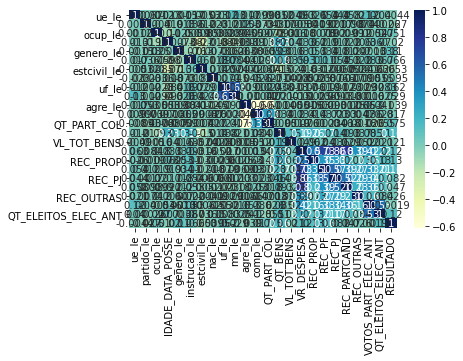

<AxesSubplot:>

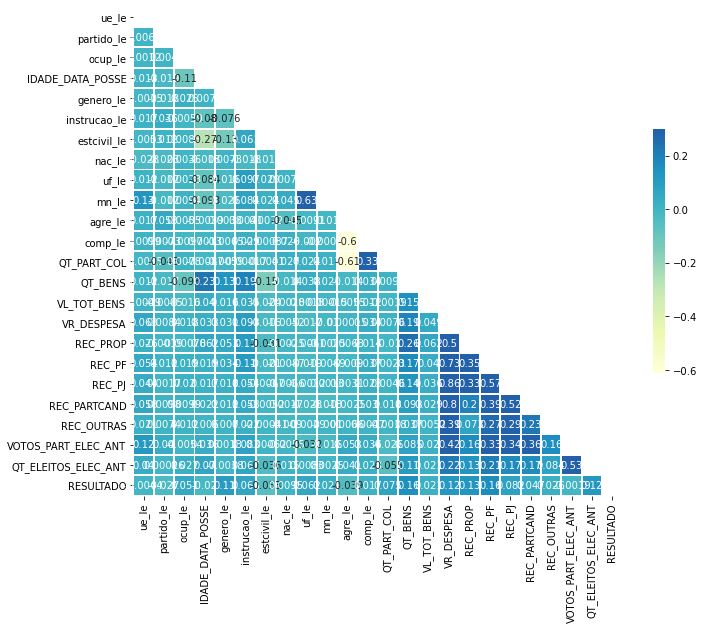

In [10]:
sns.heatmap(df_temp_b.corr(), annot=True, cmap="YlGnBu")
plt.show()

import seaborn as sns
from string import ascii_letters
import matplotlib.pyplot as plt

d = df_temp_b

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(230, 20, as_cmap=True)
cmap="YlGnBu"

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.9, cbar_kws={"shrink": .5}, annot=True)

## 5.3 Criação dos modelos de Machine Learning

In [11]:
from sklearn.metrics import accuracy_score # para medir a acurácia do modelo preditivo
from sklearn.model_selection import train_test_split
#from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix # para plotar a confusion matrix

from sklearn.model_selection import GridSearchCV # para otimizar os parâmetros dos modelos preditivos
from sklearn.model_selection import cross_val_score # Para o CV (Cross-Validation)
from sklearn.model_selection import cross_validate

from time import time
from operator import itemgetter
from scipy.stats import randint

from sklearn.tree import export_graphviz
#from sklearn.externals.six import StringIO  
from IPython.display import Image  
#import pydotplus

#np.set_printoptions(suppress=True)

In [37]:
df = df_temp_b.copy()

In [38]:
# Separar preditoras do target
df_y = df[['RESULTADO']].copy()
df_X = df.drop(columns='RESULTADO')

In [39]:
# separar a amostra de treinamento
i_size = 0.3
i_Seed = 2021

from sklearn.model_selection import train_test_split
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(df_X, df_y, test_size = i_size, random_state = i_Seed)

In [40]:
print(f'X treino: {X_treinamento.shape}')
print(f'y treino: {y_treinamento.shape}')
print(f'X teste : {X_teste.shape}')
print(f'y teste : {y_teste.shape}')

X treino: (39550, 23)
y treino: (39550, 1)
X teste : (16950, 23)
y teste : (16950, 1)


## 5.3.1 Modelo 1: Decision Tree Classifier para base de todo o estado de São Paulo
- Decision Tree com parametros padrão

In [41]:
from sklearn.tree import DecisionTreeClassifier # Library para Decision Tree (Classificação)
from sklearn import tree

# Instancia (configuração do Decision Trees) objeto com os parâmetros padrão:
ml_DT = DecisionTreeClassifier()

In [42]:
# Treina o modelo
ml_DT.fit(X_treinamento, y_treinamento)

DecisionTreeClassifier()

In [43]:
# Acuracias modelo
print(f'Acurácia base treino: {ml_DT.score(X_treinamento, y_treinamento)}')
print(f'Acurácia base teste : {ml_DT.score(X_teste, y_teste)}')

Acurácia base treino: 1.0
Acurácia base teste : 0.8368731563421828


### Observações:
- pela comparação das acurácias, vemos um modelo muito bom com a base de treino e mediano com a base teste
- indicativo de overfitting

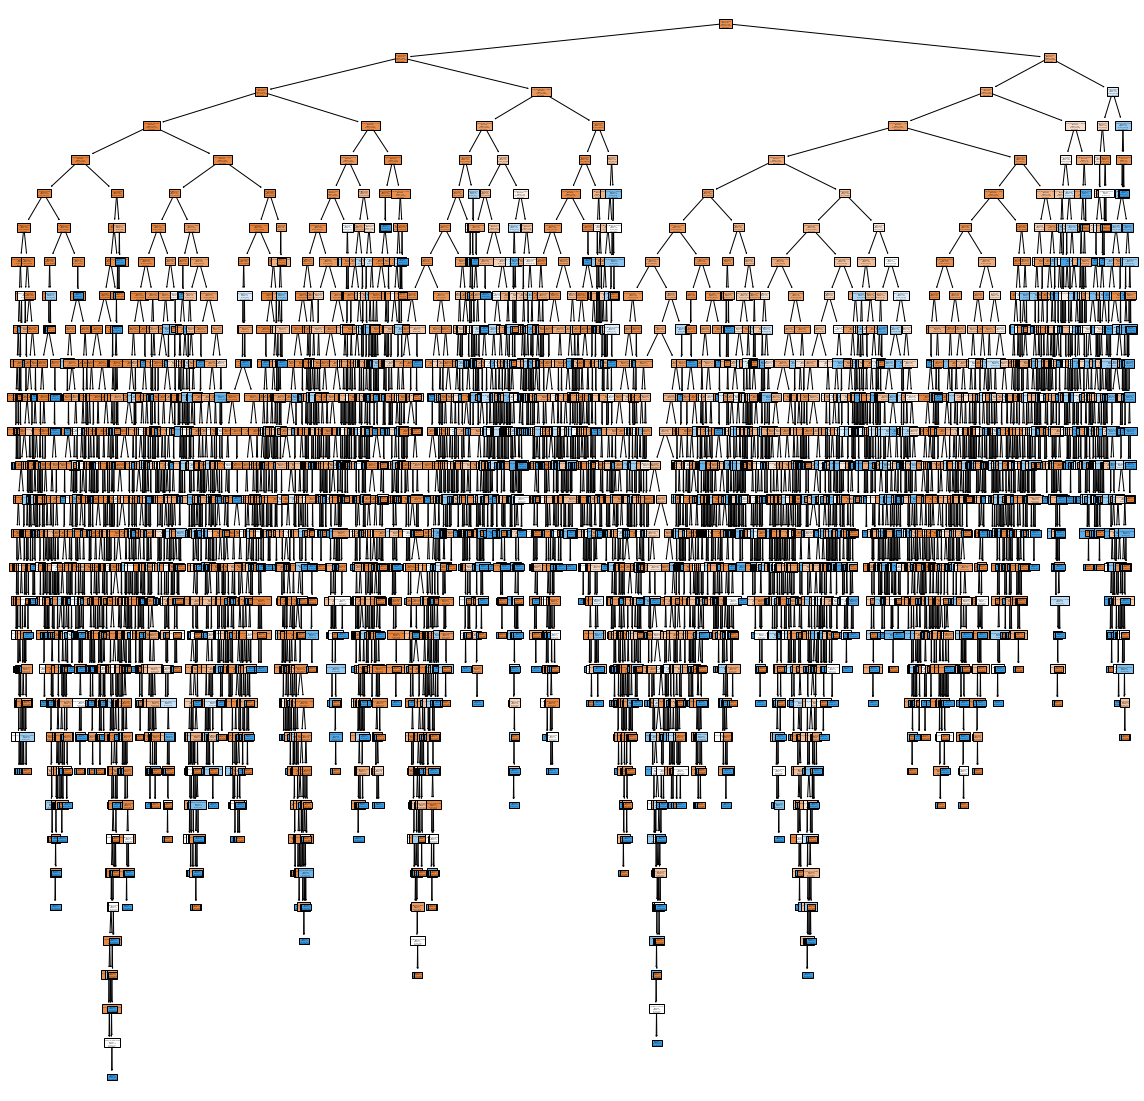

In [44]:
plt.figure(figsize=(20,20))
features = df.columns
classes = ['Eleito','Não eleito']
tree.plot_tree(ml_DT,feature_names=features,class_names=classes,filled=True)
plt.show()

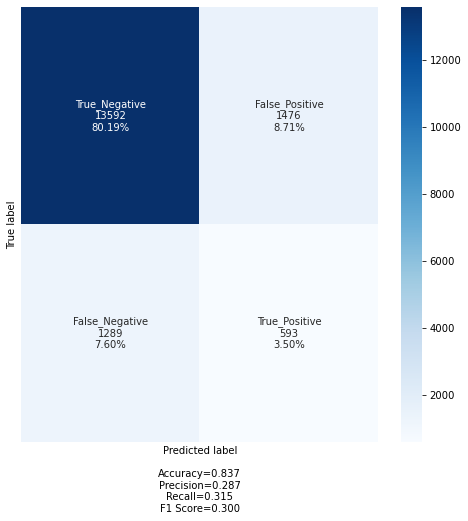

In [45]:
from sklearn.metrics import confusion_matrix
y_pred = ml_DT.predict(X_teste)
cf_matrix = confusion_matrix(y_teste, y_pred)
cf_labels = ['True_Negative', 'False_Positive', 'False_Negative', 'True_Positive']
cf_categories = ['Zero', 'One']
mostra_confusion_matrix(cf_matrix, group_names= cf_labels, categories= cf_categories)

In [46]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print(classification_report(y_teste, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.90      0.91     15068
           1       0.29      0.32      0.30      1882

    accuracy                           0.84     16950
   macro avg       0.60      0.61      0.60     16950
weighted avg       0.84      0.84      0.84     16950



In [47]:
ml_DT.__dict__

{'criterion': 'gini',
 'splitter': 'best',
 'max_depth': None,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.0,
 'max_features': None,
 'max_leaf_nodes': None,
 'random_state': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'class_weight': None,
 'presort': 'deprecated',
 'ccp_alpha': 0.0,
 'n_features_in_': 23,
 'n_features_': 23,
 'n_outputs_': 1,
 'classes_': array([0, 1]),
 'n_classes_': 2,
 'max_features_': 23,
 'tree_': <sklearn.tree._tree.Tree at 0x7fe8203e76c0>}

### 5.3.1.2 Ajustando Parametros (Parameter tunning)

### Vários Hyperparametros, com Cross Validation (k=10)

In [48]:
# Dicionário com hiperparâmetros para o parameter tunning. Ao todo serão ajustados 2X15X5X5X7 = 5.250 modelos. 
# Contando com 10 folds no Cross-Validation, então são 52.500 modelos.

d_hiperparametros_DT = {"criterion": ["gini", "entropy"], 
                   "min_samples_split": [2, 5, 10, 30, 50, 70, 90, 120, 150, 180, 210, 240, 270, 350, 400], 
                   "max_depth": [None, 2, 5, 9, 15], 
                   "min_samples_leaf": [20, 40, 60, 80, 100], 
                   "max_leaf_nodes": [None, 2, 3, 4, 5, 10, 15]}

### Modelo 2: após grid search, com escolha dos melhores parametros

Fitting 10 folds for each of 5250 candidates, totalling 52500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

[Parallel(n_jobs=-1)]: Done 17116 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 17386 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 17656 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 17930 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 18204 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 18482 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 18760 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 19042 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 19324 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 19610 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 19896 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 20186 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 20476 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 20770 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0001s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]


Parametros otimizados: {'criterion': 'entropy', 'max_depth': 9, 'max_leaf_nodes': None, 'min_samples_leaf': 40, 'min_samples_split': 180}

DecisionTreeClassifier *********************************************************************************************************

********* CROSS-VALIDATION ***********
Média das Acurácias calculadas pelo CV....: 89.13
std médio das Acurácias calculadas pelo CV: 0.3

********* IMPORTÂNCIA DAS COLUNAS ***********
                 coluna  importancia
16             REC_PROP         0.28
22  QT_ELEITOS_ELEC_ANT         0.15
21  VOTOS_PART_ELEC_ANT         0.15
17               REC_PF         0.13
15           VR_DESPESA         0.10
2               ocup_le         0.07
14          VL_TOT_BENS         0.04
19         REC_PARTCAND         0.02
3      IDADE_DATA_POSSE         0.01
0                 ue_le         0.01
18               REC_PJ         0.01
11              comp_le         0.01
4             genero_le         0.01
1            partido_le     

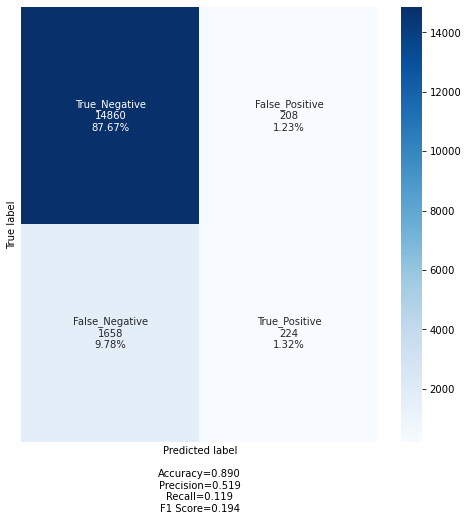

In [49]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix
# Invoca a função com o modelo baseline
i_CV = 10
l_colunas = X_treinamento.columns
ml_DT2, best_params = GridSearchOptimizer(ml_DT, 'ml_DT2', d_hiperparametros_DT, X_treinamento, y_treinamento, X_teste, y_teste, i_CV, l_colunas)

In [50]:
best_params

{'criterion': 'entropy',
 'max_depth': 9,
 'max_leaf_nodes': None,
 'min_samples_leaf': 40,
 'min_samples_split': 180}

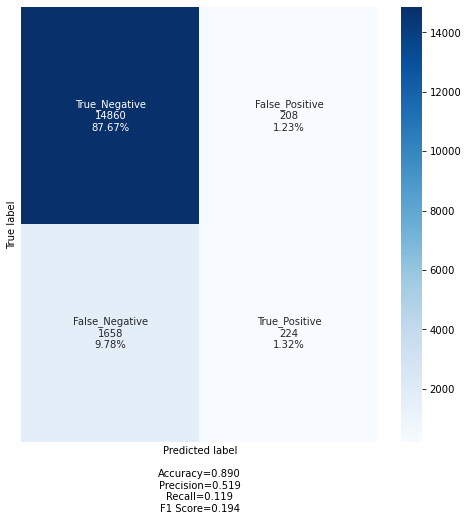

In [51]:
from sklearn.metrics import confusion_matrix
y_pred = ml_DT2.predict(X_teste)
cf_matrix = confusion_matrix(y_teste, y_pred)
cf_labels = ['True_Negative', 'False_Positive', 'False_Negative', 'True_Positive']
cf_categories = ['Zero', 'One']
mostra_confusion_matrix(cf_matrix, group_names= cf_labels, categories= cf_categories)

In [52]:
print(f'\n********* IMPORTÂNCIA DAS COLUNAS ***********')
l_colunas = X_treinamento.columns
df_importancia_variaveis = pd.DataFrame(zip(l_colunas, ml_DT2.feature_importances_), columns= ['coluna', 'importancia'])
df_importancia_variaveis = df_importancia_variaveis.sort_values(by= ['importancia'], ascending=False)
print(df_importancia_variaveis)


********* IMPORTÂNCIA DAS COLUNAS ***********
                 coluna  importancia
16             REC_PROP         0.28
22  QT_ELEITOS_ELEC_ANT         0.15
21  VOTOS_PART_ELEC_ANT         0.15
17               REC_PF         0.13
15           VR_DESPESA         0.10
2               ocup_le         0.07
14          VL_TOT_BENS         0.04
19         REC_PARTCAND         0.02
3      IDADE_DATA_POSSE         0.01
0                 ue_le         0.01
18               REC_PJ         0.01
11              comp_le         0.01
4             genero_le         0.01
1            partido_le         0.00
13              QT_BENS         0.00
8                 uf_le         0.00
9                 mn_le         0.00
12          QT_PART_COL         0.00
5          instrucao_le         0.00
10              agre_le         0.00
7                nac_le         0.00
6           estcivil_le         0.00
20           REC_OUTRAS         0.00

[23 rows x 2 columns]


In [53]:
ml_DT2.score(X_teste, y_teste)

0.8899115044247787

In [54]:
y_train_pred = ml_DT2.predict(X_treinamento)
y_test_pred = ml_DT2.predict(X_teste)
print(f'Train score {accuracy_score(y_train_pred,y_treinamento)}')
print(f'Test score {accuracy_score(y_test_pred,y_teste)}')
#print(f'Melhores parametros: {ml_DT3.__dict__}')

Train score 0.8937800252844501
Test score 0.8899115044247787


In [55]:
ml_DT2.__dict__

{'criterion': 'entropy',
 'splitter': 'best',
 'max_depth': 9,
 'min_samples_split': 40,
 'min_samples_leaf': 180,
 'min_weight_fraction_leaf': 0.0,
 'max_features': None,
 'max_leaf_nodes': None,
 'random_state': 2021,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'class_weight': None,
 'presort': 'deprecated',
 'ccp_alpha': 0.0,
 'n_features_in_': 23,
 'n_features_': 23,
 'n_outputs_': 1,
 'classes_': array([0, 1]),
 'n_classes_': 2,
 'max_features_': 23,
 'tree_': <sklearn.tree._tree.Tree at 0x7fe818823f10>}

In [56]:
ml_DT2

DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_leaf=180,
                       min_samples_split=40, random_state=2021)

### Nova arvore, após grid search

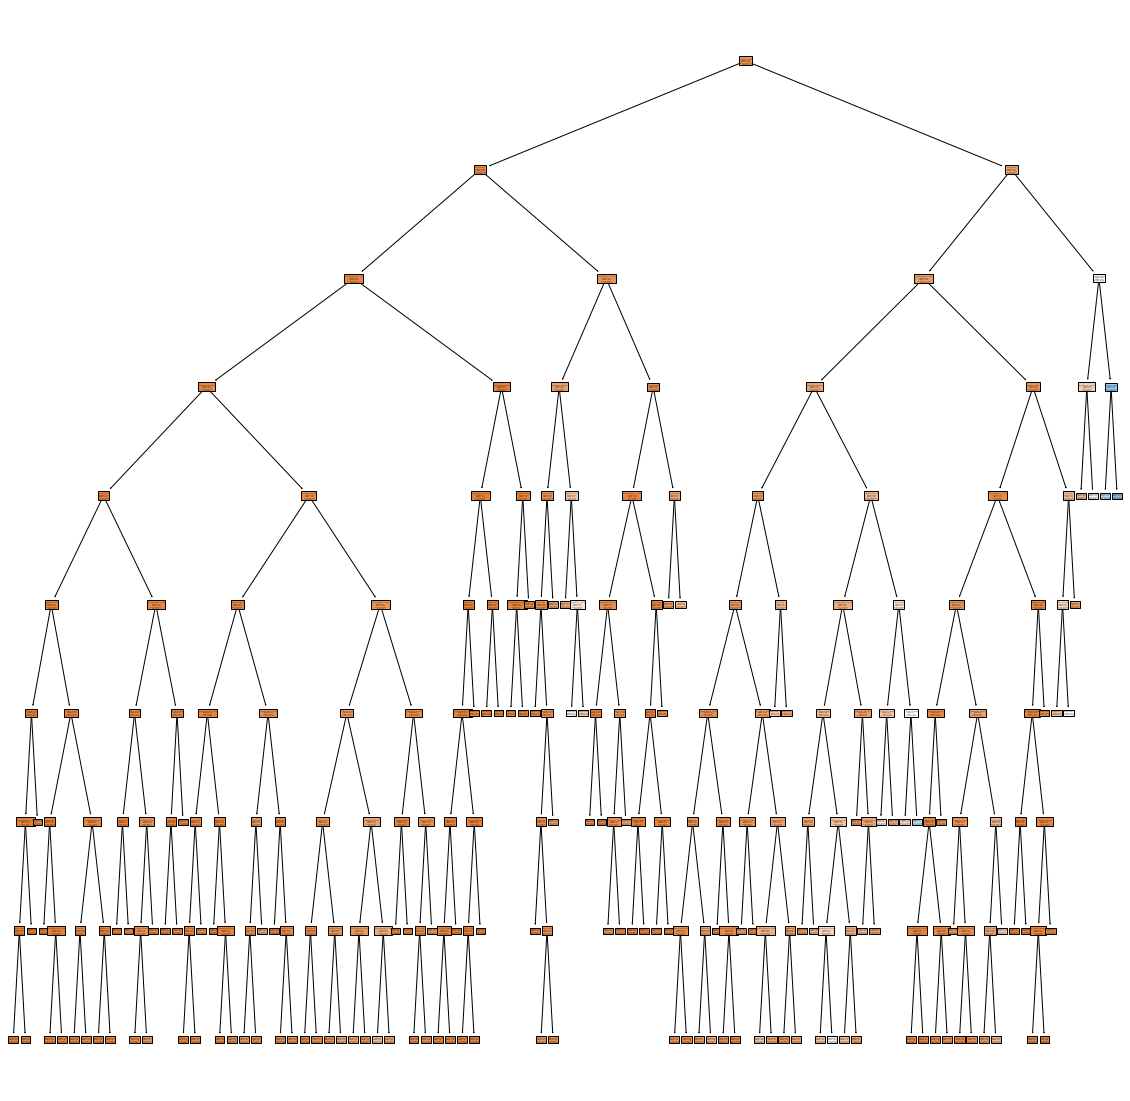

In [57]:
plt.figure(figsize=(20,20))
features = df.columns
classes = ['Churn','No Churn']
tree.plot_tree(ml_DT2,feature_names=features,class_names=classes,filled=True)
plt.show()

In [58]:
# seleciona colunas relevantes
X_treinamento_DT, X_teste_DT = seleciona_colunas_relevantes(ml_DT2, X_treinamento, X_teste)

/home/finotti/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.05 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



********** COLUNAS Relevantes ******
[ 2 15 16 17 21 22]


In [59]:
best_params

{'criterion': 'entropy',
 'max_depth': 9,
 'max_leaf_nodes': None,
 'min_samples_leaf': 40,
 'min_samples_split': 180}

In [60]:
# Treina usando as COLUNAS relevantes...
ml_DT2.fit(X_treinamento_DT, y_treinamento)

DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_leaf=180,
                       min_samples_split=40, random_state=2021)

In [61]:
# Cross-Validation com 10 folds
a_scores_CV = funcao_cross_val_score(ml_DT2, X_treinamento_DT, y_treinamento, i_CV)

Média das Acurácias calculadas pelo CV....: 89.2
std médio das Acurácias calculadas pelo CV: 0.16999999999999998


Fitting 10 folds for each of 5250 candidates, totalling 52500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

[Parallel(n_jobs=-1)]: Done 32424 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 32956 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 33488 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 34028 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 34568 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 35116 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 35664 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 36220 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 36776 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 37340 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 37904 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 38476 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 39048 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 39628 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 40208 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 40796 tasks 


Parametros otimizados: {'criterion': 'entropy', 'max_depth': 9, 'max_leaf_nodes': None, 'min_samples_leaf': 60, 'min_samples_split': 150}

DecisionTreeClassifier *********************************************************************************************************

********* CROSS-VALIDATION ***********
Média das Acurácias calculadas pelo CV....: 89.17
std médio das Acurácias calculadas pelo CV: 0.15

********* IMPORTÂNCIA DAS COLUNAS ***********
             coluna  importancia
2           ocup_le         0.29
4         genero_le         0.18
5      instrucao_le         0.17
3  IDADE_DATA_POSSE         0.15
1        partido_le         0.13
0             ue_le         0.08

[6 rows x 2 columns]

********* CONFUSION MATRIX - PARAMETER TUNNING ***********


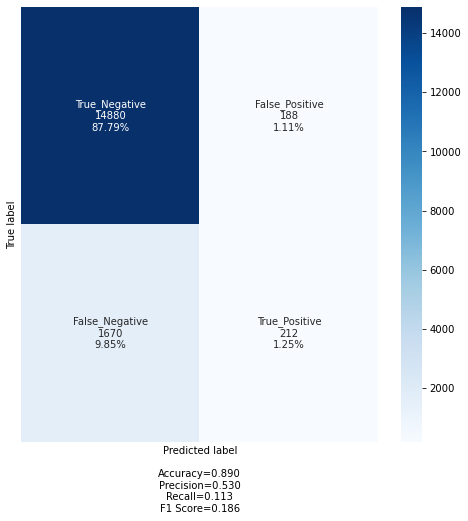

In [63]:
ml_DT3, best_params2 = GridSearchOptimizer(ml_DT2, 'ml_DT2', d_hiperparametros_DT, X_treinamento_DT, y_treinamento, X_teste_DT, y_teste, i_CV, l_colunas)

In [64]:
# Cross-Validation com 10 folds
a_scores_CV = funcao_cross_val_score(ml_DT3, X_treinamento_DT, y_treinamento, i_CV)

Média das Acurácias calculadas pelo CV....: 89.17
std médio das Acurácias calculadas pelo CV: 0.15


In [65]:
# Calcula acurácia
y_pred_DT = ml_DT3.predict(X_teste_DT)
accuracy_score(y_teste, y_pred_DT)

0.8903834808259588

#### Conclusões:
- mesmo após uso dos melhores parametros de grid search, continuamos com F1 score muito ruim
- entendemos que tratar juntos todos os municipios, com suas diferenças e peculiaridas, pode ser um fator a prejudicar o desempenho do modelo
- vamos testar o modelo com apenas um município

## 5.3.2 Decision Tree Classifier apenas para o município de São Paulo

#### Fazendo o aprendizado somente para um municipio

In [ ]:
# agrupar por municipio e ordenar pela quantidade de candidatos
# o único que atende, individualmente, ao requisito mínimo da Puc-Minas (de 1000 observação) é São Paulo
base.groupby('NM_UE').agg({'SG_PARTIDO':'count'}).sort_values('SG_PARTIDO', ascending=False).head()

In [67]:
# agrupar por municipio e ordenar pela quantidade de candidatos
# o único que atende, individualmente, ao requisito mínimo da Puc-Minas (de 1000 observação) é São Paulo
df_temp_b.groupby('ue_le').agg({'partido_le':'count'}).sort_values('partido_le', ascending=False).head()

,partido_le
ue_le,
572,1060
204,841
100,686
554,456
381,448


In [68]:
# cria o dataset apenas com os registros de candidaturas do município de São Paulo
df_temp_c = df_temp_b.query('ue_le == 572').copy()

In [69]:
# avaliação do balanceamento do dataset
resumo_base_treino(df_temp_c, df_temp_c.RESULTADO)

*** Resumo Amostra de treinamento ***
1060 observações na amostra de treinamento
23 colunas preditoras
46 observações por coluna preditora
0.95 : 0.05 - balanceamento da coluna target


### Correlação entre as preditoras

### Prepara e separa a base

In [134]:
df = df_temp_c.copy()

In [135]:
# Separar preditoras do target
df_y = df[['RESULTADO']].copy()
df_X = df.drop(columns='RESULTADO')

In [136]:
# separar a amostra de treinamento
i_size = 0.3
i_Seed = 2021

from sklearn.model_selection import train_test_split
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(df_X, df_y, test_size = i_size, random_state = i_Seed)

In [137]:
print(f'X treino: {X_treinamento.shape}')
print(f'y treino: {y_treinamento.shape}')
print(f'X teste : {X_teste.shape}')
print(f'y teste : {y_teste.shape}')

X treino: (742, 23)
y treino: (742, 1)
X teste : (318, 23)
y teste : (318, 1)


## 5.3.2.1 Modelo 1: inicial
- Decision Tree com parametros padrão

In [138]:
from sklearn.tree import DecisionTreeClassifier # Library para Decision Tree (Classificação)
from sklearn import tree

# Instancia (configuração do Decision Trees) com os parâmetros sugeridos para se evitar overfitting:
ml_DT = DecisionTreeClassifier()

In [139]:
# Treina o modelo
ml_DT.fit(X_treinamento, y_treinamento)

DecisionTreeClassifier()

In [140]:
# Acuracias modelo
print(f'Acurácia base treino: {ml_DT.score(X_treinamento, y_treinamento)}')
print(f'Acurácia base teste : {ml_DT.score(X_teste, y_teste)}')

Acurácia base treino: 1.0
Acurácia base teste : 0.9465408805031447


### Observações:
- pela comparação das acurácias, vemos um modelo muito bom com a base de treino e mediano com a base teste
- indicativo de overfitting

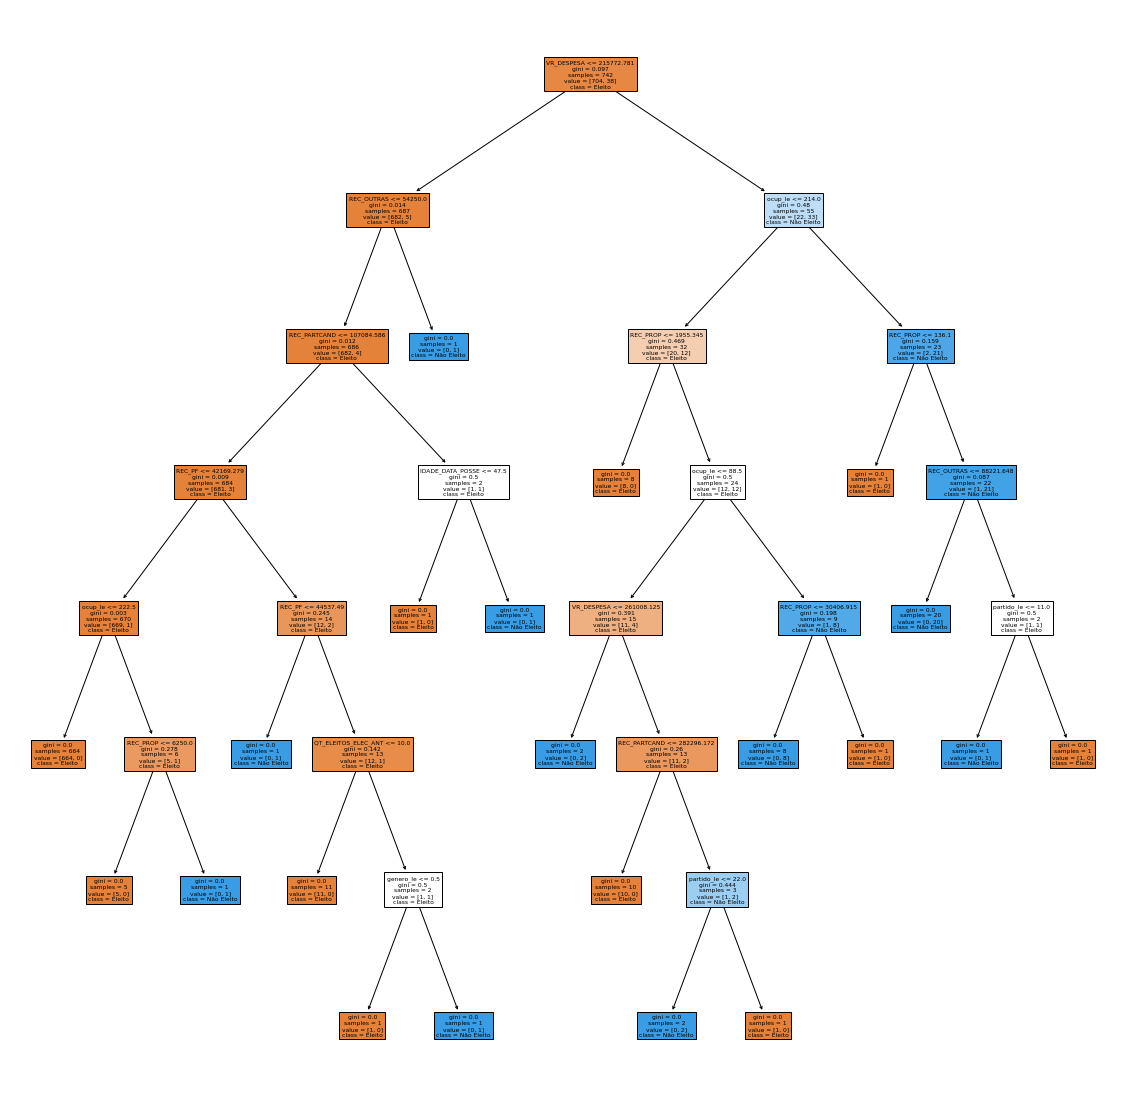

In [141]:
plt.figure(figsize=(20,20))
features = df.columns
classes = ['Eleito','Não Eleito']
tree.plot_tree(ml_DT,feature_names=features,class_names=classes,filled=True)
plt.show()

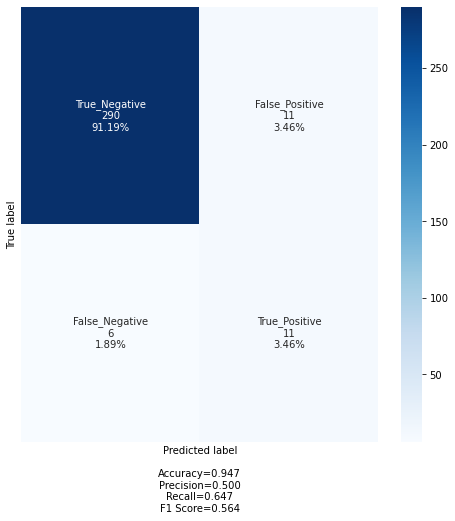

In [142]:
from sklearn.metrics import confusion_matrix
y_pred = ml_DT.predict(X_teste)
cf_matrix = confusion_matrix(y_teste, y_pred)
cf_labels = ['True_Negative', 'False_Positive', 'False_Negative', 'True_Positive']
cf_categories = ['Zero', 'One']
mostra_confusion_matrix(cf_matrix, group_names= cf_labels, categories= cf_categories)

In [156]:
# importância das colunas preditoras neste modelo
pd.DataFrame(zip(X_treinamento.columns, ml_DT.feature_importances_), 
             columns=['preditora','importância']).sort_values('importância', ascending=False).head(10)

,preditora,importância
15,VR_DESPESA,0.53
2,ocup_le,0.17
16,REC_PROP,0.11
19,REC_PARTCAND,0.04
20,REC_OUTRAS,0.04
1,partido_le,0.03
17,REC_PF,0.03
3,IDADE_DATA_POSSE,0.01
4,genero_le,0.01
22,QT_ELEITOS_ELEC_ANT,0.01


## 5.3.2.2 Modelo 2: com ajuste de hyperparâmetros
- Decision Tree com parameter tunning

###  Vários Hyperparametros, com Cross Validation (k=10)

In [152]:
# Dicionário com hiperparâmetros para o parameter tunning. Ao todo serão ajustados 2X13X5X5X7= 4.550 modelos. Contando com 10 folds no Cross-Validation, então são 45.500 modelos.
d_hiperparametros_DT = {"criterion": ["gini", "entropy"], 
                   "min_samples_split": [2, 5, 10, 30, 50, 70, 90, 120, 150, 180, 210, 240, 270, 350, 400], 
                   "max_depth": [None, 2, 5, 9, 15], 
                   "min_samples_leaf": [20, 40, 60, 80, 100], 
                   "max_leaf_nodes": [None, 2, 3, 4, 5, 10, 15]}

### Modelo 2: após grid search, com escolha dos melhores parametros

Fitting 10 folds for each of 5250 candidates, totalling 52500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1965s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0560s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0520s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1029s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 408 t


Parametros otimizados: {'criterion': 'gini', 'max_depth': None, 'max_leaf_nodes': None, 'min_samples_leaf': 20, 'min_samples_split': 2}

DecisionTreeClassifier *********************************************************************************************************

********* CROSS-VALIDATION ***********
Média das Acurácias calculadas pelo CV....: 96.5
std médio das Acurácias calculadas pelo CV: 2.17

********* IMPORTÂNCIA DAS COLUNAS ***********
                 coluna  importancia
15           VR_DESPESA         0.62
2               ocup_le         0.26
16             REC_PROP         0.07
14          VL_TOT_BENS         0.03
17               REC_PF         0.02
0                 ue_le         0.00
12          QT_PART_COL         0.00
21  VOTOS_PART_ELEC_ANT         0.00
20           REC_OUTRAS         0.00
19         REC_PARTCAND         0.00
18               REC_PJ         0.00
13              QT_BENS         0.00
11              comp_le         0.00
1            partido_le       

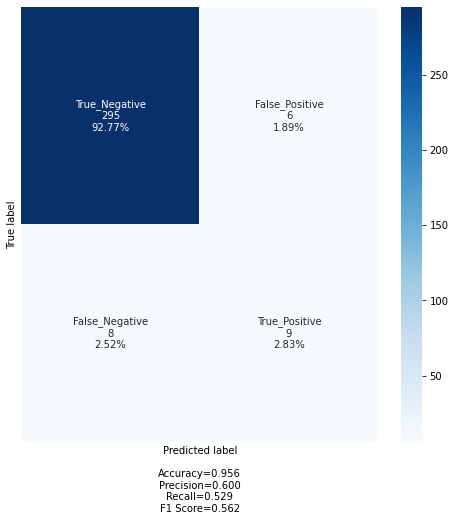

In [153]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix
# Invoca a função com o modelo baseline
i_CV = 10
l_colunas = X_treinamento.columns
ml_DT2, best_params = GridSearchOptimizer(ml_DT, 'ml_DT2', d_hiperparametros_DT, X_treinamento, y_treinamento, X_teste, y_teste, i_CV, l_colunas)

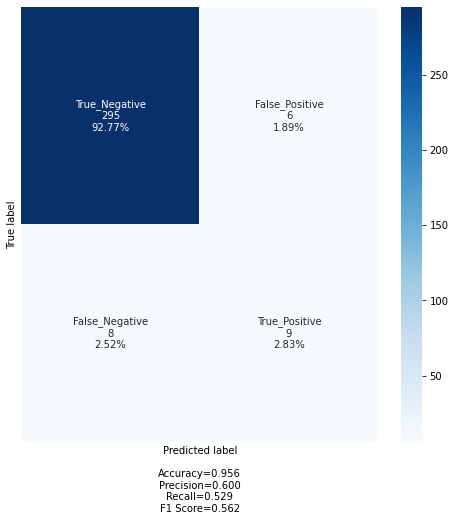

In [154]:
from sklearn.metrics import confusion_matrix
y_pred = ml_DT2.predict(X_teste)
cf_matrix = confusion_matrix(y_teste, y_pred)
cf_labels = ['True_Negative', 'False_Positive', 'False_Negative', 'True_Positive']
cf_categories = ['Zero', 'One']
mostra_confusion_matrix(cf_matrix, group_names= cf_labels, categories= cf_categories)

In [157]:
# importância das colunas preditoras neste modelo
pd.DataFrame(zip(X_treinamento.columns, ml_DT2.feature_importances_), 
             columns=['preditora','importância']).sort_values('importância', ascending=False).head(10)

,preditora,importância
15,VR_DESPESA,0.62
2,ocup_le,0.26
16,REC_PROP,0.07
14,VL_TOT_BENS,0.03
17,REC_PF,0.02
0,ue_le,0.00
12,QT_PART_COL,0.00
21,VOTOS_PART_ELEC_ANT,0.00
20,REC_OUTRAS,0.00
19,REC_PARTCAND,0.00


In [158]:
ml_DT2.score(X_teste, y_teste)

0.9559748427672956

In [159]:
y_train_pred = ml_DT2.predict(X_treinamento)
y_test_pred = ml_DT2.predict(X_teste)
print(f'Train score {accuracy_score(y_train_pred,y_treinamento)}')
print(f'Test score {accuracy_score(y_test_pred,y_teste)}')
#print(f'Melhores parametros: {ml_DT3.__dict__}')

Train score 0.9865229110512129
Test score 0.9559748427672956


### Nova arvore, após grid search

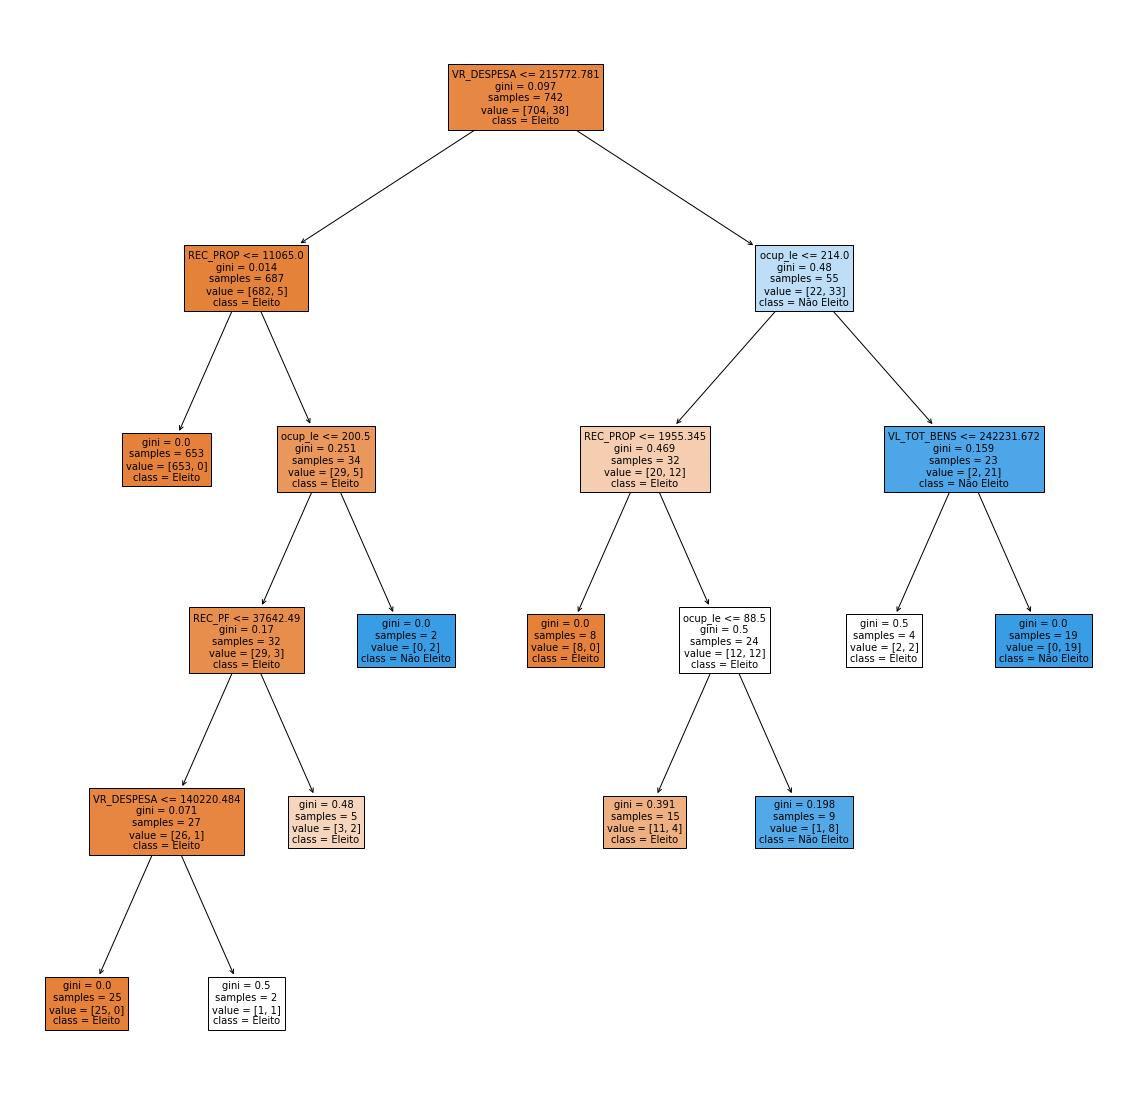

In [162]:
plt.figure(figsize=(20,20))
features = df.columns
classes = ['Eleito','Não Eleito']
tree.plot_tree(ml_DT2,feature_names=features,class_names=classes,filled=True)
plt.show()

### Modelo 3: melhores parametros do grid search e apenas com preditoras mais relevantes

In [160]:
# resumo do modelo 2, no qual vamos baser este modelo 3
ml_DT2

DecisionTreeClassifier(min_samples_leaf=2, min_samples_split=20,
                       random_state=2021)

In [161]:
# melhores parâmetros encontrados pelo grid search:
best_params

{'criterion': 'gini',
 'max_depth': None,
 'max_leaf_nodes': None,
 'min_samples_leaf': 20,
 'min_samples_split': 2}

In [163]:
# seleciona colunas relevantes
X_treinamento_DT, X_teste_DT = seleciona_colunas_relevantes(ml_DT2, X_treinamento, X_teste)


********** COLUNAS Relevantes ******
[ 2 15 16]


/home/finotti/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass threshold=0.05 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [165]:
# Treina usando as COLUNAS relevantes...
ml_DT2.fit(X_treinamento_DT, y_treinamento)

DecisionTreeClassifier(min_samples_leaf=2, min_samples_split=20,
                       random_state=2021)

In [166]:
# Cross-Validation com 10 folds
a_scores_CV = funcao_cross_val_score(ml_DT2, X_treinamento_DT, y_treinamento, i_CV)

Média das Acurácias calculadas pelo CV....: 97.57000000000001
std médio das Acurácias calculadas pelo CV: 1.18


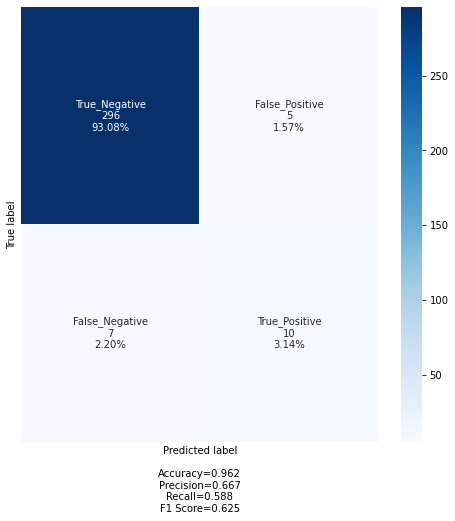

In [167]:
from sklearn.metrics import confusion_matrix
y_pred = ml_DT2.predict(X_teste_DT)
cf_matrix = confusion_matrix(y_teste, y_pred)
cf_labels = ['True_Negative', 'False_Positive', 'False_Negative', 'True_Positive']
cf_categories = ['Zero', 'One']
mostra_confusion_matrix(cf_matrix, group_names= cf_labels, categories= cf_categories)

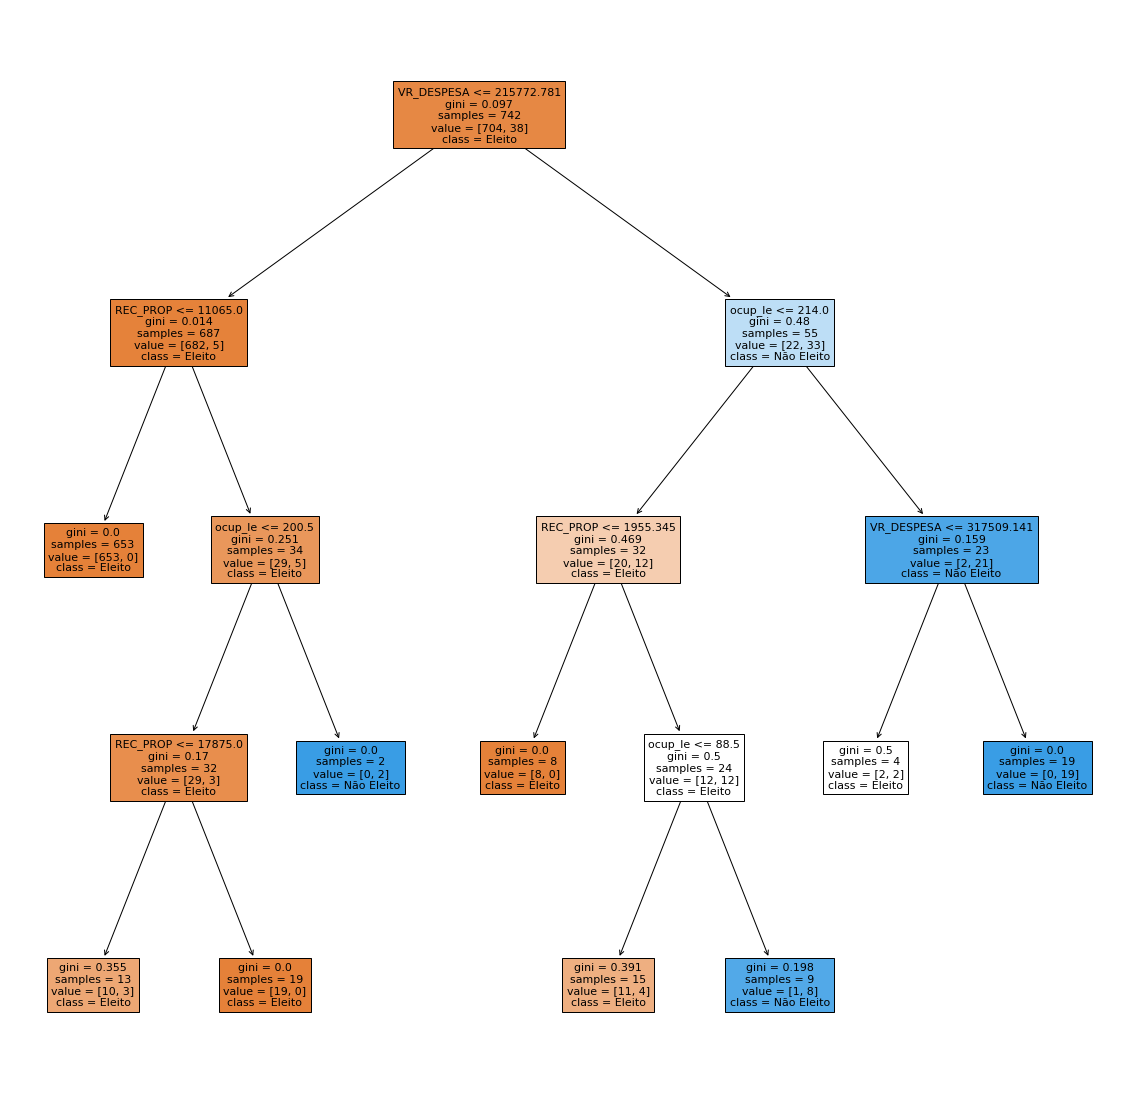

In [173]:
plt.figure(figsize=(20,20))
features = ['ocup_le','VR_DESPESA','REC_PROP']
classes = ['Eleito','Não Eleito']
tree.plot_tree(ml_DT2,feature_names=features,class_names=classes,filled=True)
plt.show()

Fitting 10 folds for each of 5250 candidates, totalling 52500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1674s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0244s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0340s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0626s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Batch comp


Parametros otimizados: {'criterion': 'gini', 'max_depth': None, 'max_leaf_nodes': None, 'min_samples_leaf': 20, 'min_samples_split': 2}

DecisionTreeClassifier *********************************************************************************************************

********* CROSS-VALIDATION ***********
Média das Acurácias calculadas pelo CV....: 97.57000000000001
std médio das Acurácias calculadas pelo CV: 1.18

********* IMPORTÂNCIA DAS COLUNAS ***********
       coluna  importancia
1  partido_le         0.65
0       ue_le         0.26
2     ocup_le         0.09

[3 rows x 2 columns]

********* CONFUSION MATRIX - PARAMETER TUNNING ***********


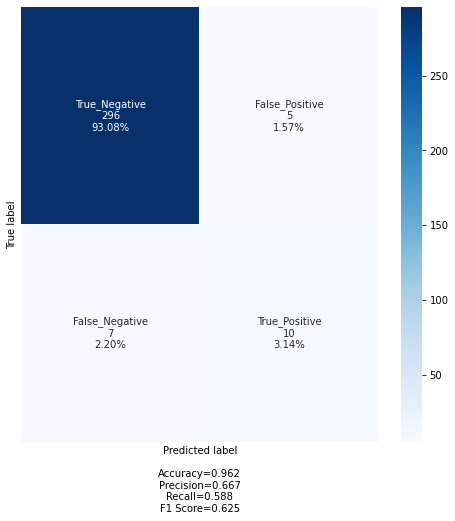

In [174]:
ml_DT3, best_params2 = GridSearchOptimizer(ml_DT2, 'ml_DT2', d_hiperparametros_DT, X_treinamento_DT, y_treinamento, X_teste_DT, y_teste, i_CV, l_colunas)

In [175]:
# Cross-Validation com 10 folds
a_scores_CV = funcao_cross_val_score(ml_DT3, X_treinamento_DT, y_treinamento, i_CV)

Média das Acurácias calculadas pelo CV....: 97.57000000000001
std médio das Acurácias calculadas pelo CV: 1.18


In [176]:
# Calcula acurácia
y_pred_DT = ml_DT3.predict(X_teste_DT)
accuracy_score(y_teste, y_pred_DT)

0.9622641509433962

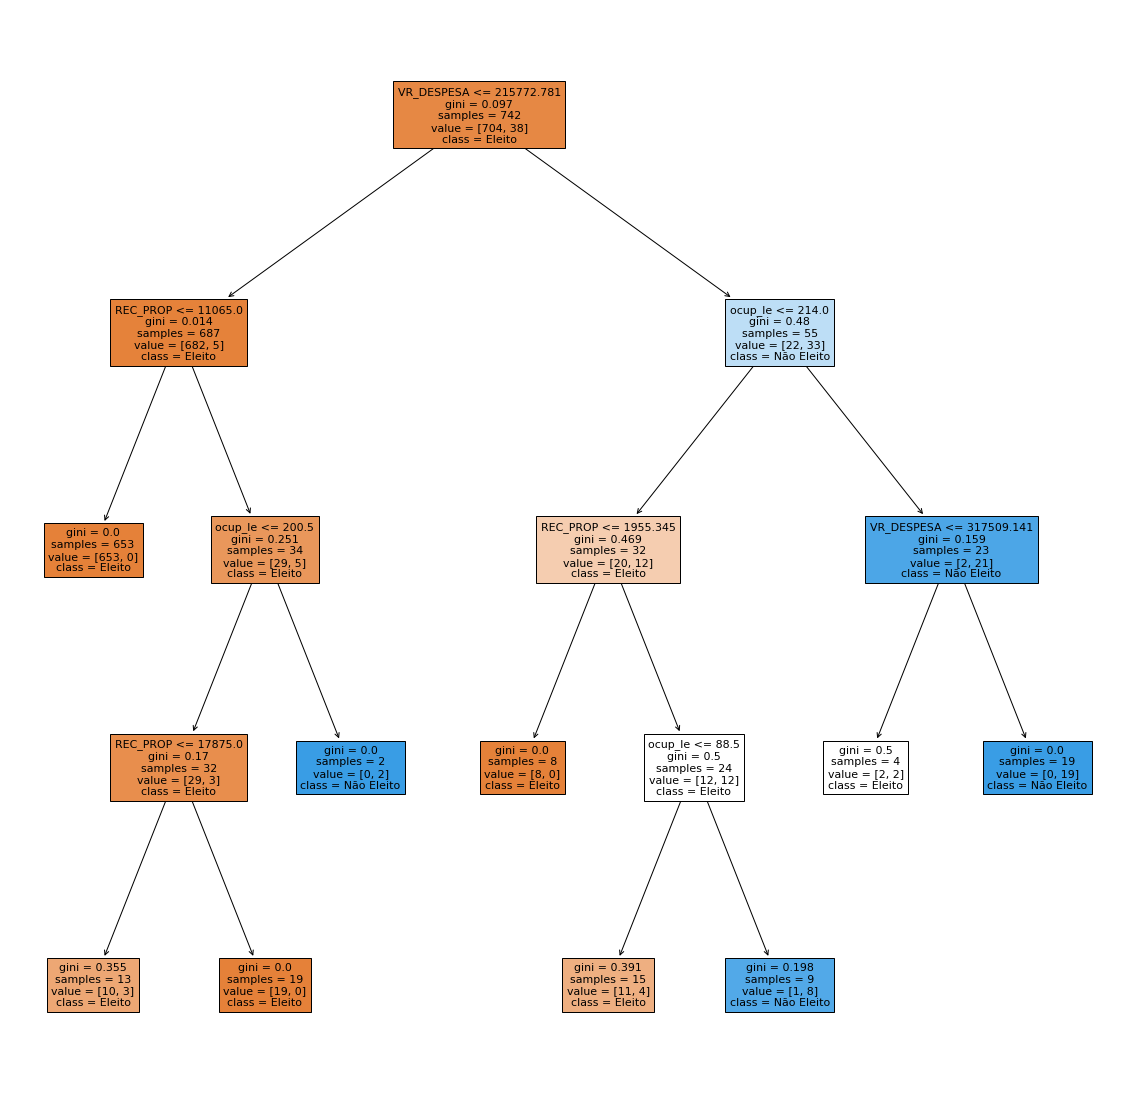

In [177]:
plt.figure(figsize=(20,20))
features = ['ocup_le','VR_DESPESA','REC_PROP']
classes = ['Eleito','Não Eleito']
tree.plot_tree(ml_DT3,feature_names=features,class_names=classes,filled=True)
plt.show()

#### Possibilidades de dados para agregar a base de candidatos
- é efetivo ou comissionado do municipio
- é efetivo ou comissionado do estado
- informações sobre as ultimas legislaturas:
    - média idade das 3 ultimas legislaturas eleitas (na data da eleição)
    - raça 
    - credo
    - composição por partido
    - composição por coligação
- condição em relação partido do prefeito atual (situação ou oposição)
- condição em relação partido dogovernador atual (situação ou oposição)
- quantidade de vagas conquistadas pelo partido na eleição da legislatura atual
- quantidade de vagas conquistadas pela coligação na eleição da legislatura atual
- quantidade votos partido na eleição da legislatura atual

  
    

- https://www.geeksforgeeks.org/python-insert-the-string-at-the-beginning-of-all-items-in-a-list/
- https://stackoverflow.com/questions/2050637/appending-the-same-string-to-a-list-of-strings-in-python
- https://stackoverflow.com/questions/41476150/removing-space-from-dataframe-columns-in-pandas/41476181
- https://stackoverflow.com/questions/43071415/remove-multiple-blanks-in-dataframe
- https://stackoverflow.com/questions/17097643/search-for-does-not-contain-on-a-dataframe-in-pandas
- https://stackoverflow.com/questions/35465741/pandas-convert-column-with-empty-strings-to-float
- https://stackoverflow.com/questions/14745022/how-to-split-a-column-into-two-columns
- https://stackabuse.com/working-with-pdfs-in-python-reading-and-splitting-pages/
- https://www.geeksforgeeks.org/working-with-pdf-files-in-python/
- 